Libralies

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from yahoo_fin.stock_info import get_data
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
pd.options.mode.chained_assignment = None 

Constants

In [2]:
PATH_OF_TRAIN_DATA = os.path.dirname(os.path.abspath('eda.ipynb')) + '\\oil_gas_train\\'
PATH_OF_TEST_DATA = os.path.dirname(os.path.abspath('eda.ipynb')) + '\\oil_gas_train_test\\'

Functions

In [3]:
def download_data(path: str) -> pd.DataFrame:
    names_of_train_tables = os.listdir(path)
    # i do not want to append data to dataframe by parts, so i use dictionary at the beginning
    Container_for_dataframe = {"company_name": [], "rev": [], "date": [], "op_in": []}
    for name in names_of_train_tables:
        name_of_table = PATH_OF_TRAIN_DATA + name
        data = pd.read_excel(name_of_table)
        rev = data.iloc[28].tolist()[9:51]
        date = data.iloc[27].tolist()[9:51]
        op_in = data.iloc[42].tolist()[9:51]
        company_name = name[:-5]
        for i in range(len(rev)):
            Container_for_dataframe["company_name"].append(company_name)
            Container_for_dataframe["rev"].append(rev[i])
            Container_for_dataframe["date"].append(date[i])
            Container_for_dataframe["op_in"].append(op_in[i])
    DF = pd.DataFrame(Container_for_dataframe)
    #don't want to get null data
    DF = DF.loc[DF['rev'] != 0]
    return DF

In [4]:
def company_cross_validation(data: pd.DataFrame, name_of_column: str, model, metrics, train_lenght: int=0, step: int=1, plot: bool=True) -> float:
    """Cross validation for one company data"""
    values_for_metric = {"test":[], "model":[]}
    len_of_data = len(data[name_of_column])
    if not train_lenght:
        train_lenght = int((len_of_data * 0.6)//1)
    for n in range(train_lenght + 1, len_of_data, step):
        train_data = data.iloc[: n]
        values_for_metric["model"].append(model(train_data, name_of_column))
        values_for_metric["test"].append(data[name_of_column][n])
    if plot:
        plt.figure(figsize=(20,10))
        plt.plot(values_for_metric["model"], label='Model')
        plt.plot(values_for_metric["test"], label='Test')
        plt.legend()
        plt.grid()
        plt.show()
    return metrics(values_for_metric["test"], values_for_metric["model"])

In [5]:
def companies_validation(data: pd.DataFrame, name_of_column: str, 
                        model, metrics, train_lenght: int=0, 
                        step: int=1, plot: bool=False) -> pd.DataFrame:
    """Cross validation for a few companies data"""
    validation = {}
    for company_name in data.company_name.unique():
        DF_of_one_company = data.loc[data.company_name == company_name] 
        DF_of_one_company['Time'] = np.arange(len(DF_of_one_company.date))
        DF_of_one_company = DF_of_one_company.reset_index(drop=True)
        validation[company_name] = company_cross_validation(DF_of_one_company, name_of_column, model, metrics)
    return pd.DataFrame.from_dict(validation, orient='index', columns=[name_of_column])

In [20]:
def get_stock_price_for_date(date: pd.Timestamp, ticker: str="USDRUB=X") -> float:
    end_date = date
    start_date = end_date - timedelta(7)
    data = get_data(ticker, start_date = start_date, end_date = end_date, index_as_date = True, interval="1d").dropna()
    return data.open[-1]

In [7]:
def linear_model(data: pd.DataFrame, name_of_column: str):
    """Least squares Linear Regression."""
    model = LinearRegression().fit(np.array(data.Time[:]).reshape((-1,1)), data[name_of_column][:])
    next_value = model.coef_[0] * (data.Time[:].max() + 1) + model.intercept_ 
    return next_value

In [8]:
def multilinear_model(data: pd.DataFrame, name_of_column: str):
    """Least squares Linear Regression with multiply variables."""
    data["future_value"] = data[name_of_column].shift(-1)
    row_to_predict = data.tail(1)
    data = data.dropna()
    model = LinearRegression().fit(data[["rev","op_in","usd","Time"]], data["future_value"][:])
    next_value = model.predict(row_to_predict[["rev","op_in","usd","Time"]])[0]
    return next_value

In [9]:
def naive_model(data: pd.DataFrame, name_of_column: str) -> float:
    return data[name_of_column].iloc[-1]

Download data

In [10]:
Train_DF = download_data(PATH_OF_TRAIN_DATA)

Distributed the data across three clusters using k-means. There are three clusters, and in one of them there is only one point with drastically different values from others. So i just drop it.

In [11]:
revenues = pd.DataFrame(Train_DF.groupby('company_name')['rev'].mean())
op_ins = pd.DataFrame(Train_DF.groupby('company_name')['op_in'].mean())
clasterization = pd.concat([revenues,op_ins], axis=1, join='inner').reset_index()

In [12]:
kmeans = KMeans(n_clusters=3) 
kmeans.fit(np.array(clasterization['rev']).reshape((-1,1)), clasterization['op_in'])
clasterization['claster'] = kmeans.labels_
clasterization = clasterization.drop(clasterization[(clasterization.claster == 1)].index)

I divide the data into two clusters in order to do different processing for them in the future.

In [13]:
Train_DF_Small = clasterization.loc[clasterization.claster == 0]
Train_DF_Small.drop('claster', axis = 1)
Train_DF_Mid = clasterization.loc[clasterization.claster == 2]
Train_DF_Mid.drop(columns = ['claster', 'rev', 'op_in'])
Train_DF_midlle = Train_DF[Train_DF['company_name'].isin(Train_DF_Mid.company_name)] 
Train_DF_small = Train_DF[Train_DF['company_name'].isin(Train_DF_Small.company_name)] 

Find mse for naive model

In [ ]:
Validation_small_rev = companies_validation(Train_DF_small,'rev', naive_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Train_DF_small,'op_in', naive_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Train_DF_midlle,'rev', naive_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Train_DF_midlle,'op_in', naive_model, mean_absolute_error)

In [15]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    51.69805
dtype: float64
op_in    48.933637
dtype: float64
rev    306.893456
dtype: float64
op_in    249.094686
dtype: float64


Find mse for Linear Regression model

In [ ]:
Validation_small_rev = companies_validation(Train_DF_small,'rev', linear_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Train_DF_small,'op_in', linear_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Train_DF_midlle,'rev', linear_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Train_DF_midlle,'op_in', linear_model, mean_absolute_error)


It can be seen that in both cases the error is quite large, and for the linear model everything is worse than for the naive one.


In [17]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    85.785365
dtype: float64
op_in    62.354839
dtype: float64
rev    983.335832
dtype: float64
op_in    424.698657
dtype: float64


Test data. I do everything similarly to the training sample.

In [18]:
Test_DF = download_data(PATH_OF_TEST_DATA)

In [ ]:
Test_DF["usd"] = Test_DF["date"].map(lambda y: get_stock_price_for_date(y,"USDRUB=X"))

In [31]:
revenues = pd.DataFrame(Test_DF.groupby('company_name')['rev'].mean())
op_ins = pd.DataFrame(Test_DF.groupby('company_name')['op_in'].mean())
clasterization = pd.concat([revenues,op_ins], axis=1, join='inner').reset_index()
kmeans = KMeans(n_clusters=3) 
kmeans.fit(np.array(clasterization['rev']).reshape((-1,1)), clasterization['op_in'])

KMeans(n_clusters=3)

In [ ]:
clasterization['claster'] = kmeans.labels_
clasterization = clasterization.drop(clasterization[(clasterization.claster == 1)].index)
Test_DF_Small = clasterization.loc[clasterization.claster == 0]
Test_DF_Small.drop('claster', axis = 1)
Test_DF_Mid = clasterization.loc[clasterization.claster == 2]
Test_DF_Mid.drop(columns = ['claster', 'rev', 'op_in'])
Test_DF_midlle = Test_DF[Test_DF['company_name'].isin(Test_DF_Mid.company_name)] 
Test_DF_small = Test_DF[Test_DF['company_name'].isin(Test_DF_Small.company_name)]
Validation_small_rev = companies_validation(Test_DF_small,'rev', naive_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', naive_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', naive_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', naive_model, mean_absolute_error) 

In [33]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    52.722084
dtype: float64
op_in    50.144816
dtype: float64
rev    306.893456
dtype: float64
op_in    249.094686
dtype: float64


In [ ]:
Validation_small_rev = companies_validation(Test_DF_small,'rev', linear_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', linear_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', linear_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', linear_model, mean_absolute_error) 

In [ ]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    85.785365
dtype: float64
op_in    62.354839
dtype: float64
rev    983.335832
dtype: float64
op_in    424.698657
dtype: float64


Linear Regression with multiply variables with data about USDRUB

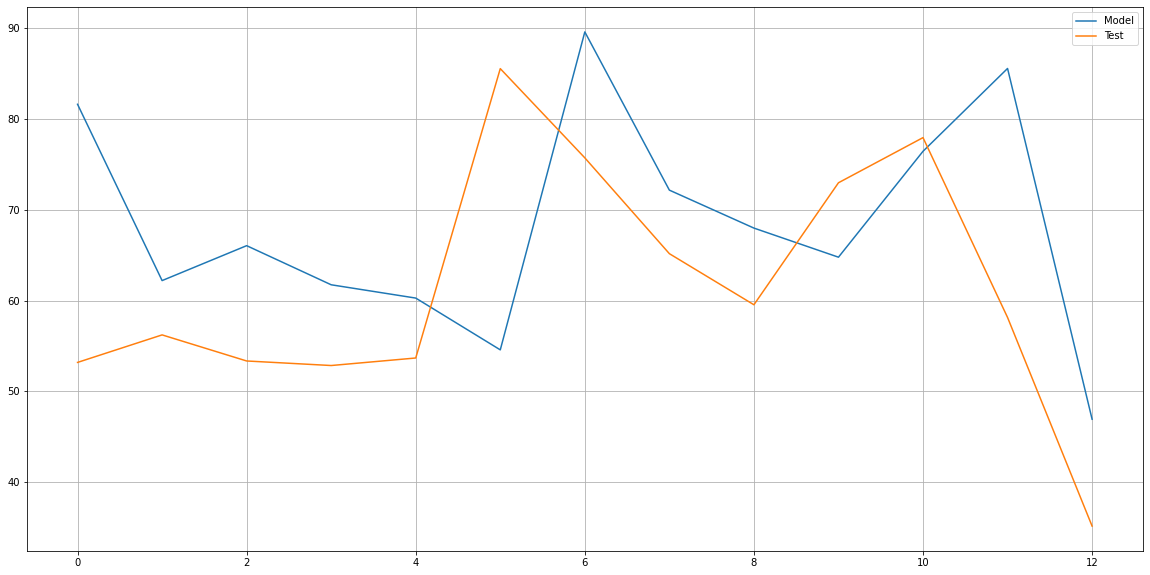

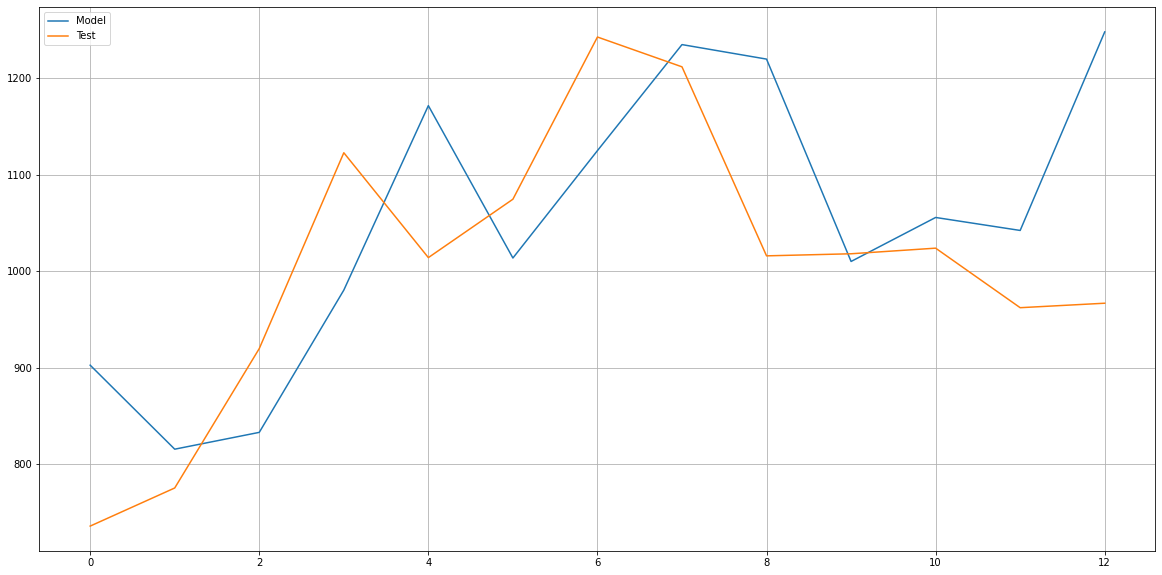

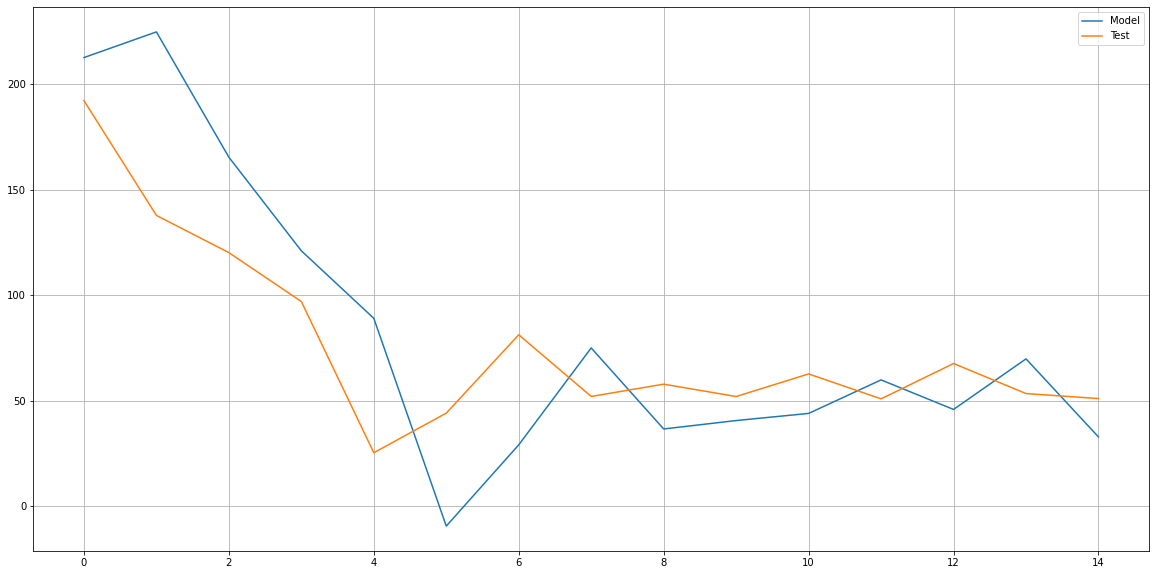

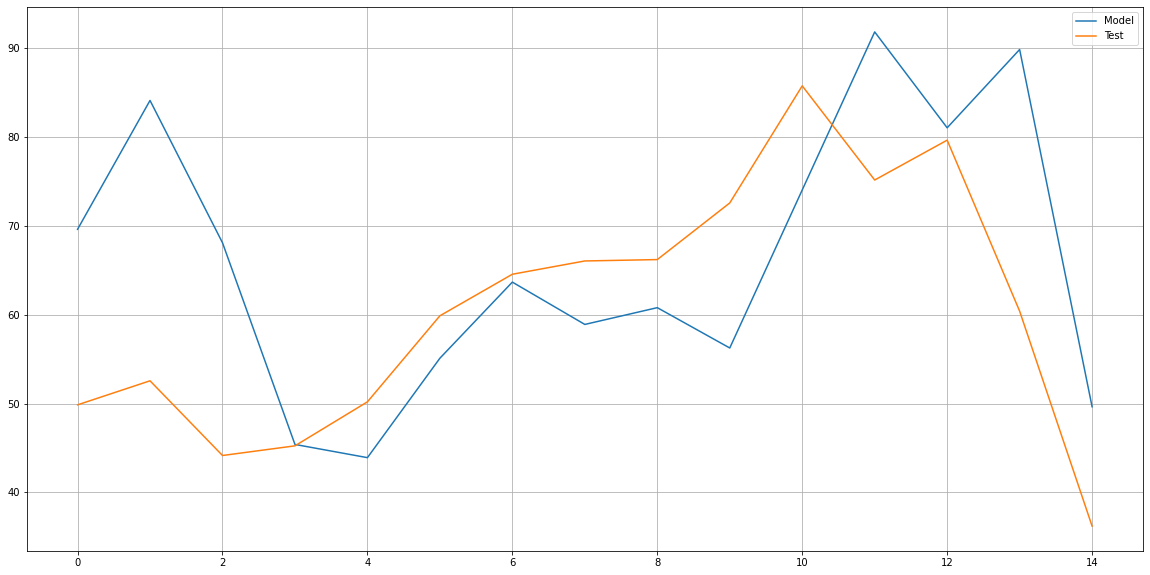

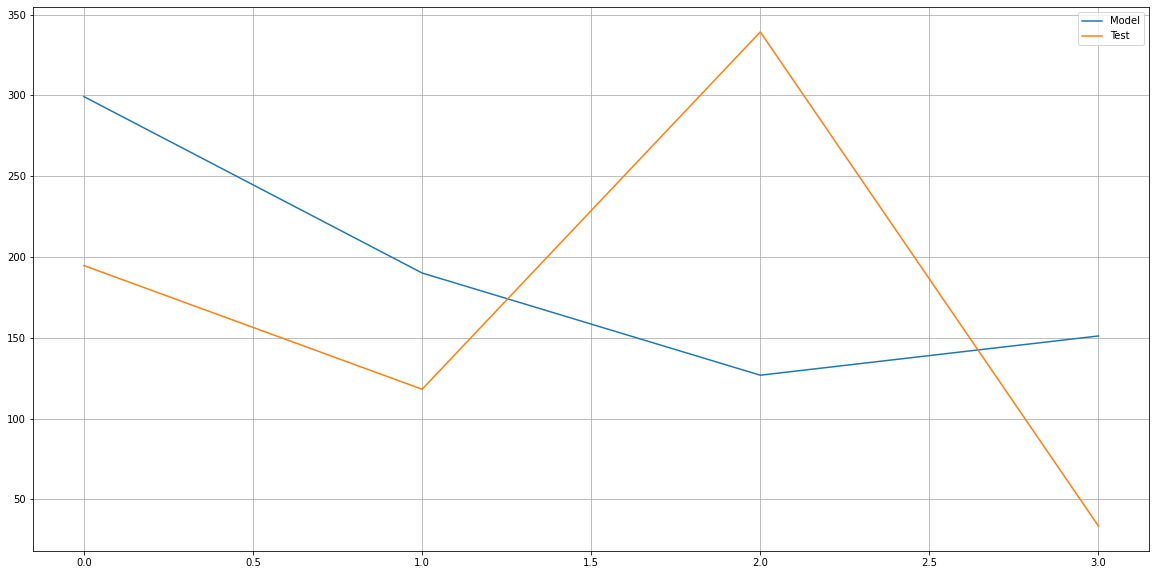

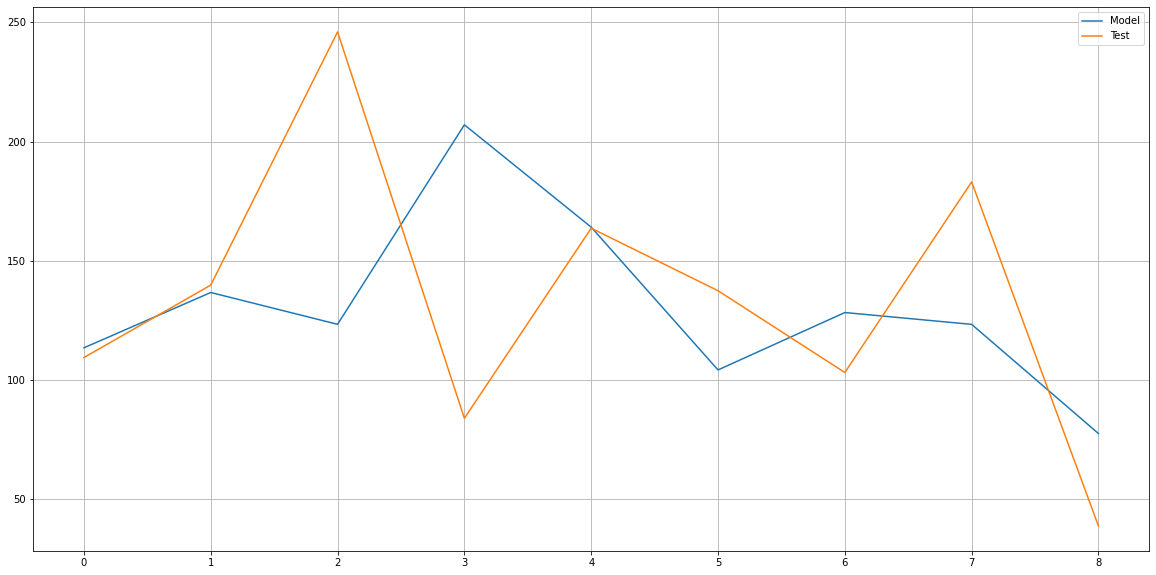

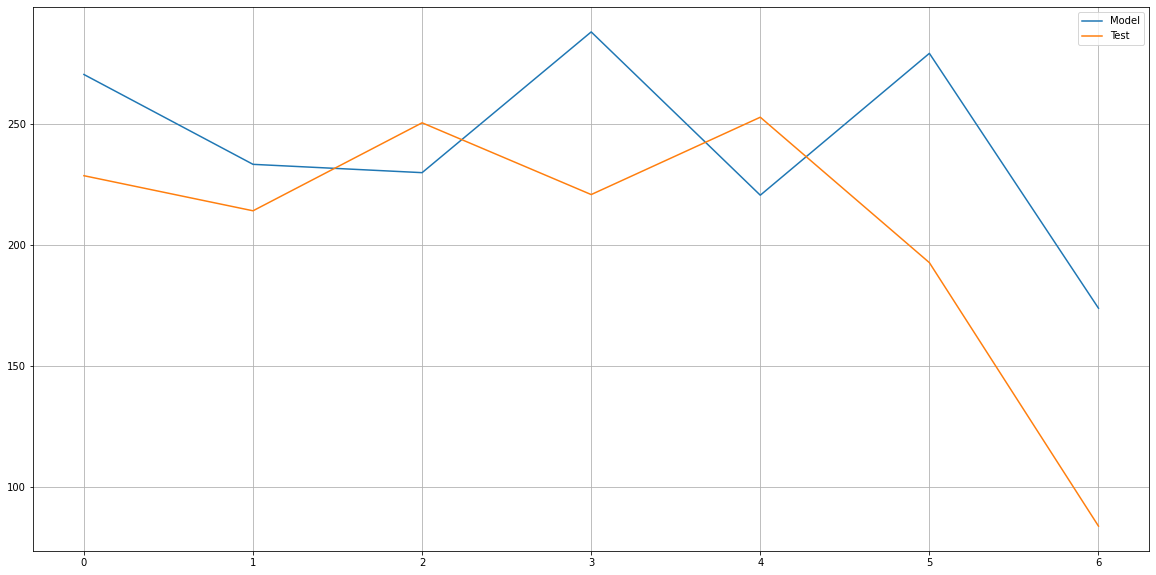

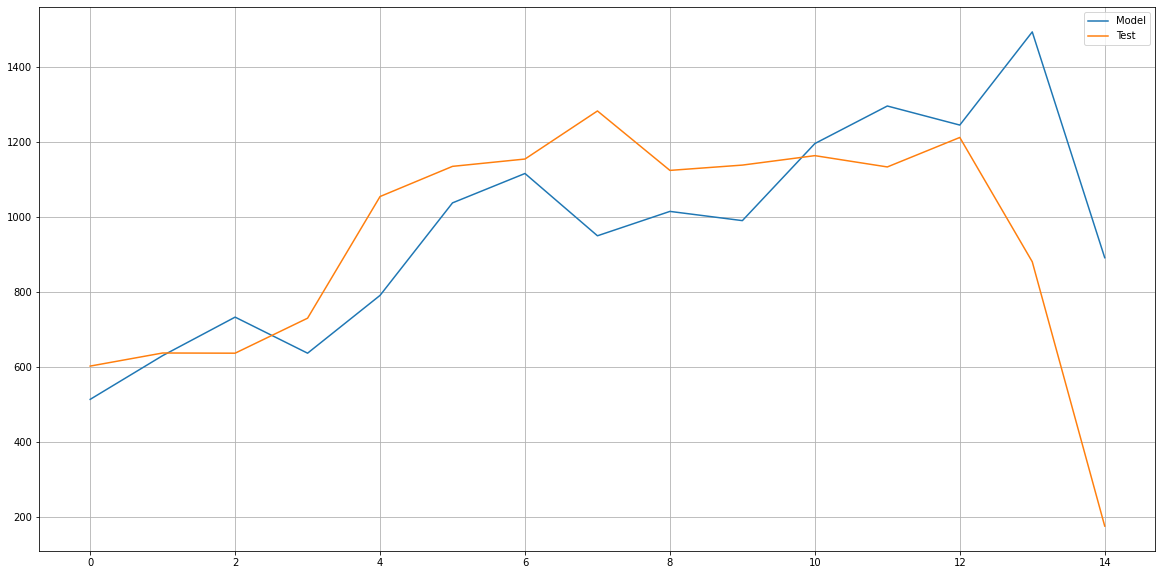

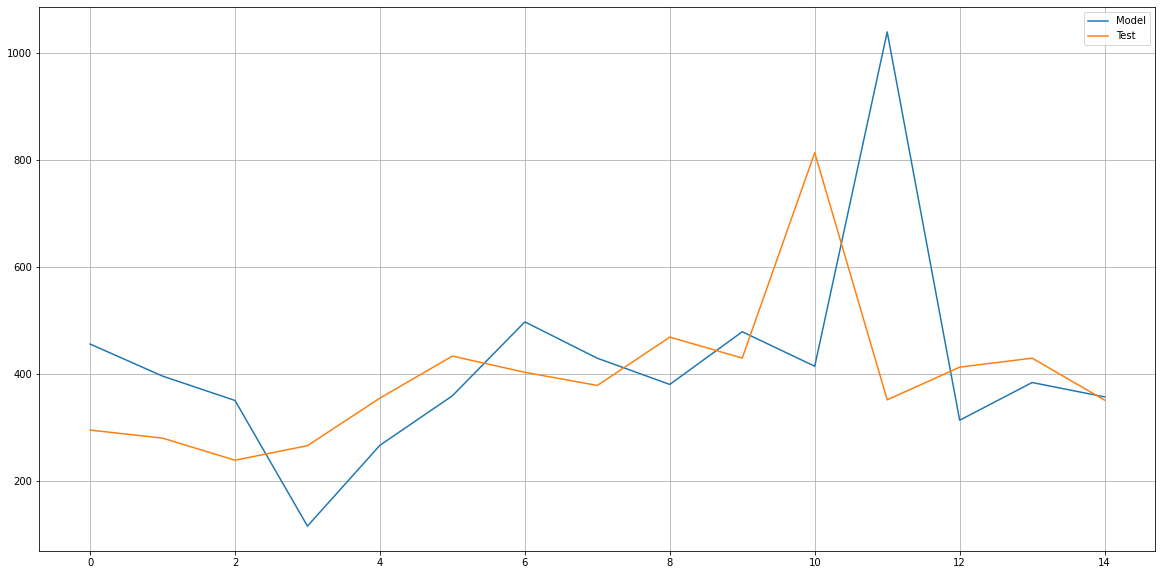

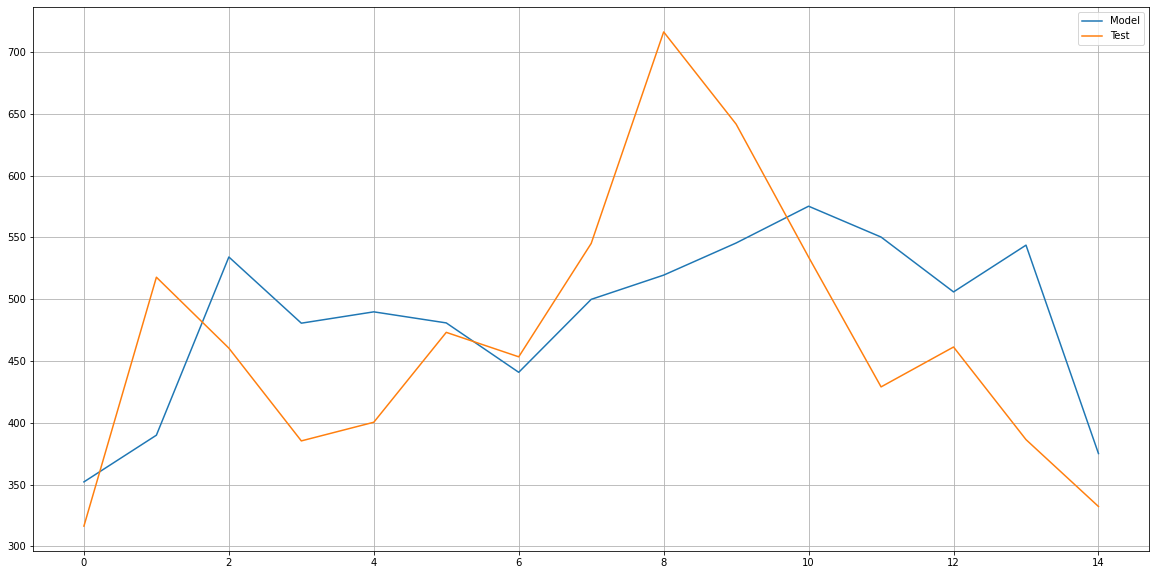

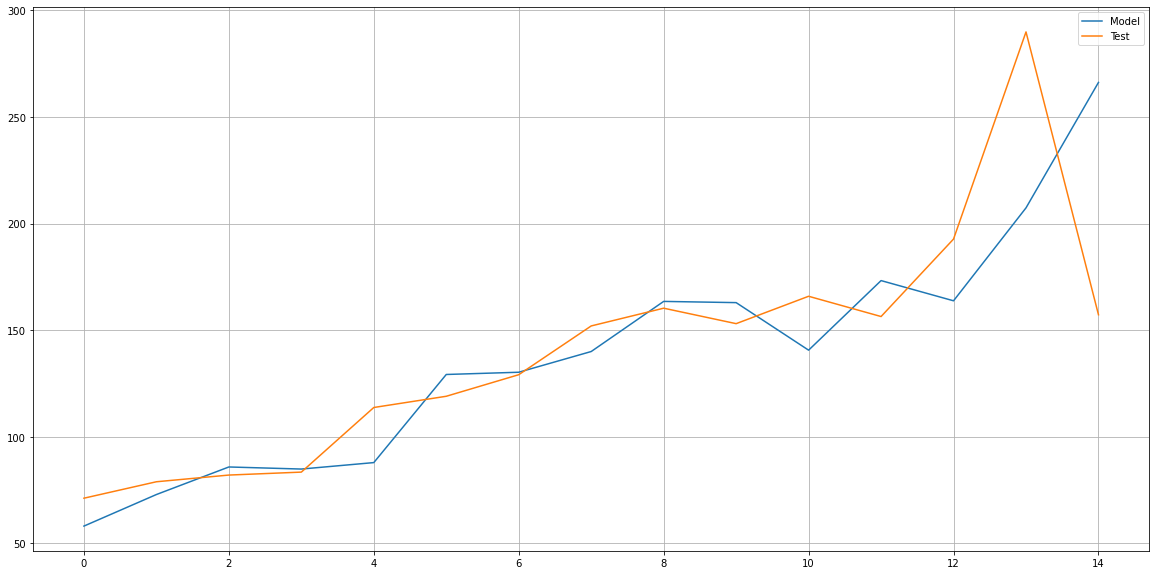

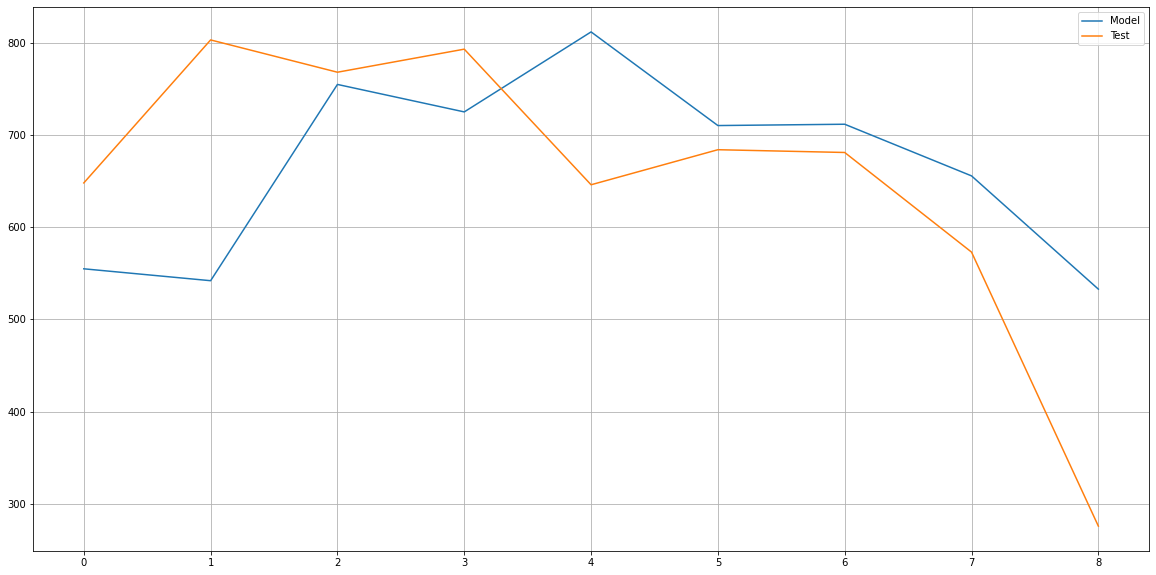

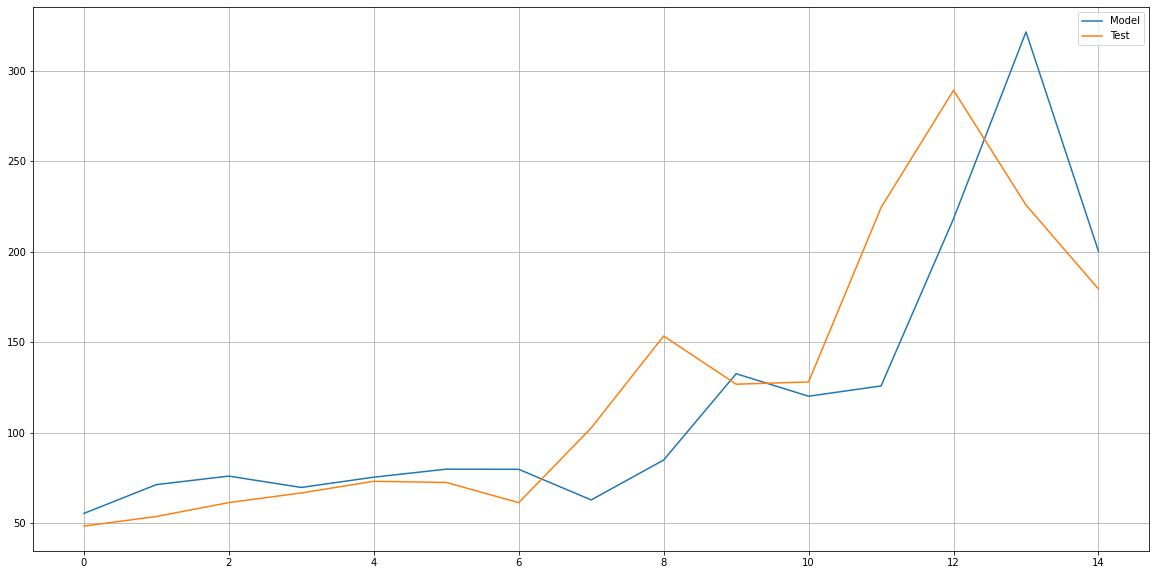

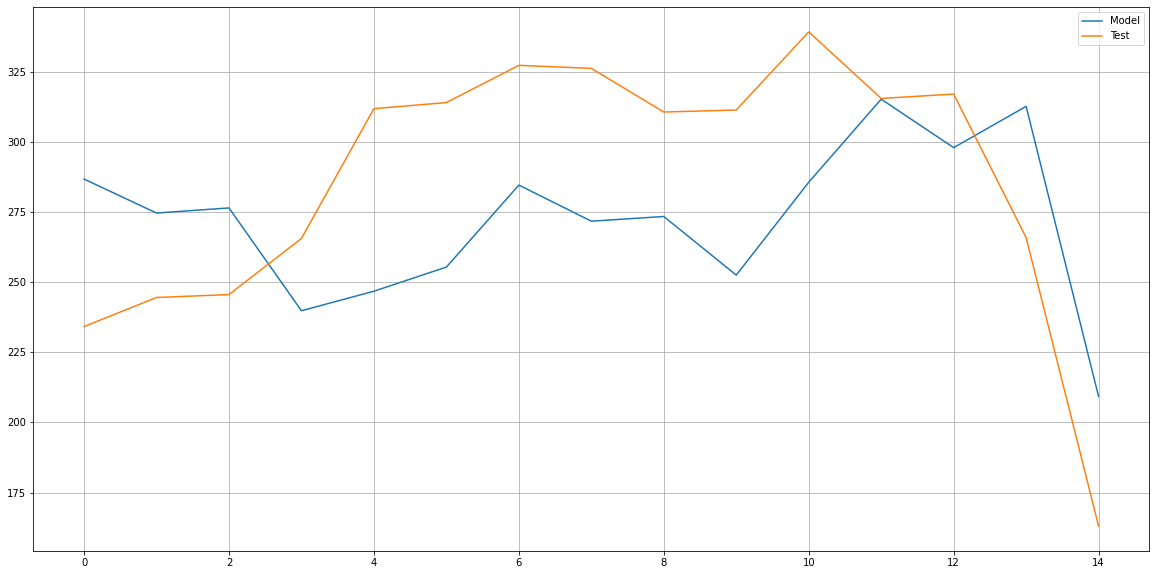

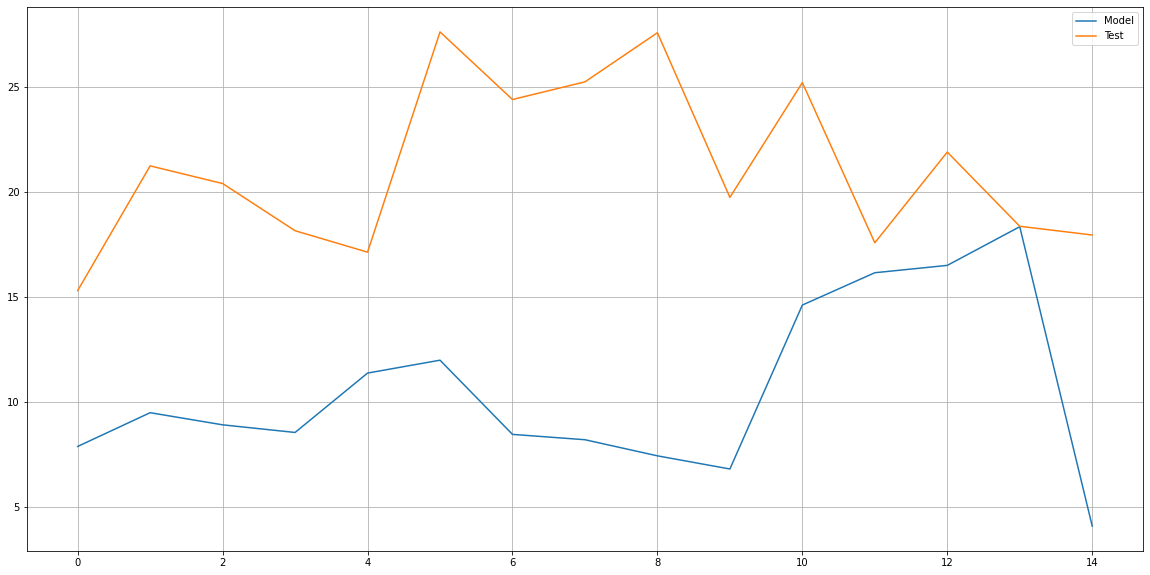

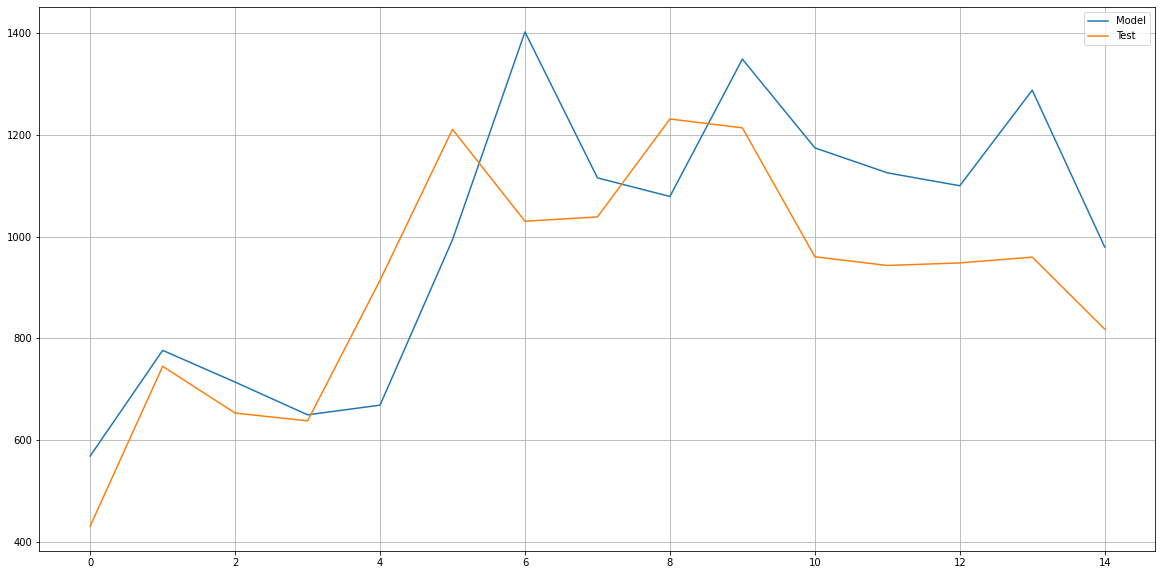

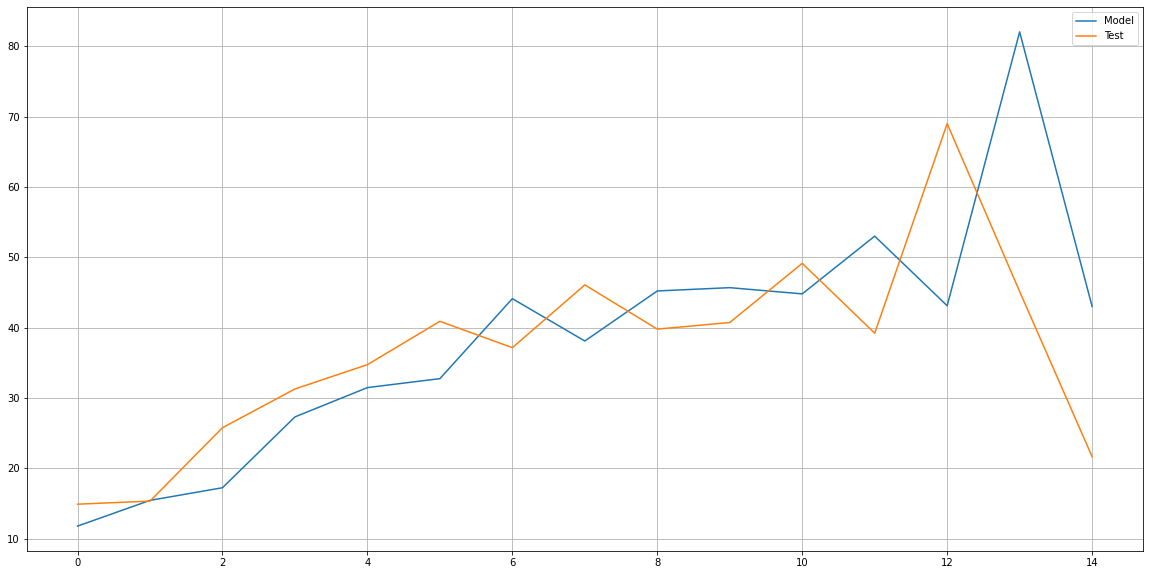

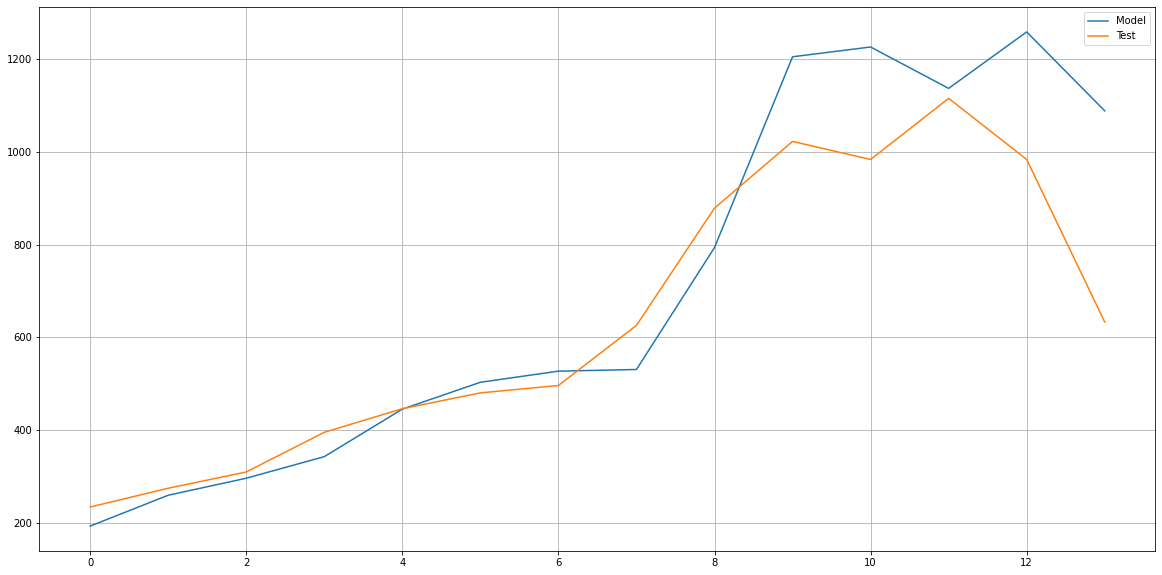

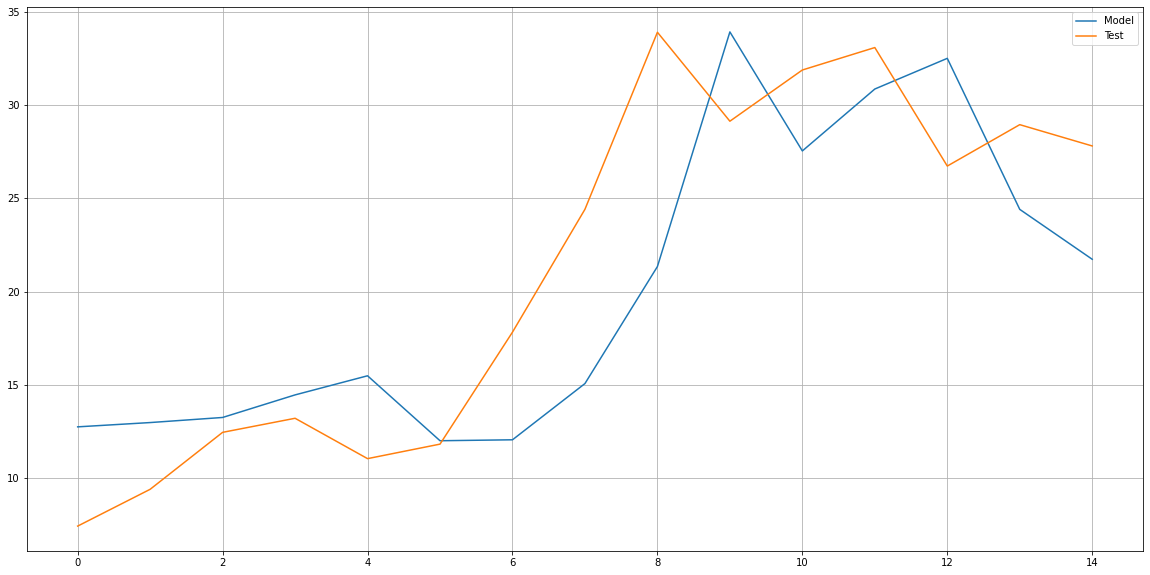

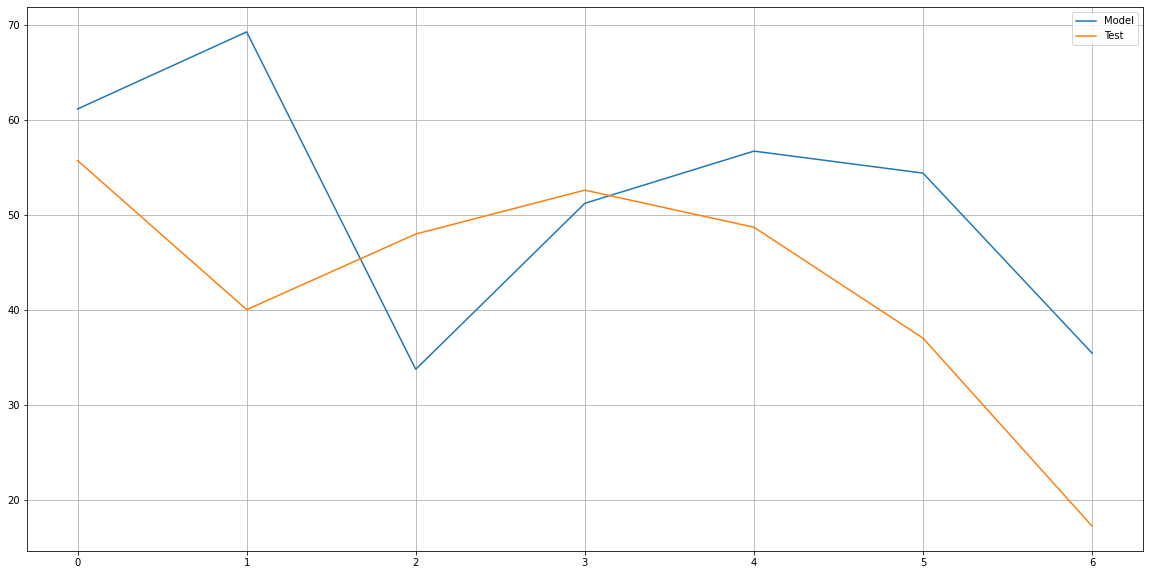

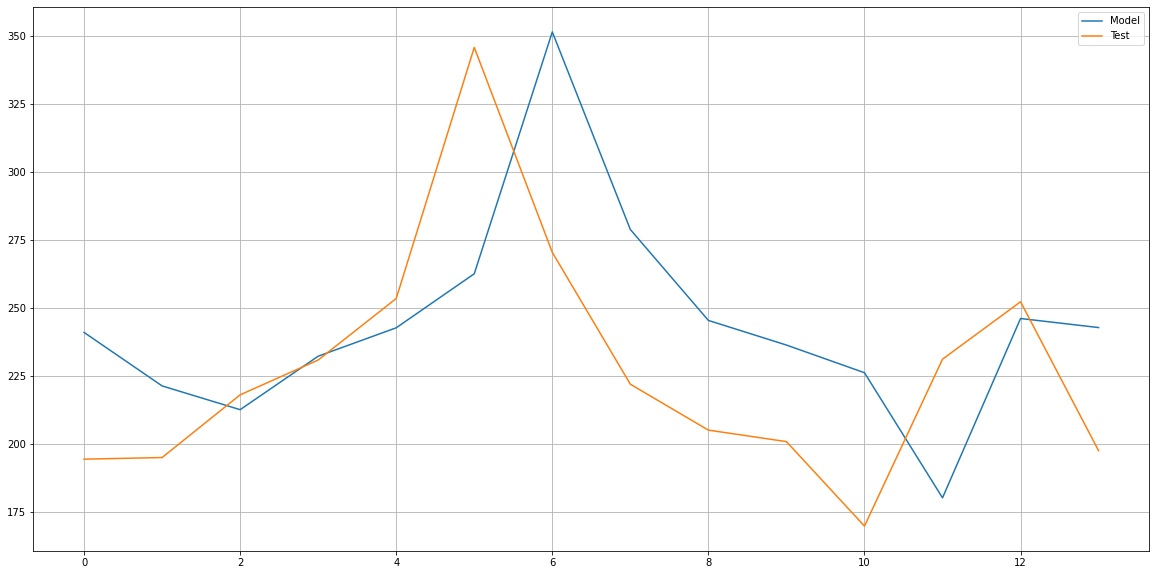

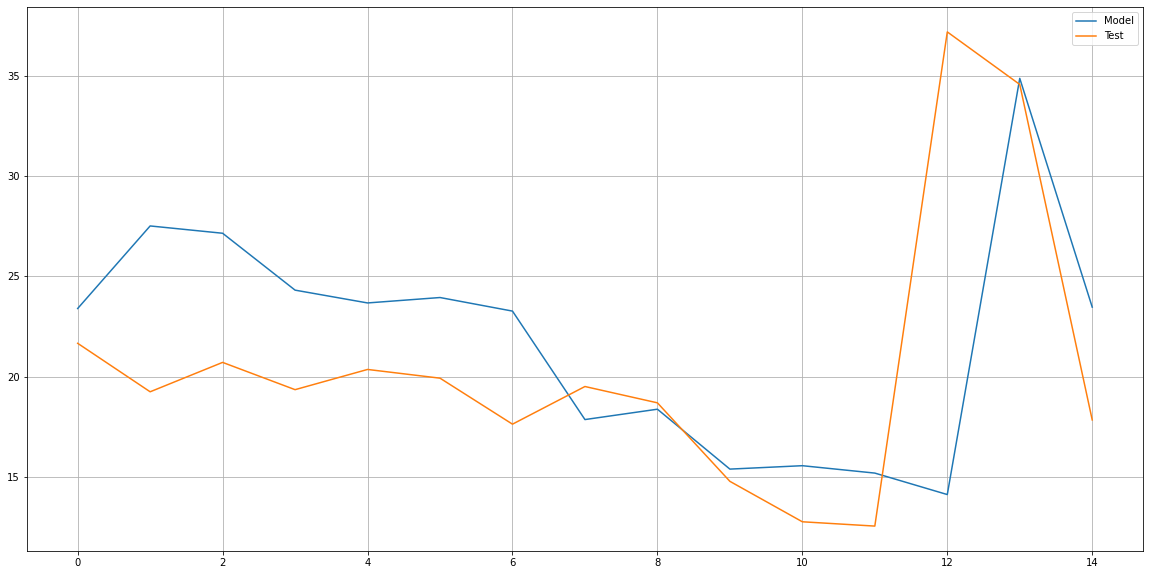

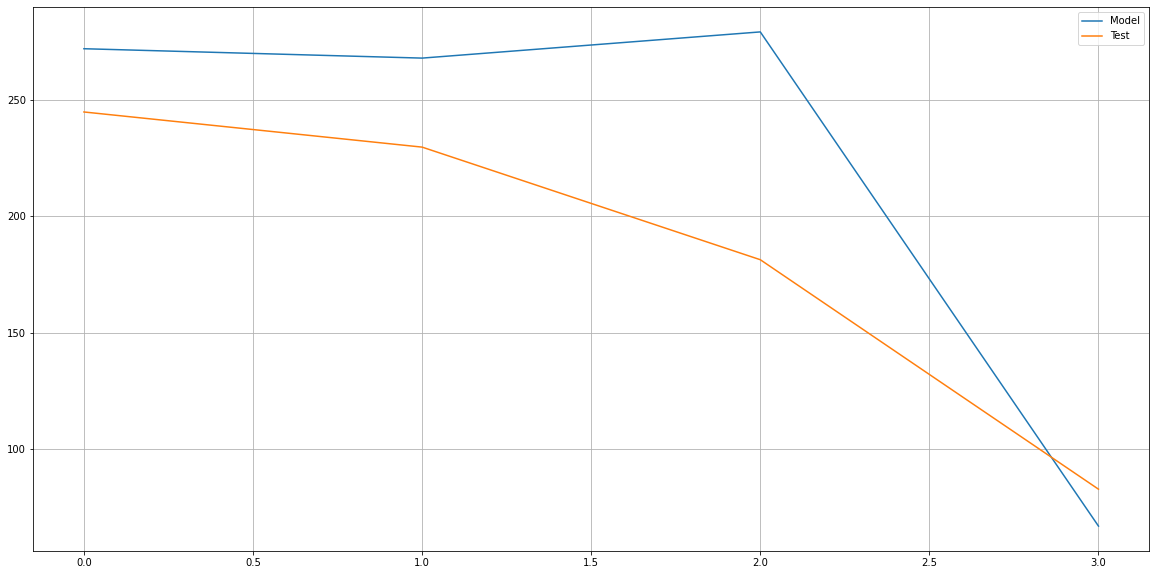

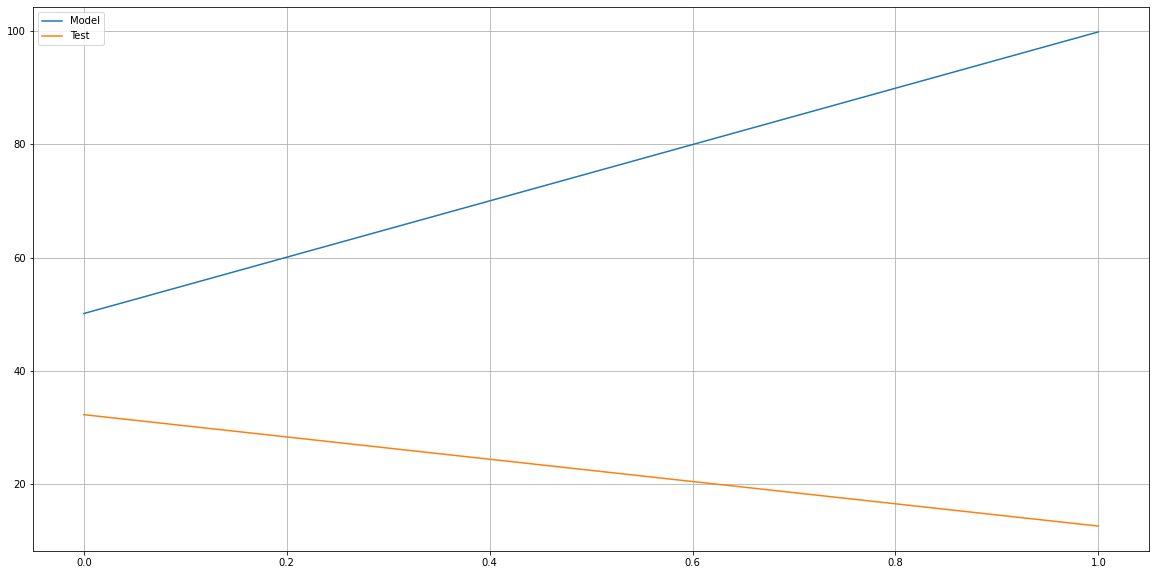

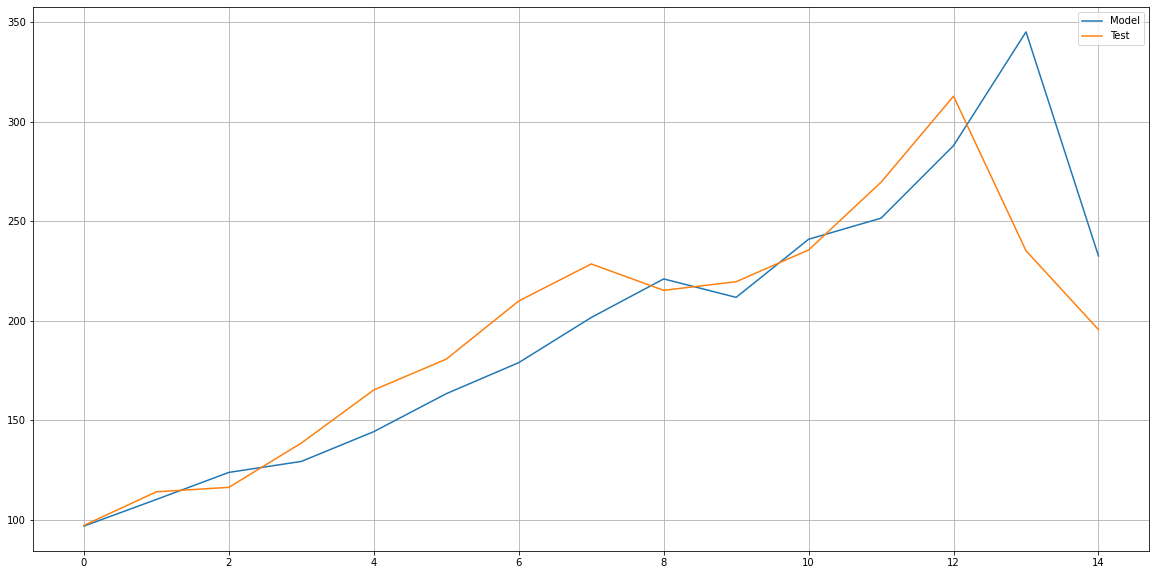

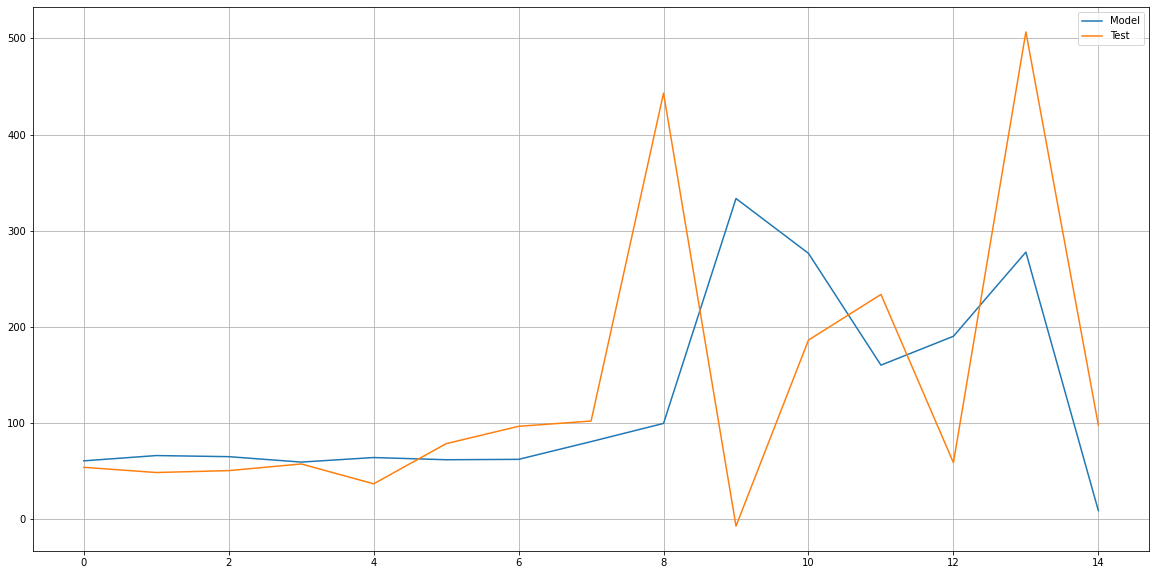

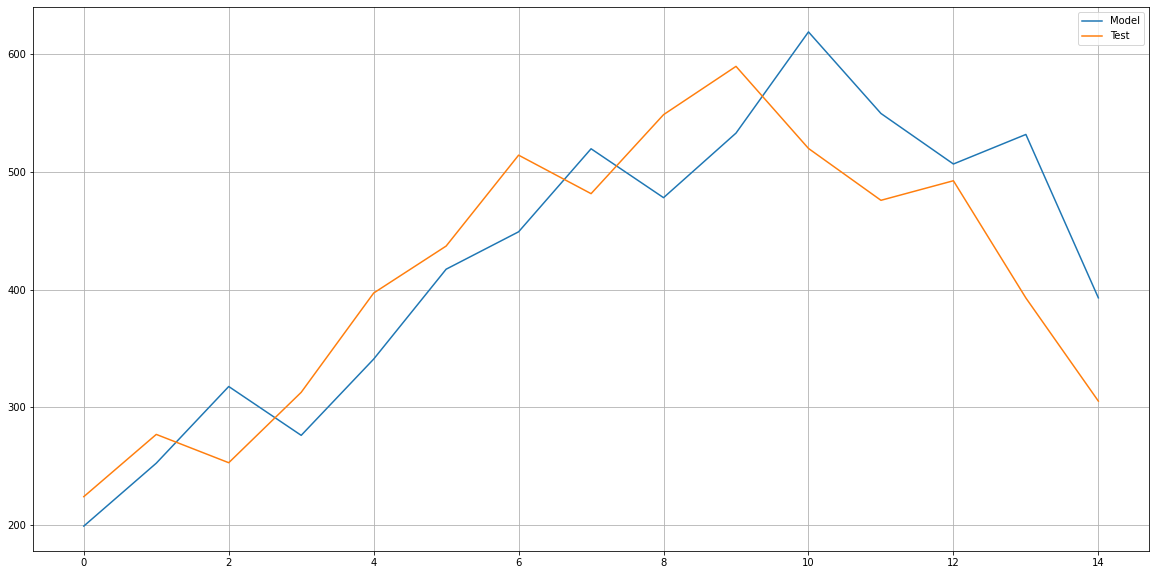

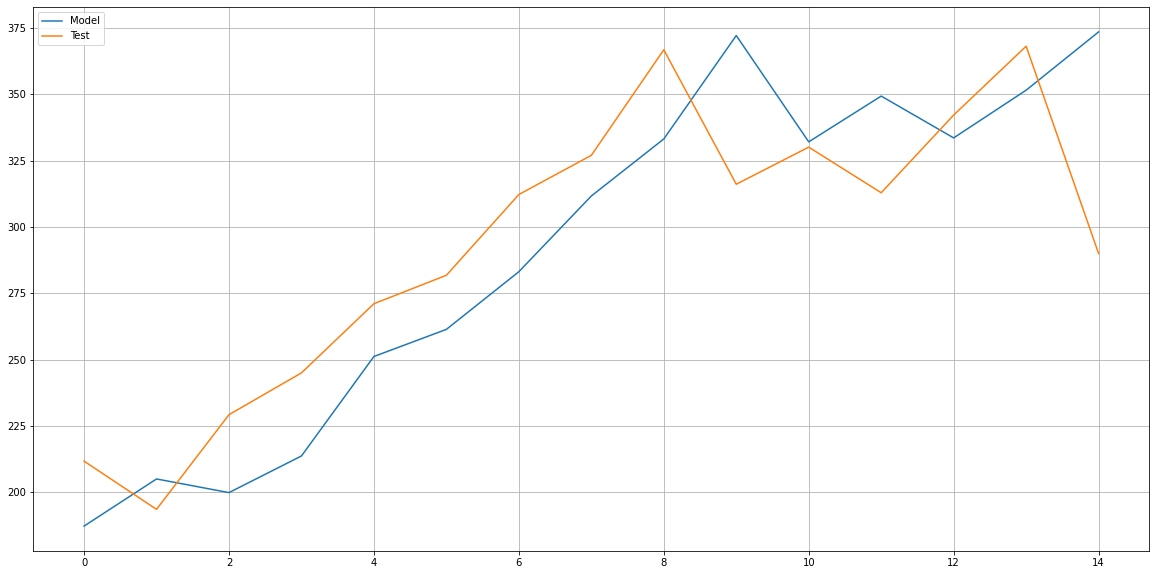

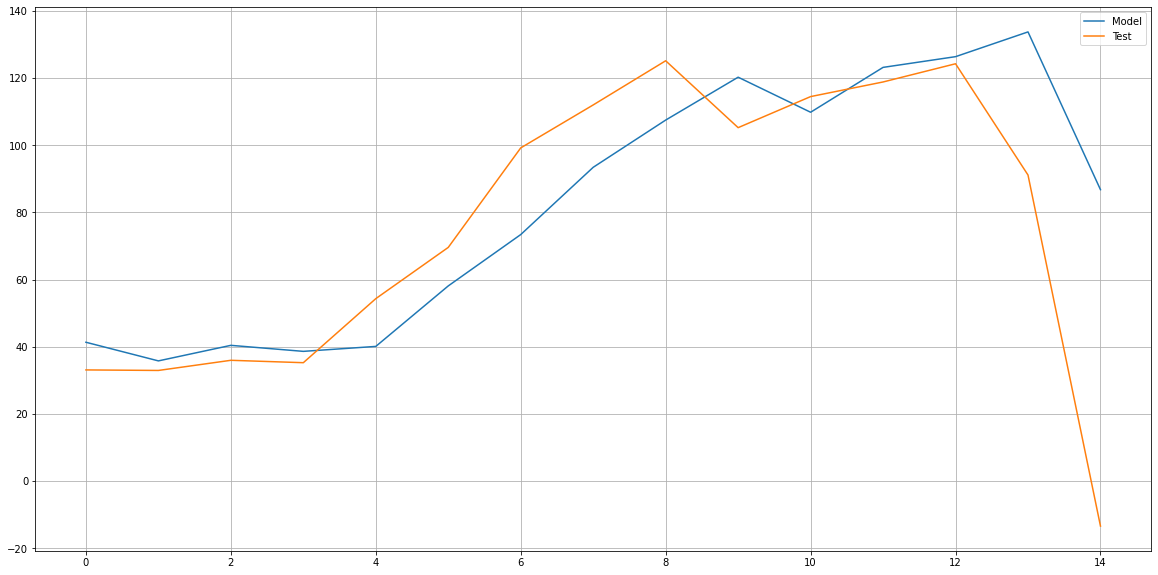

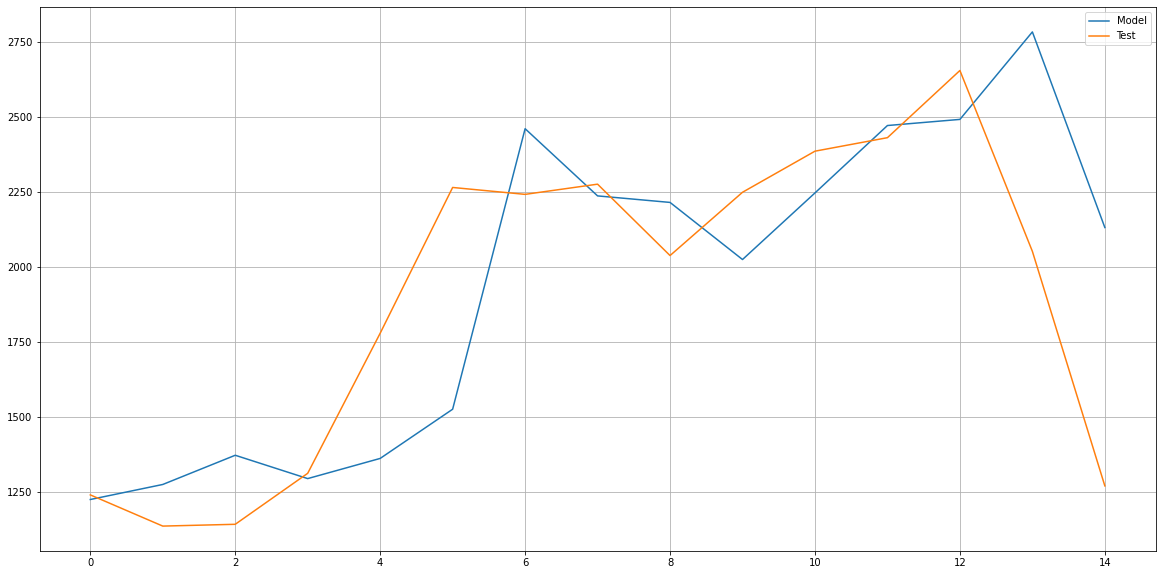

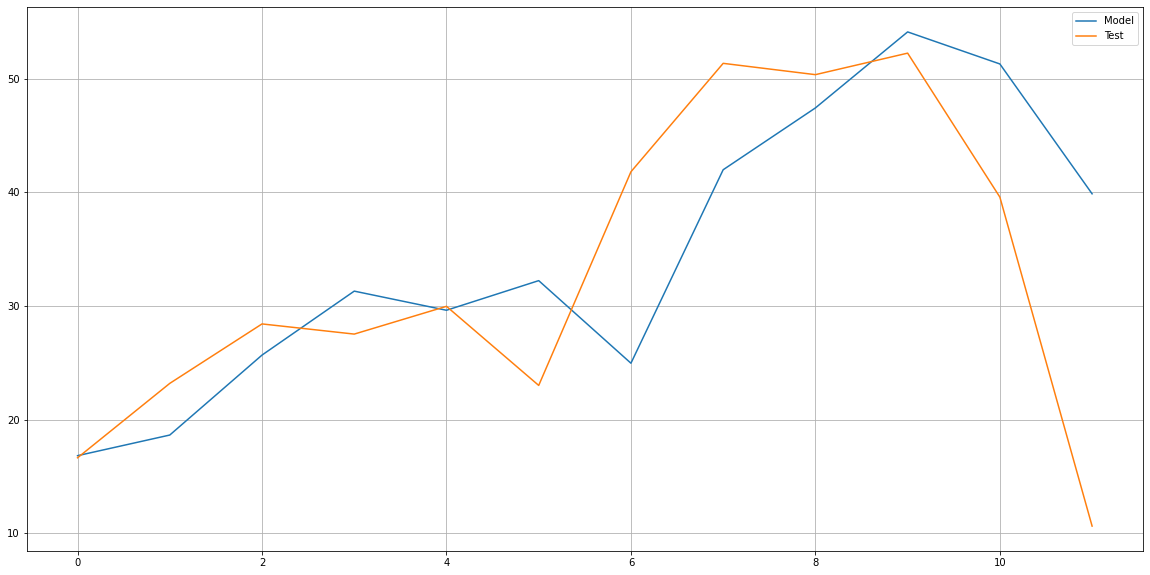

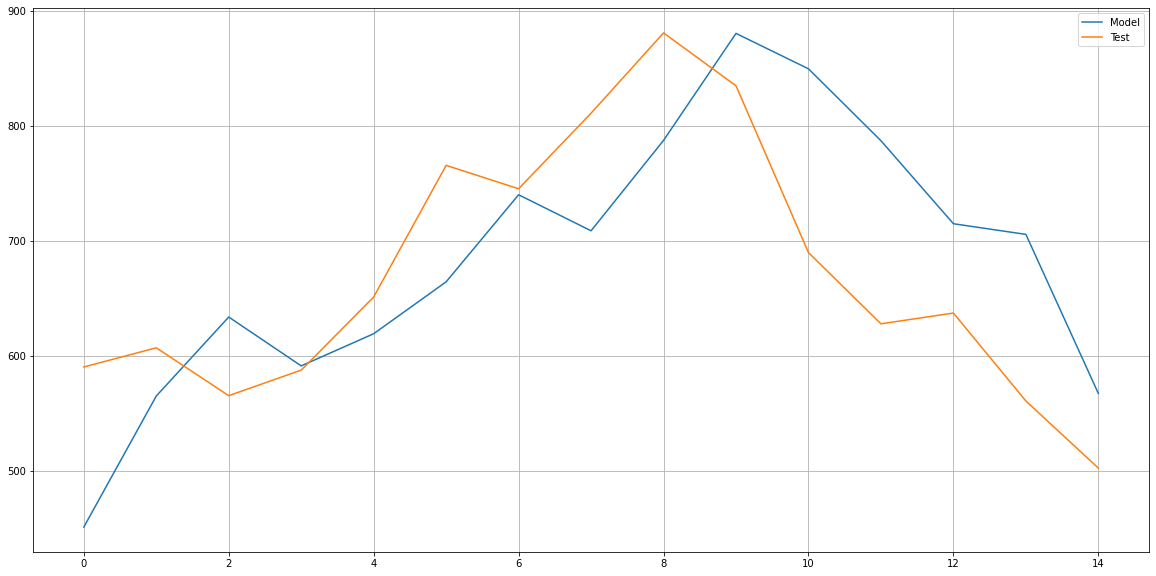

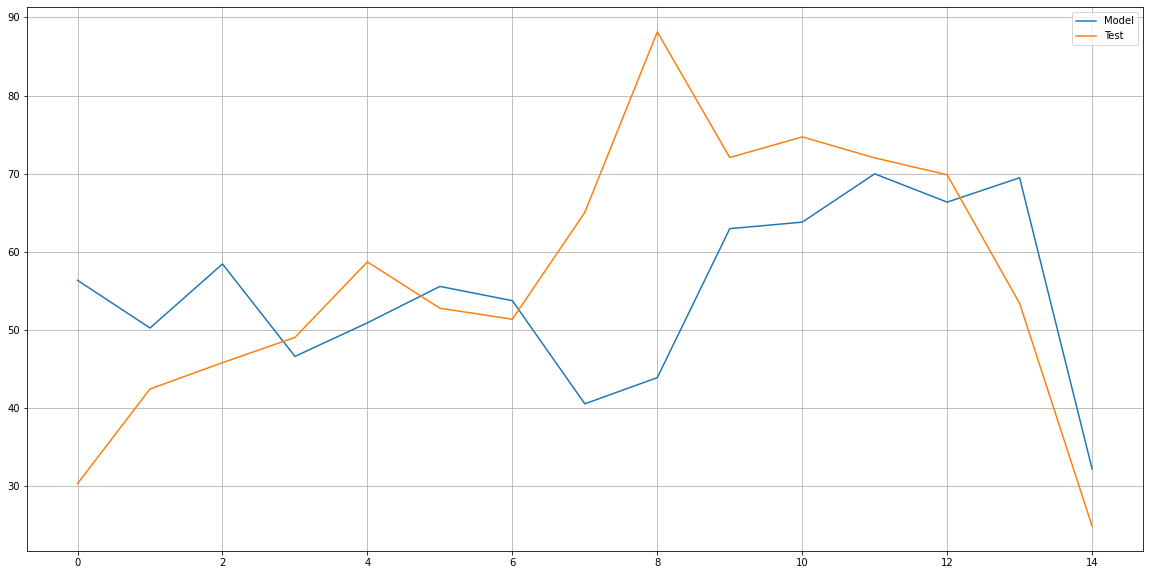

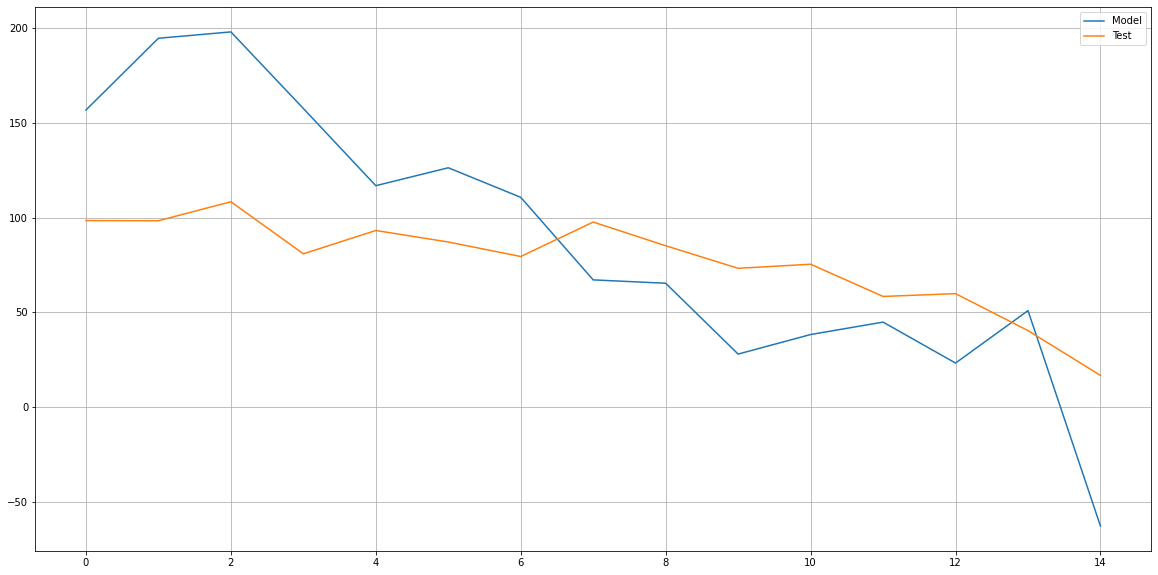

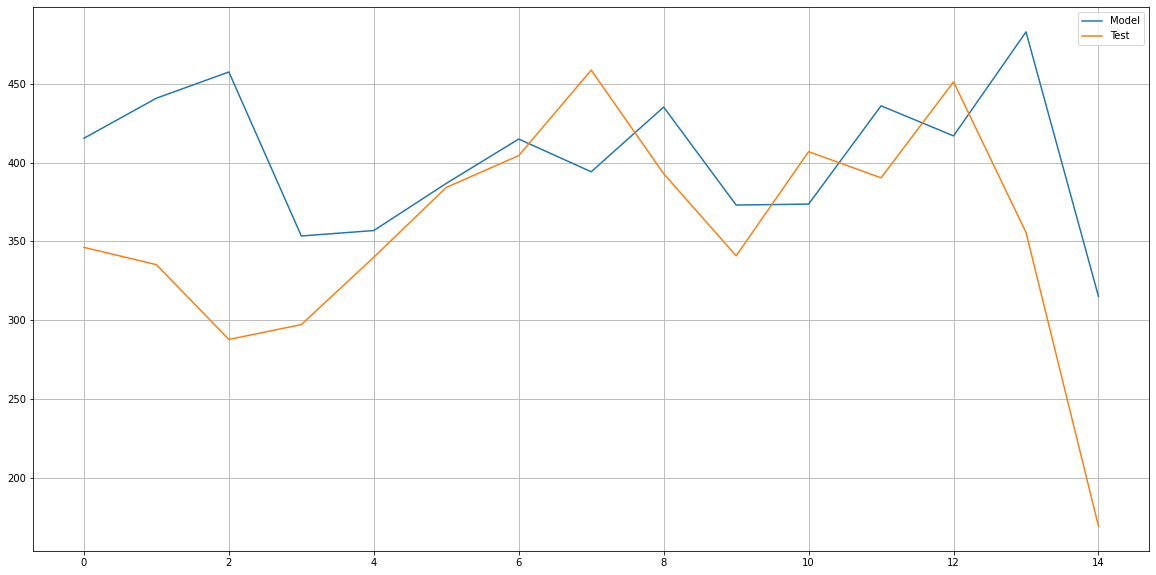

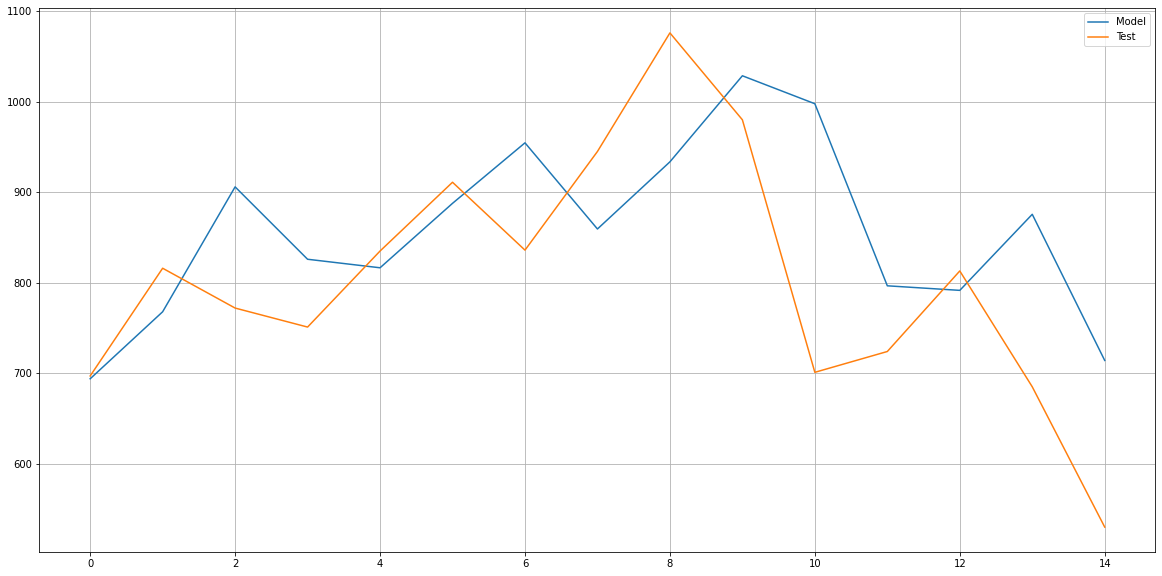

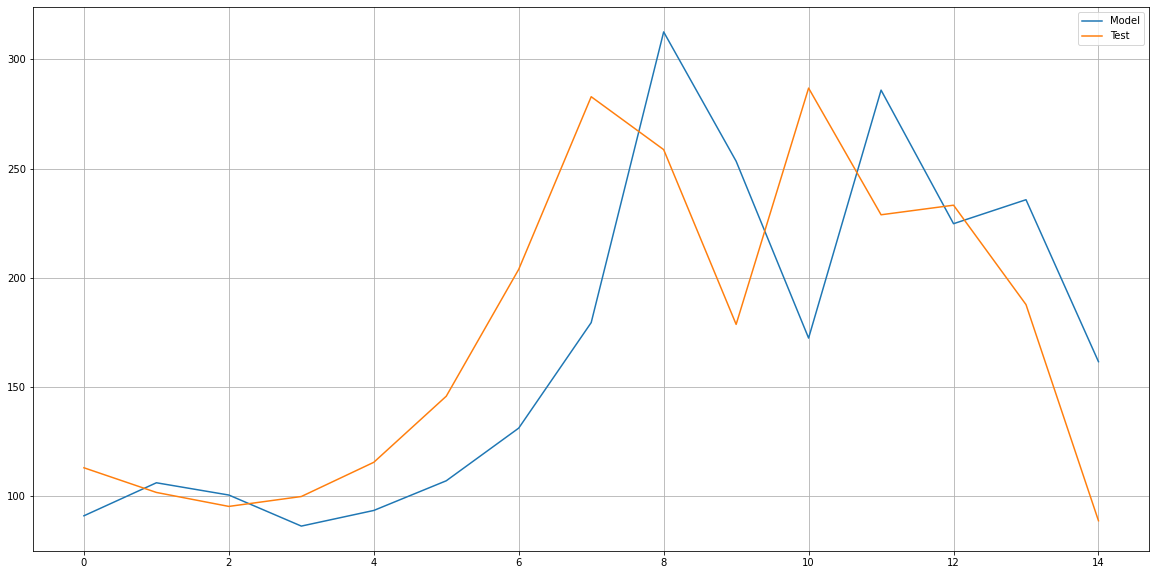

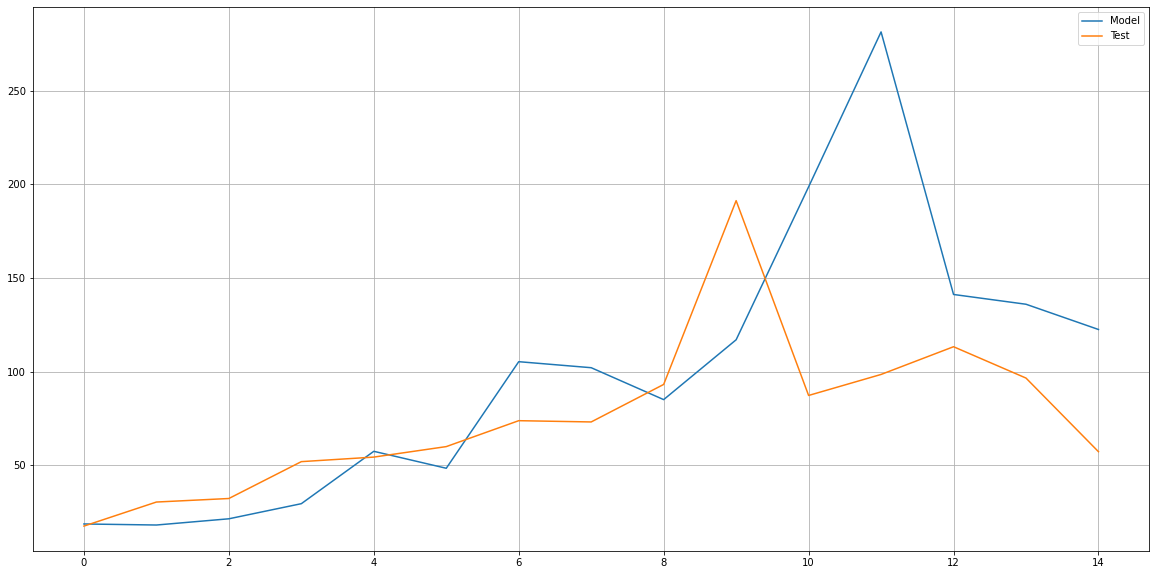

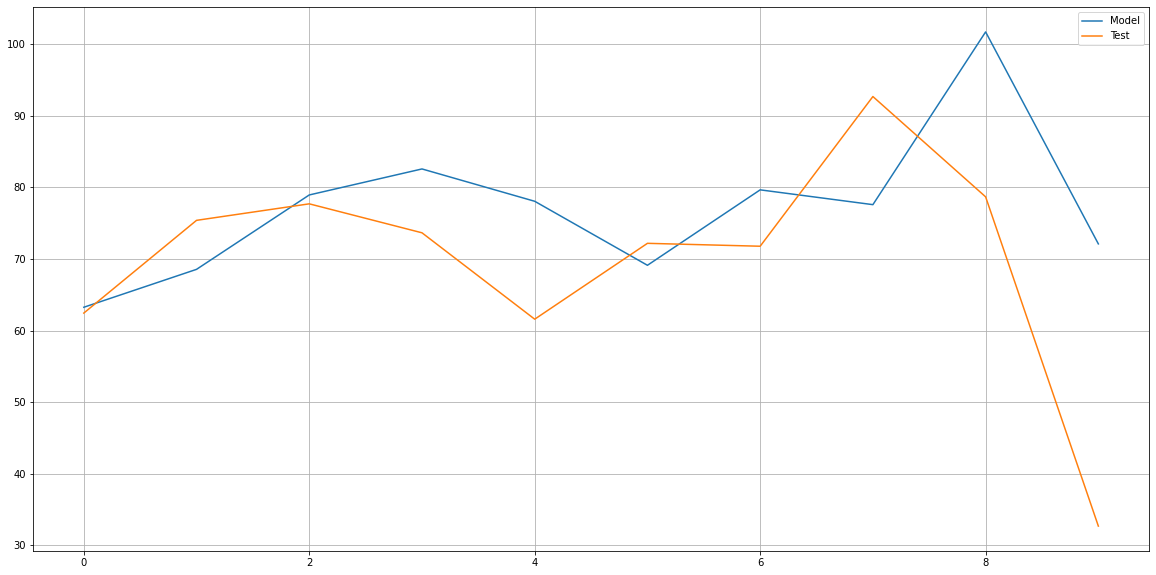

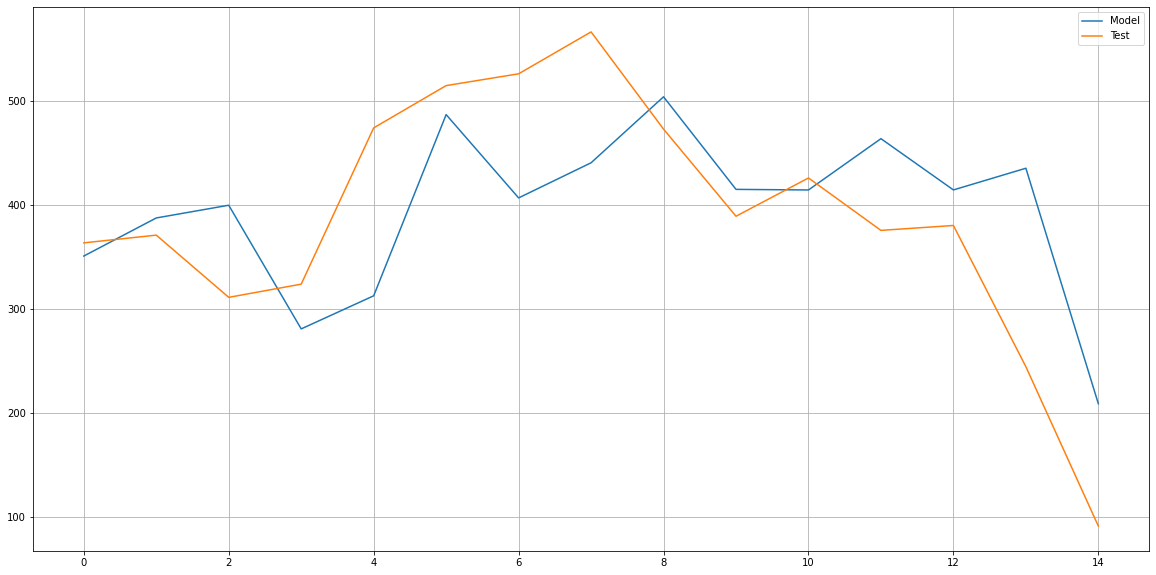

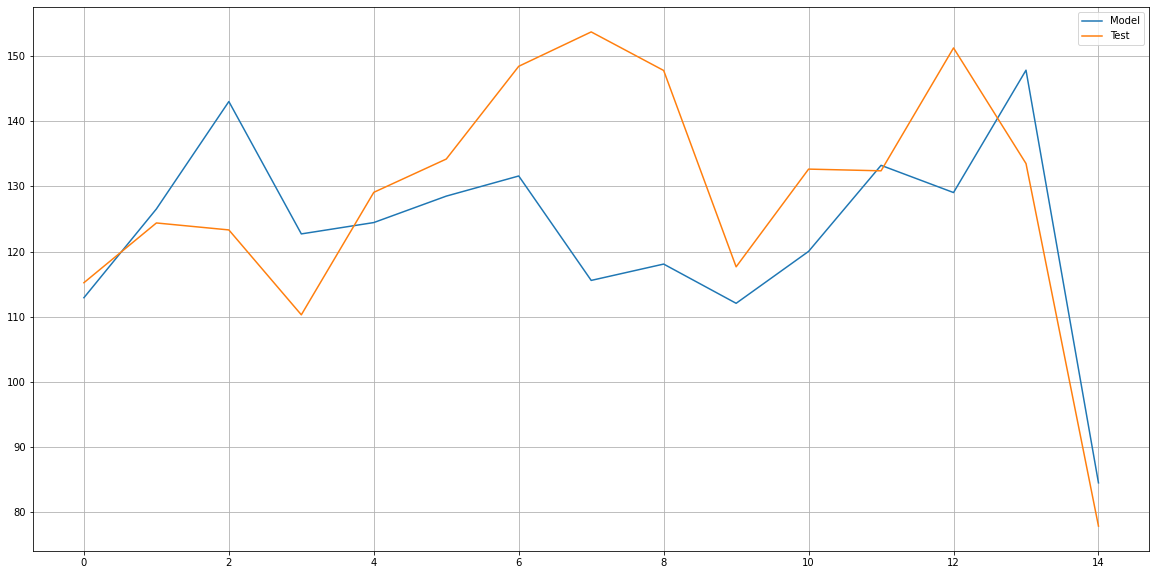

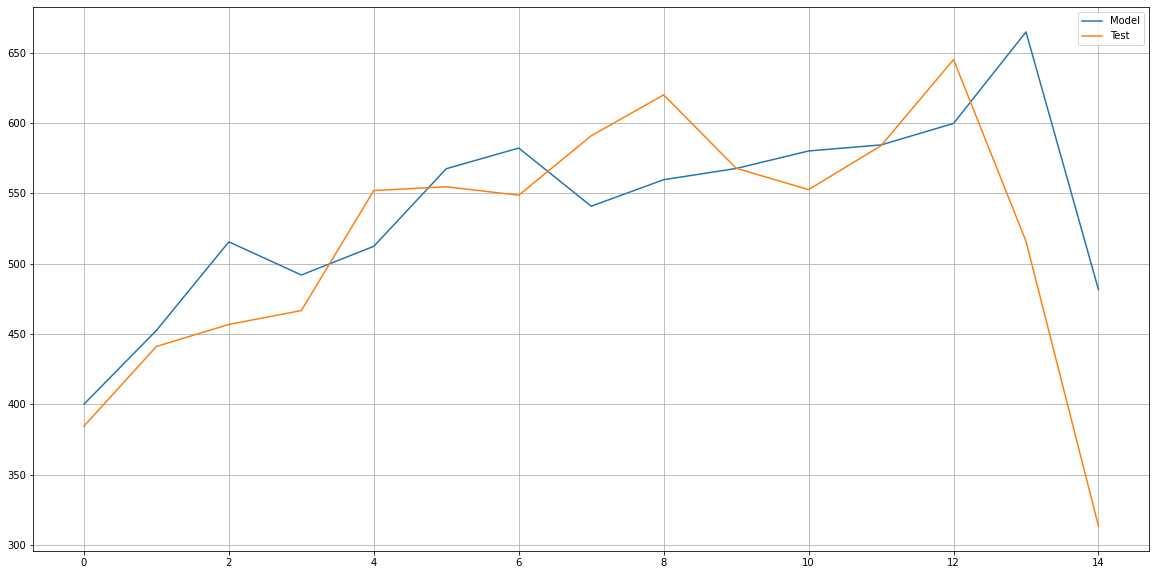

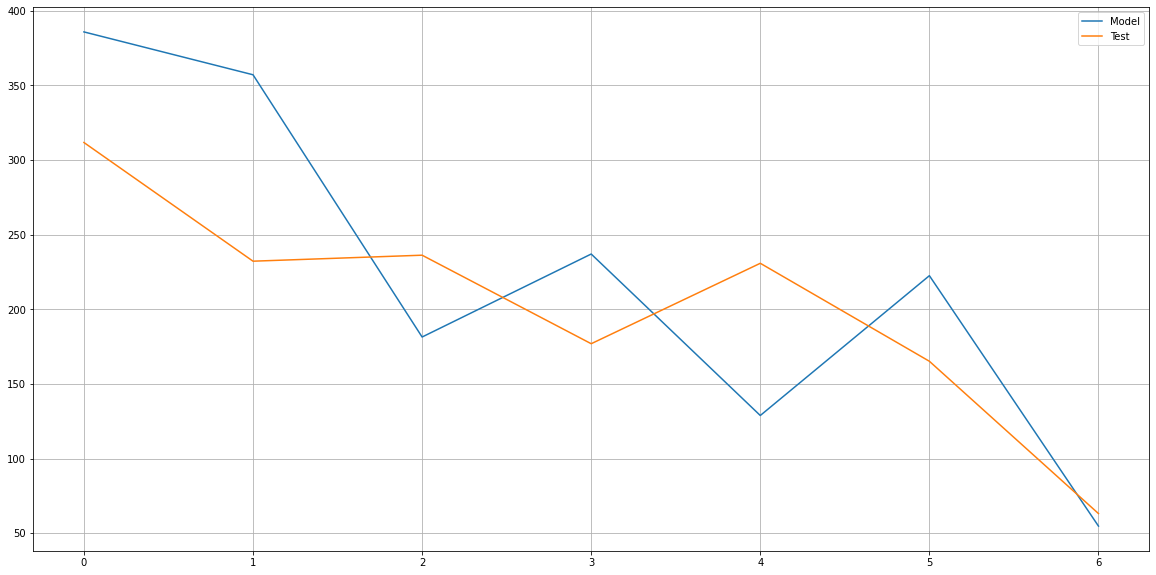

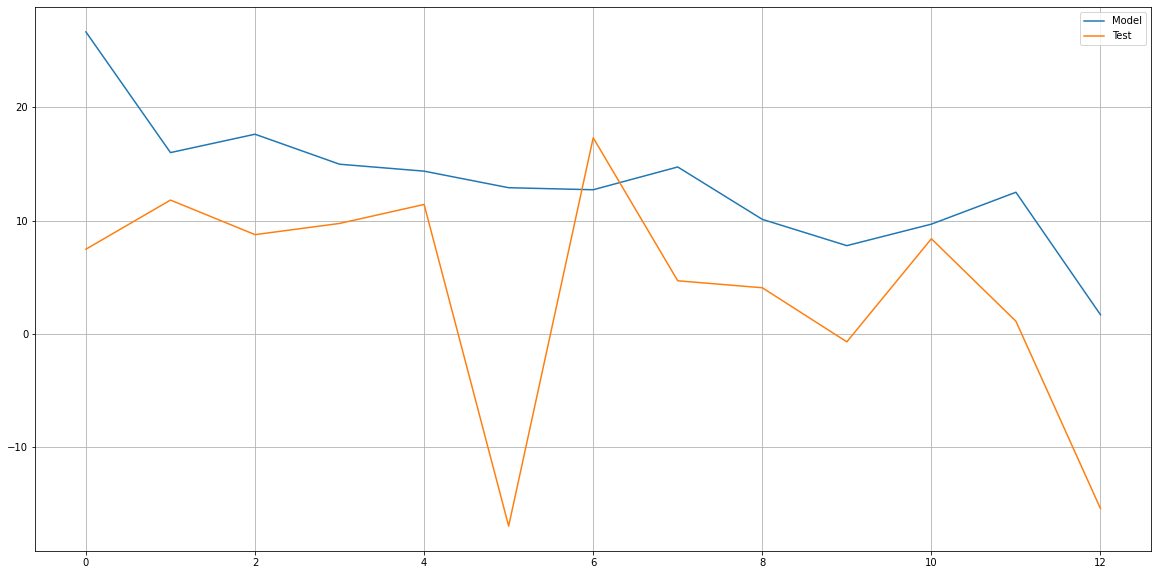

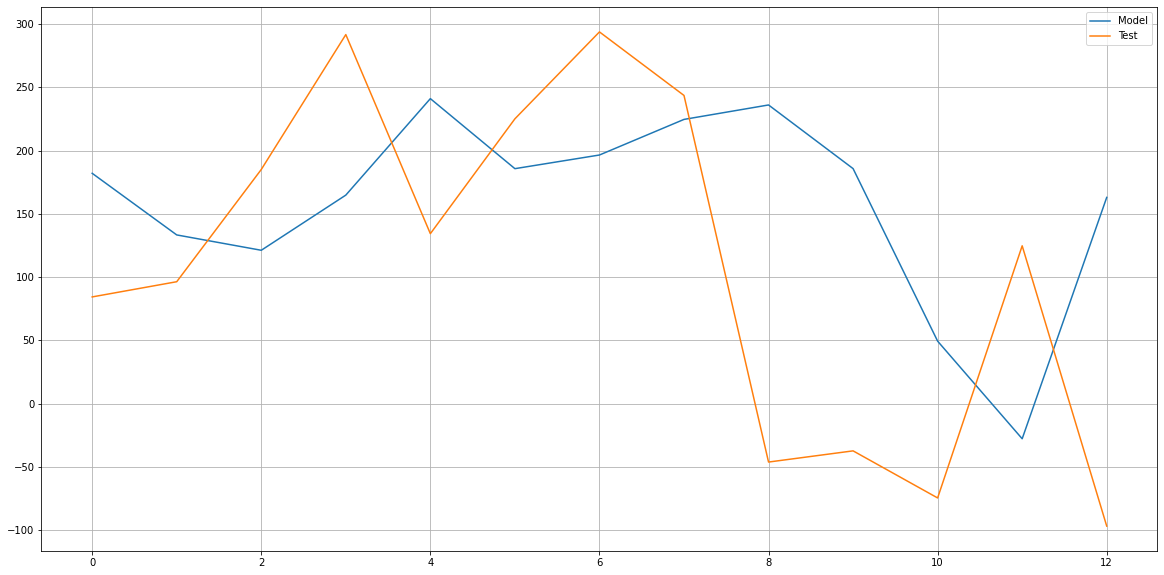

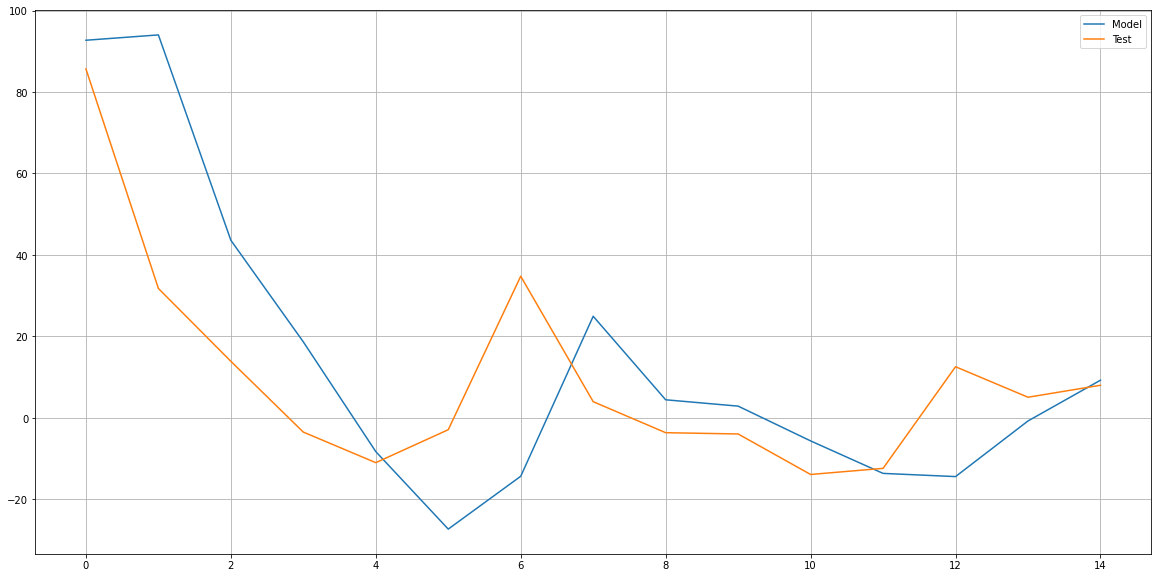

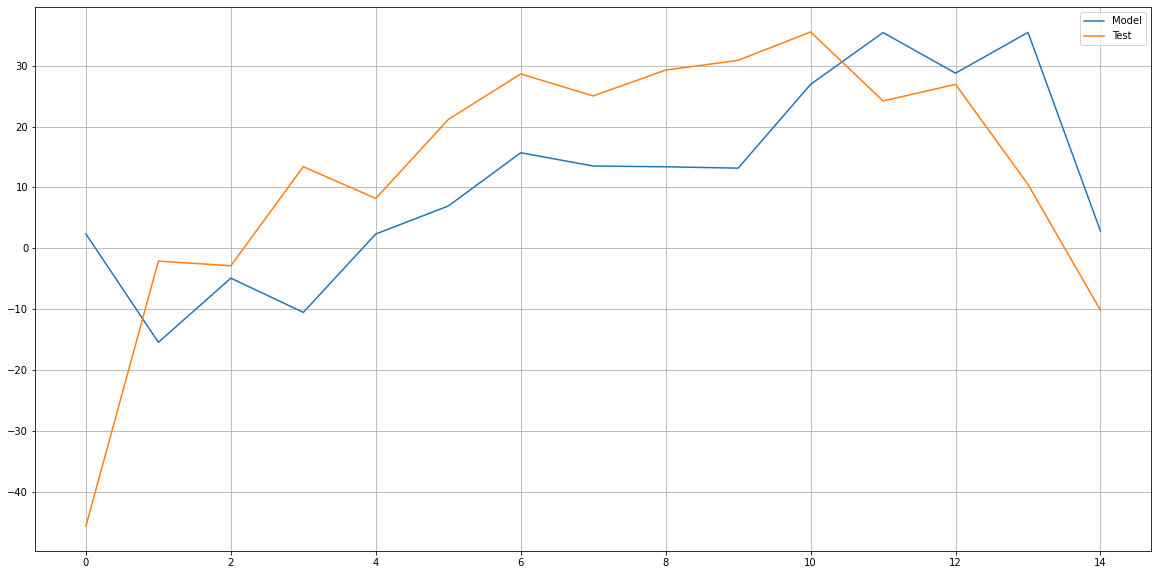

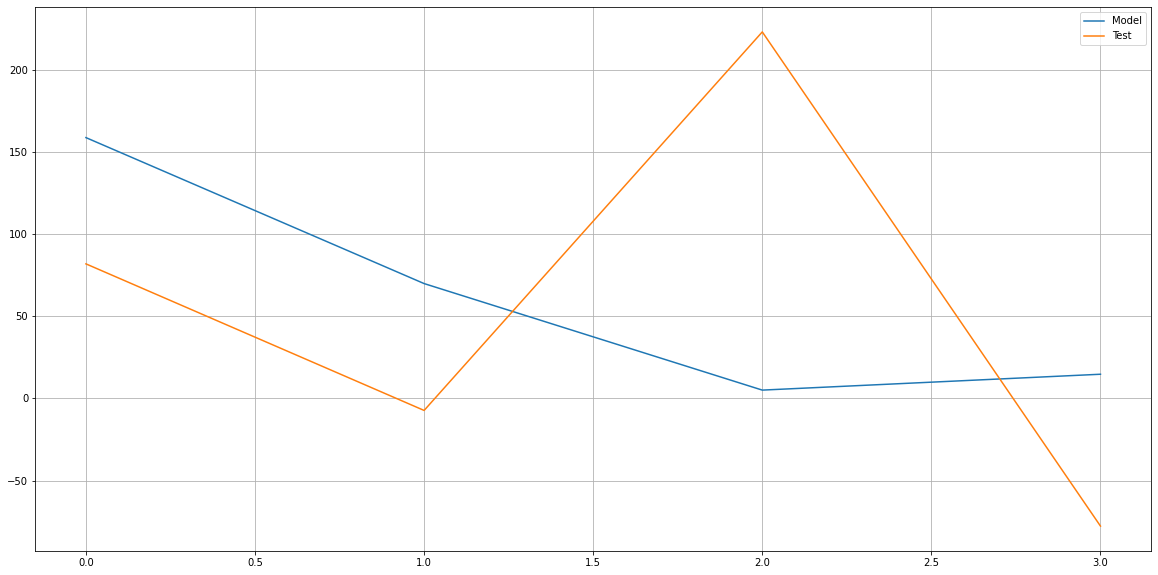

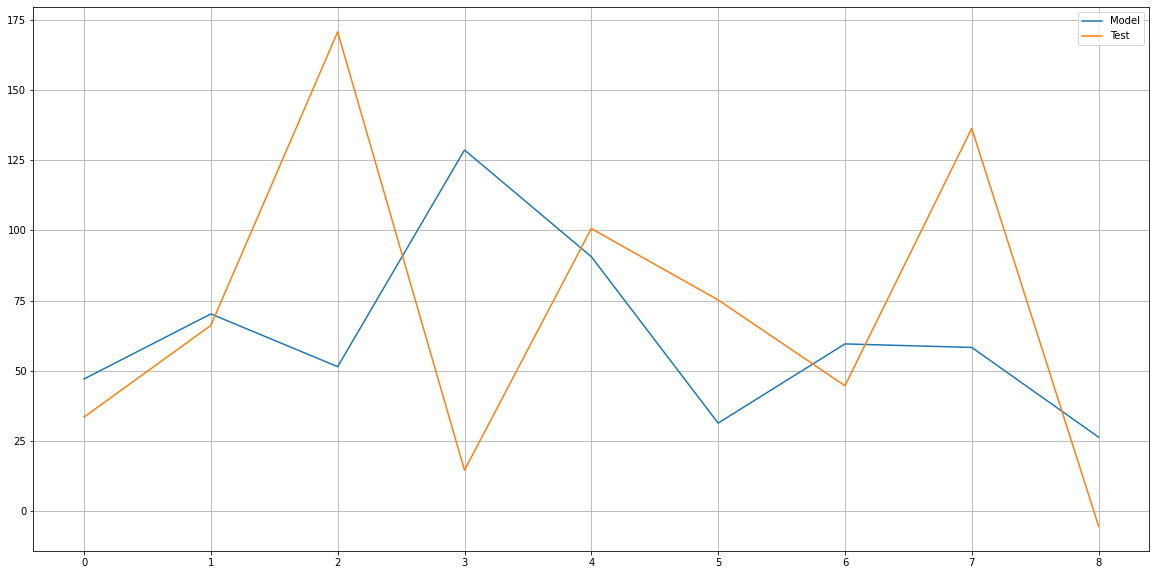

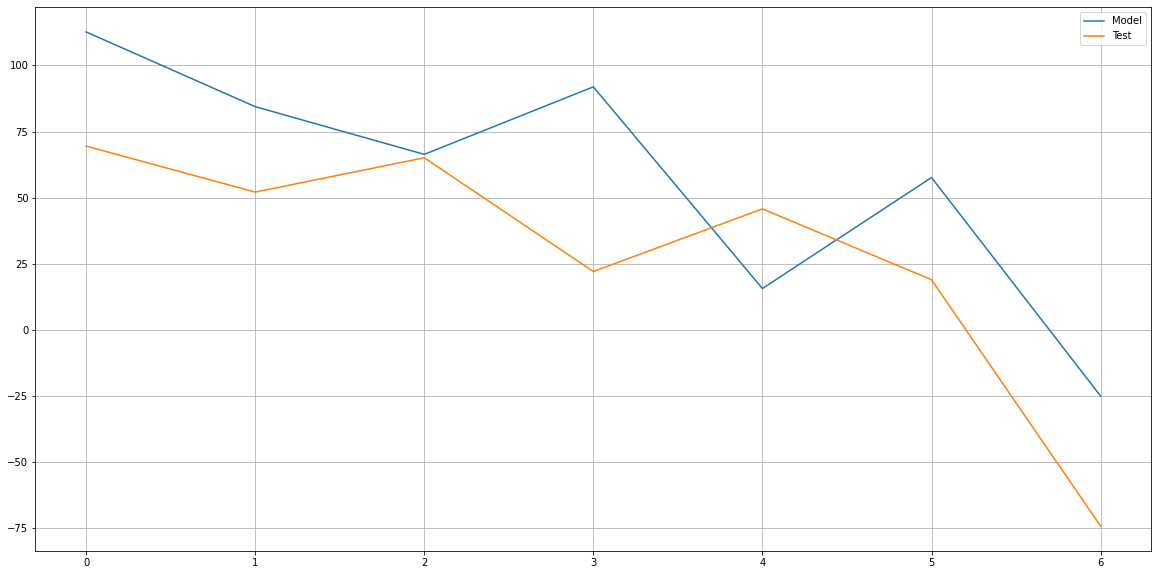

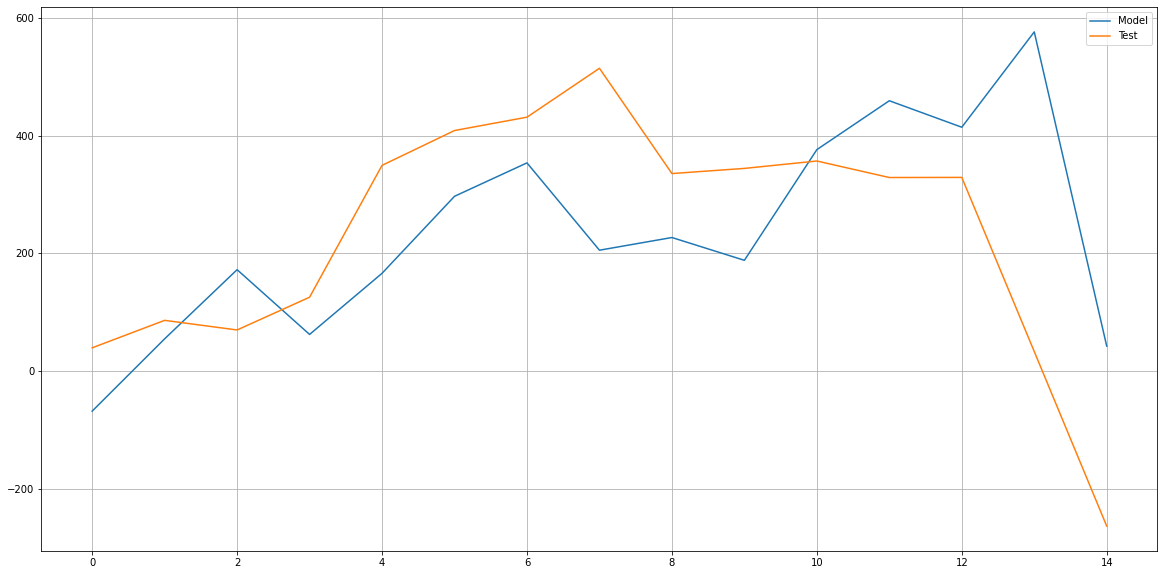

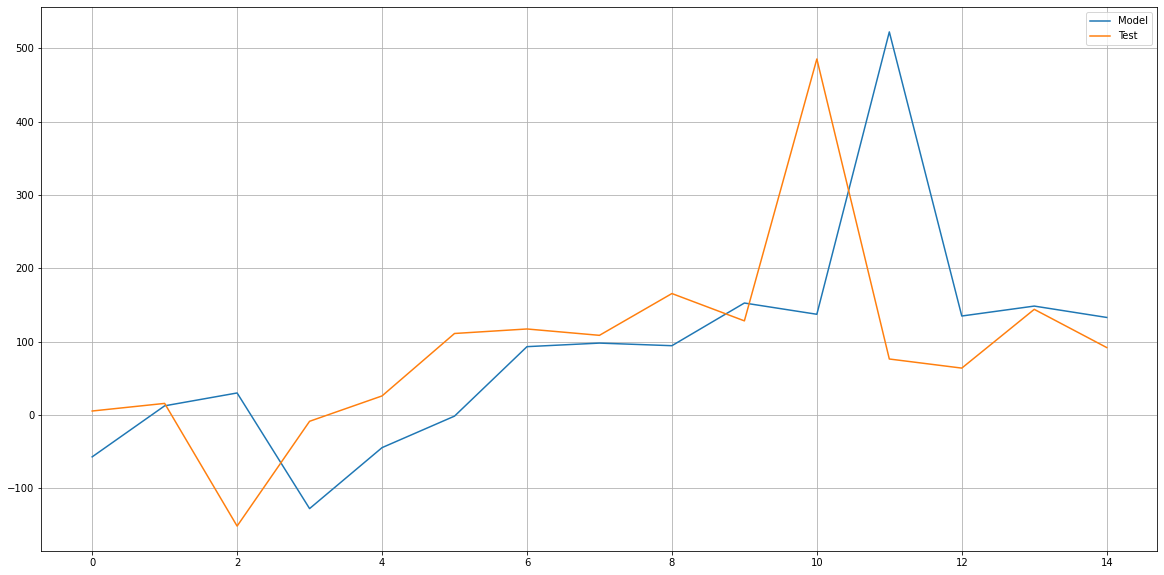

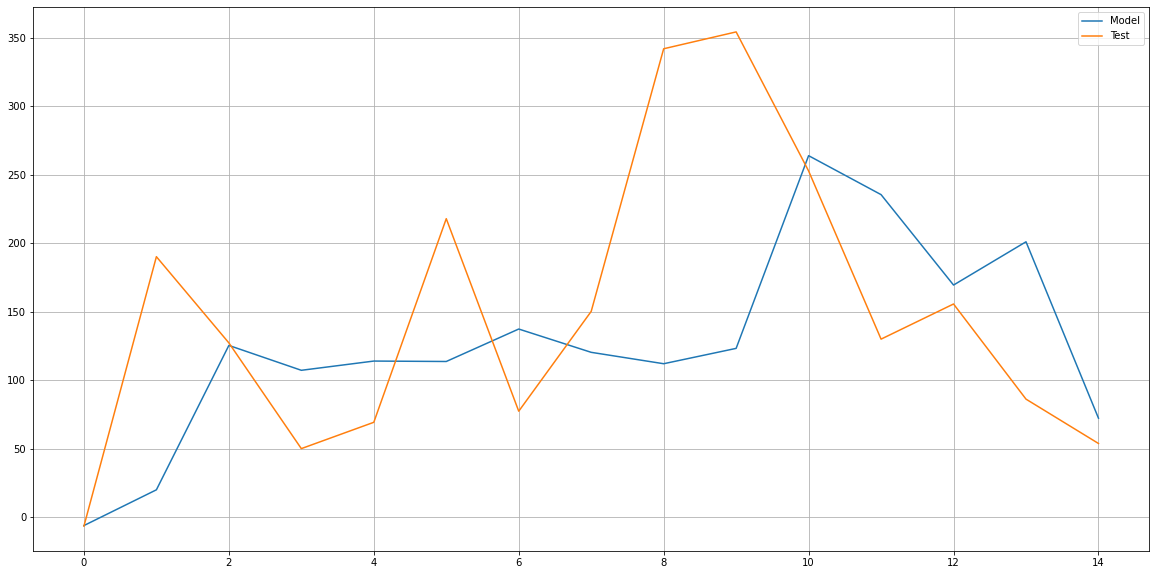

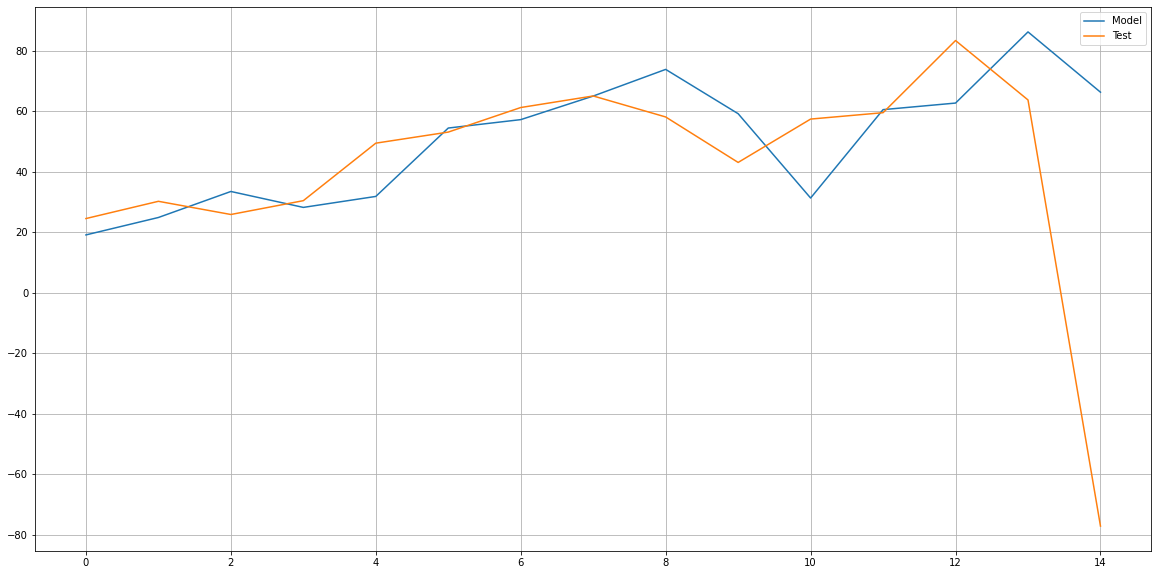

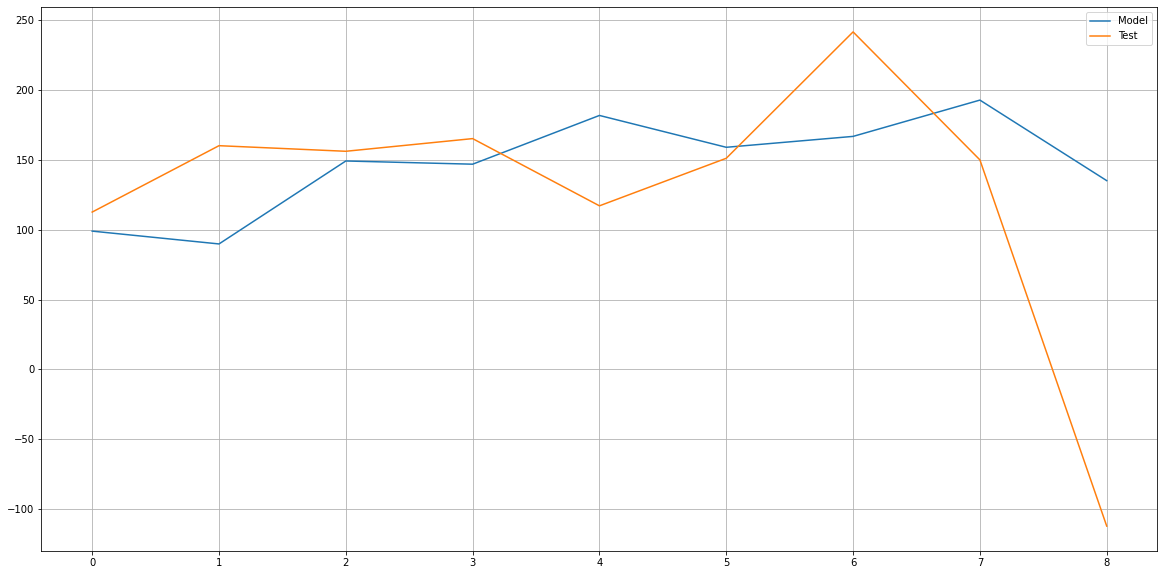

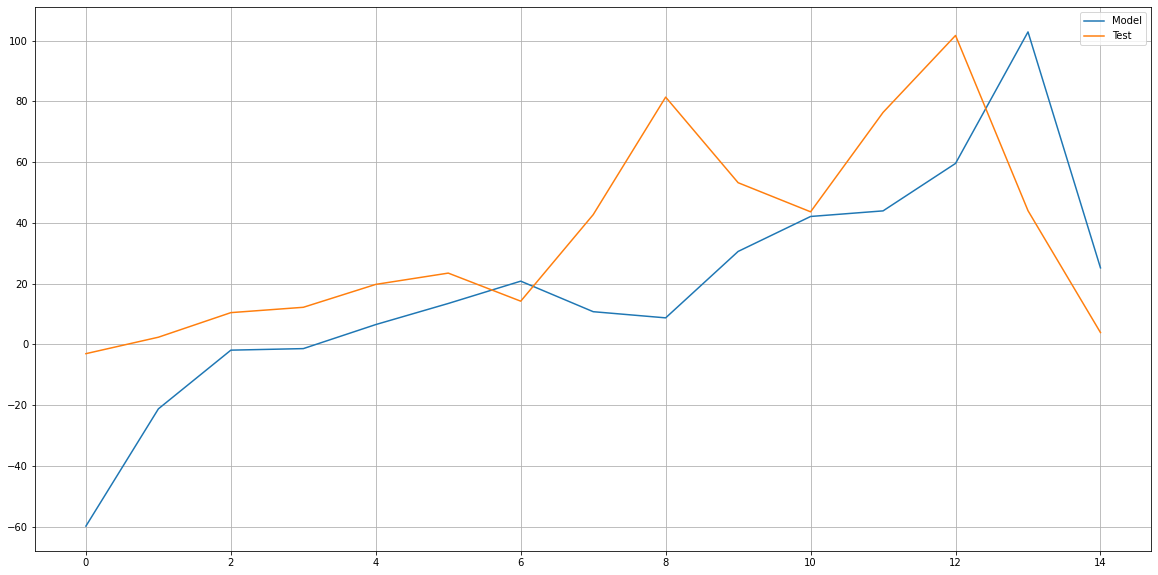

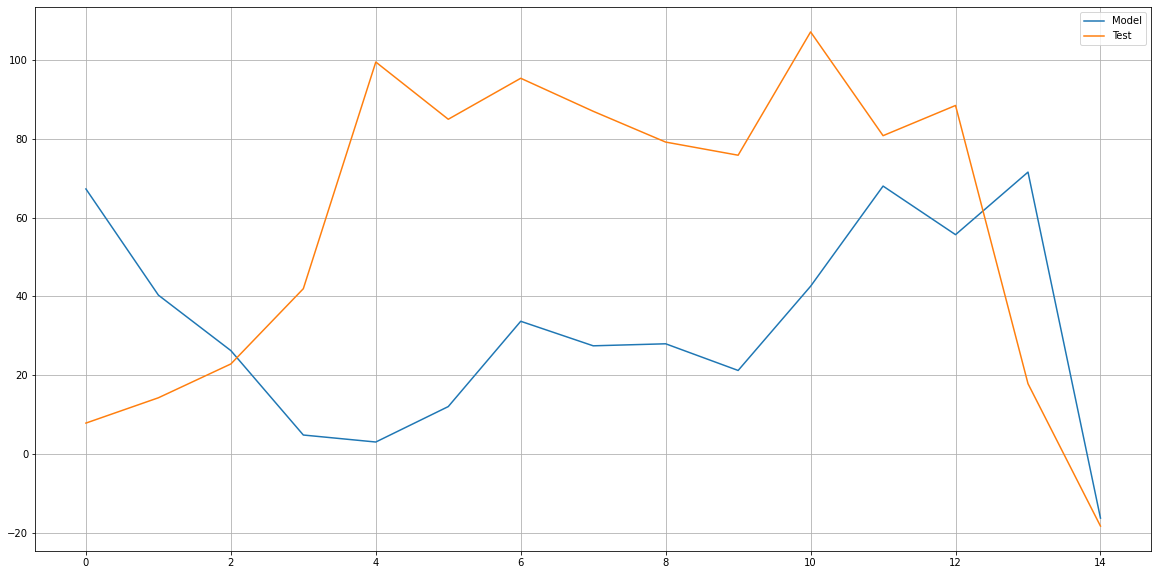

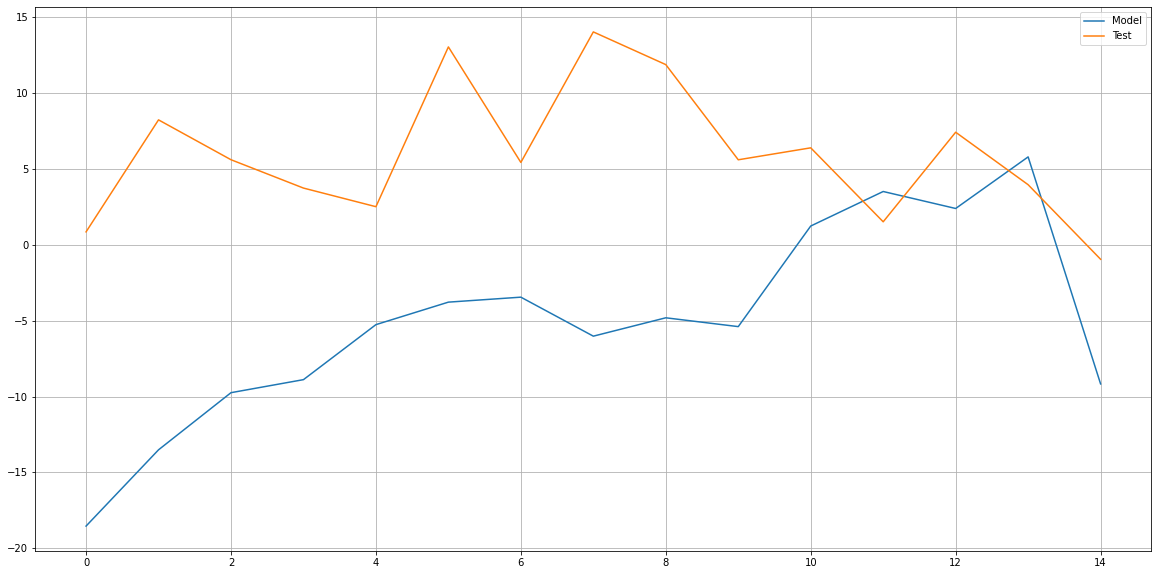

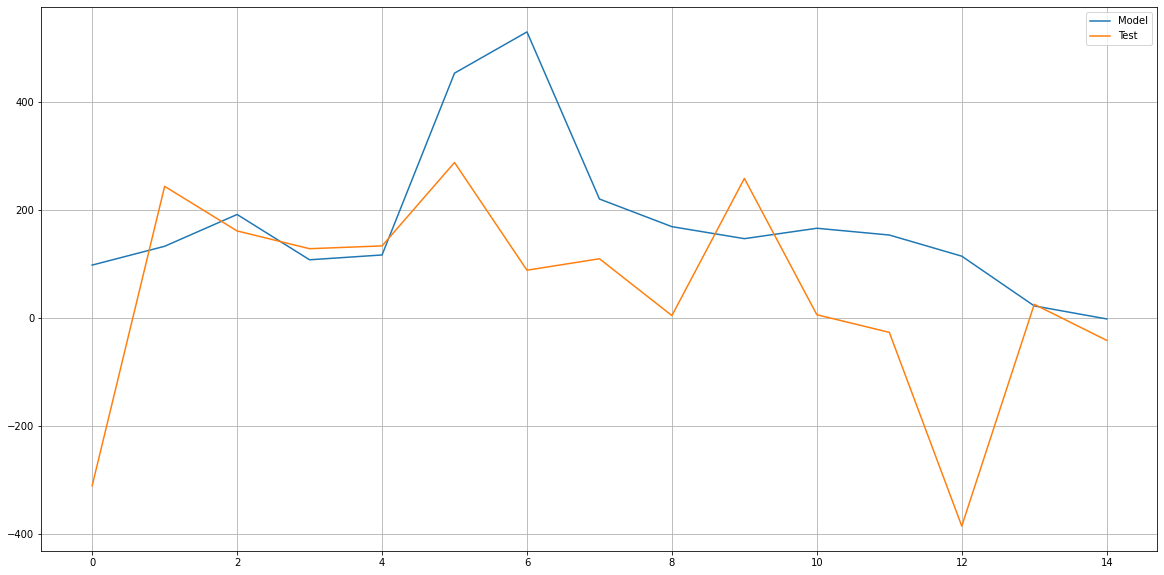

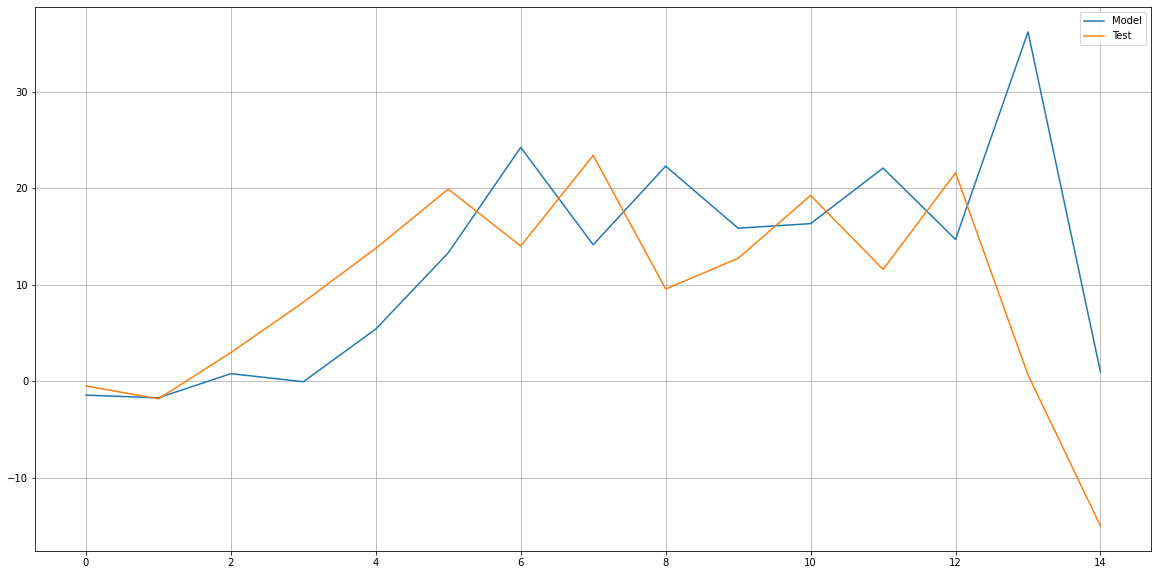

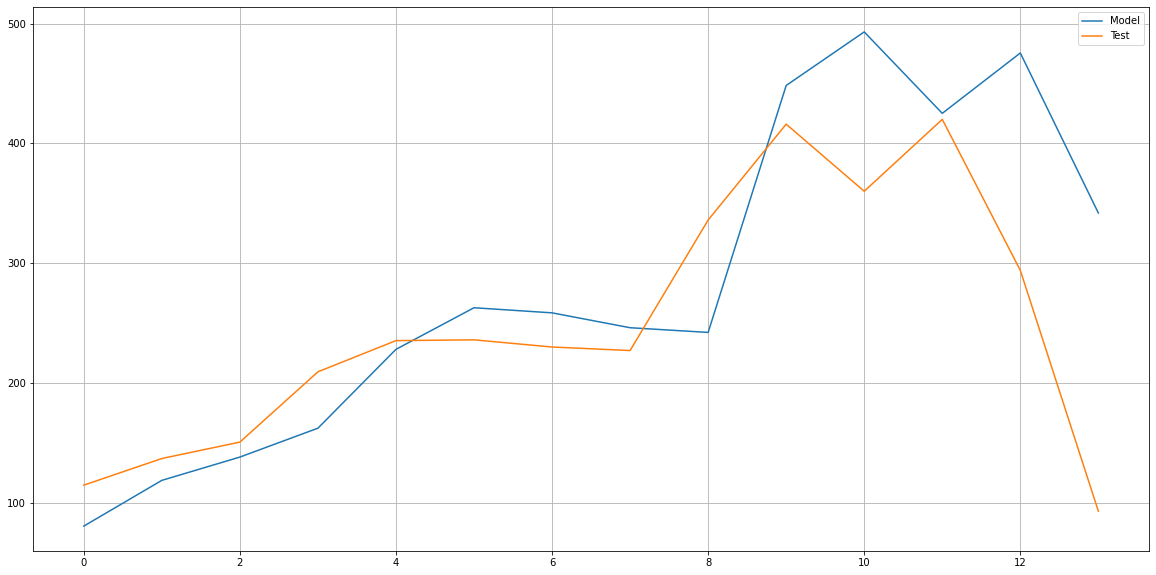

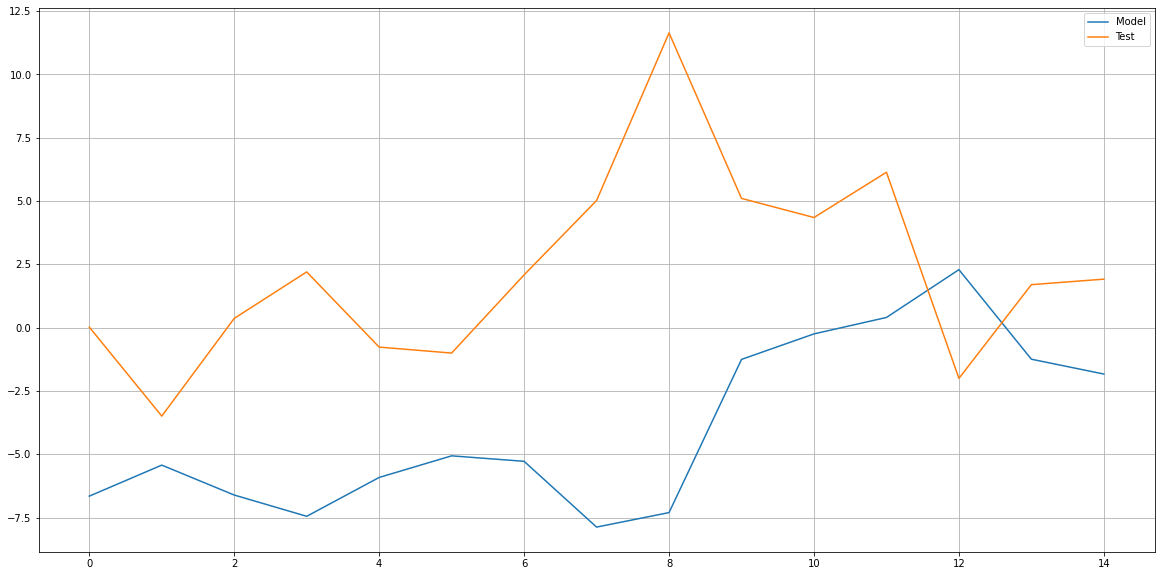

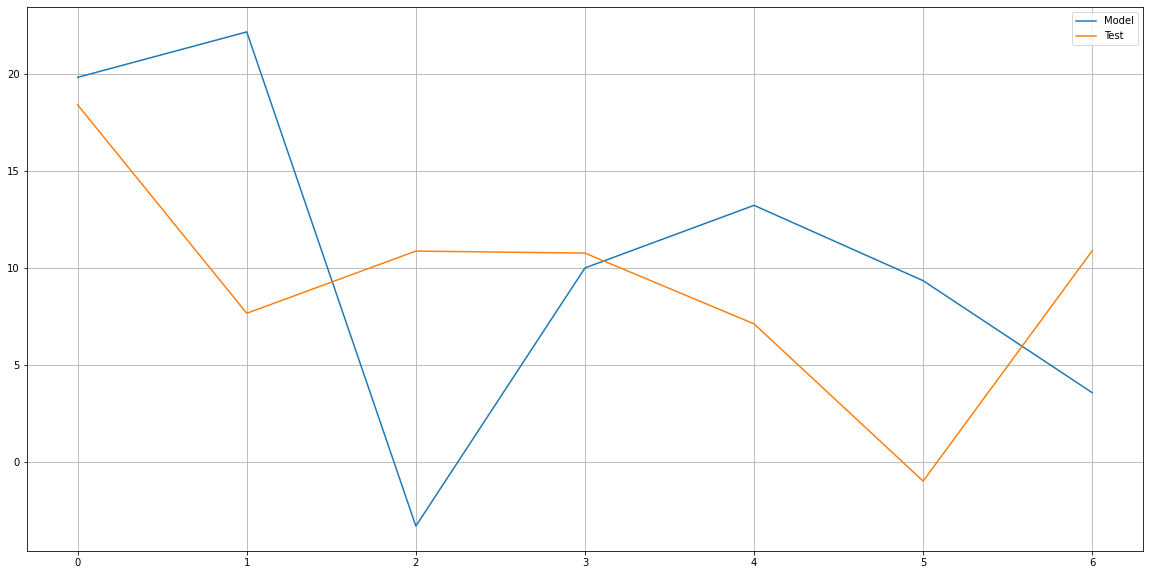

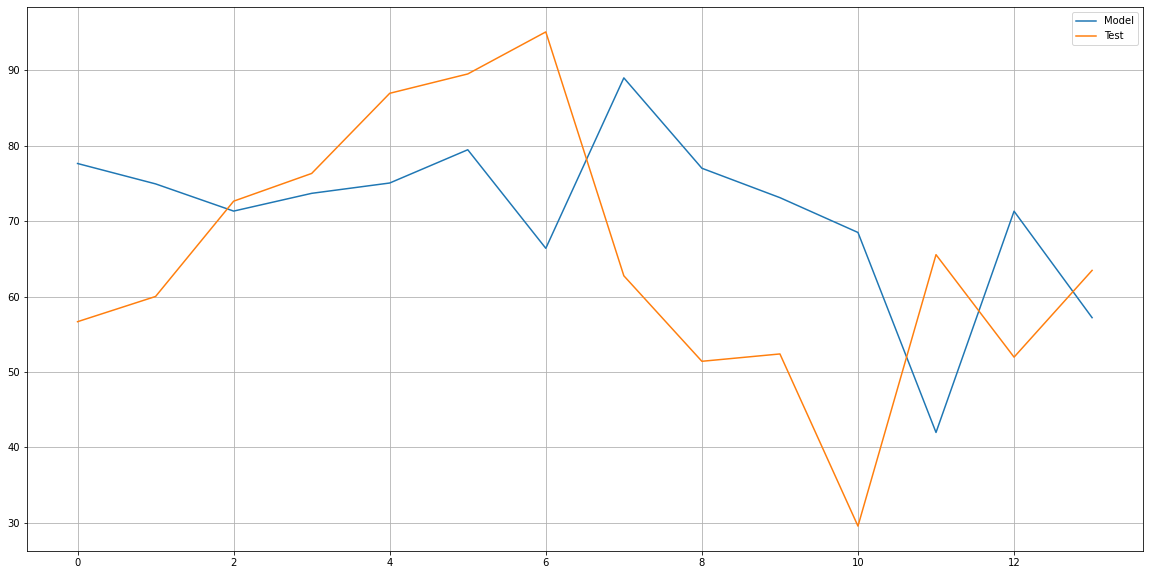

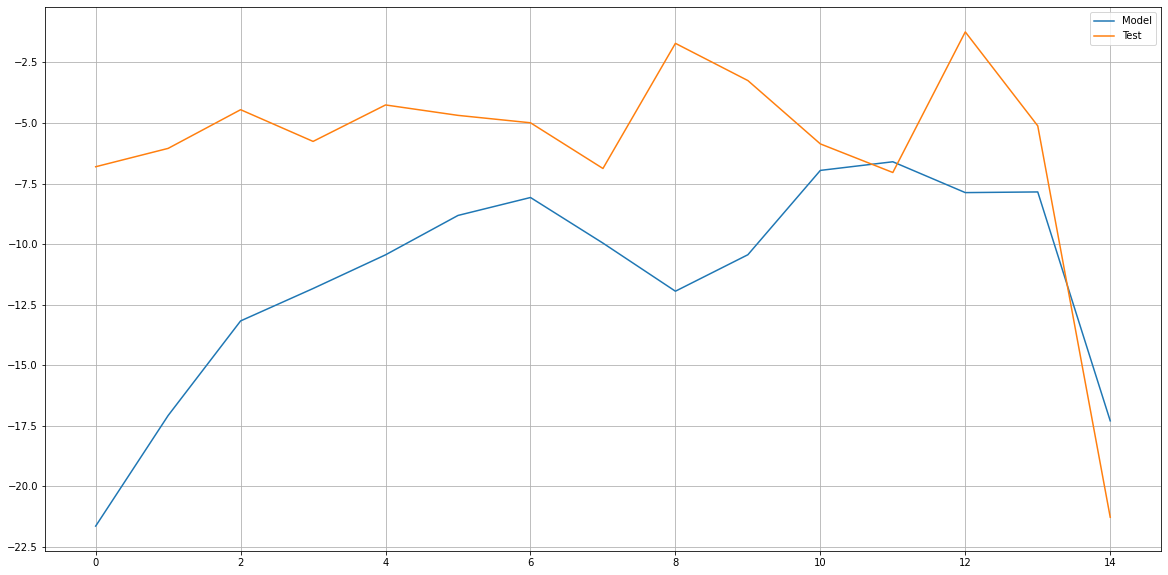

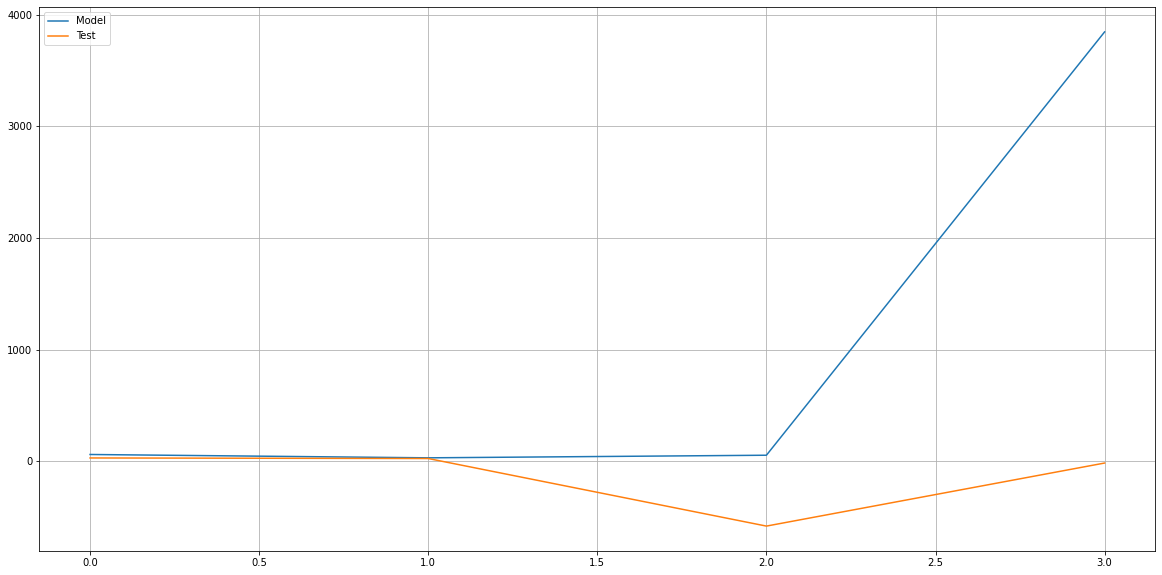

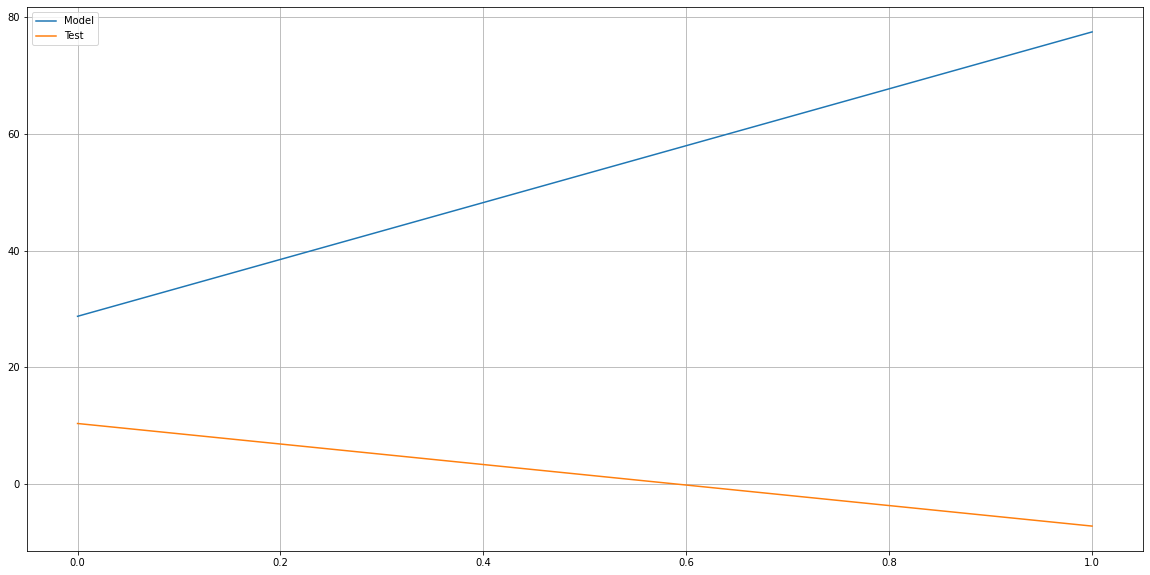

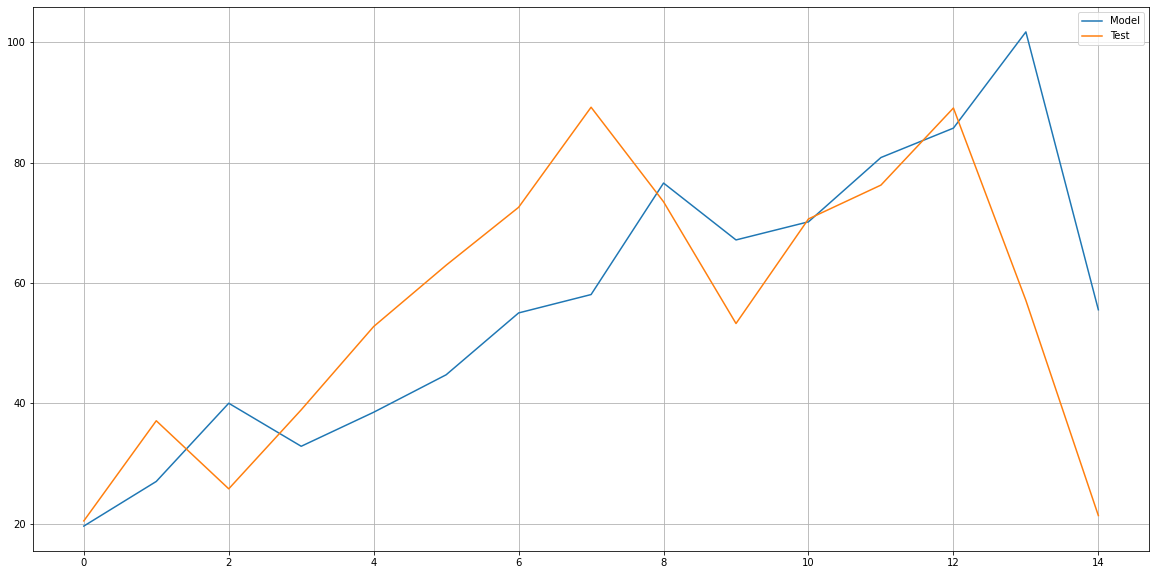

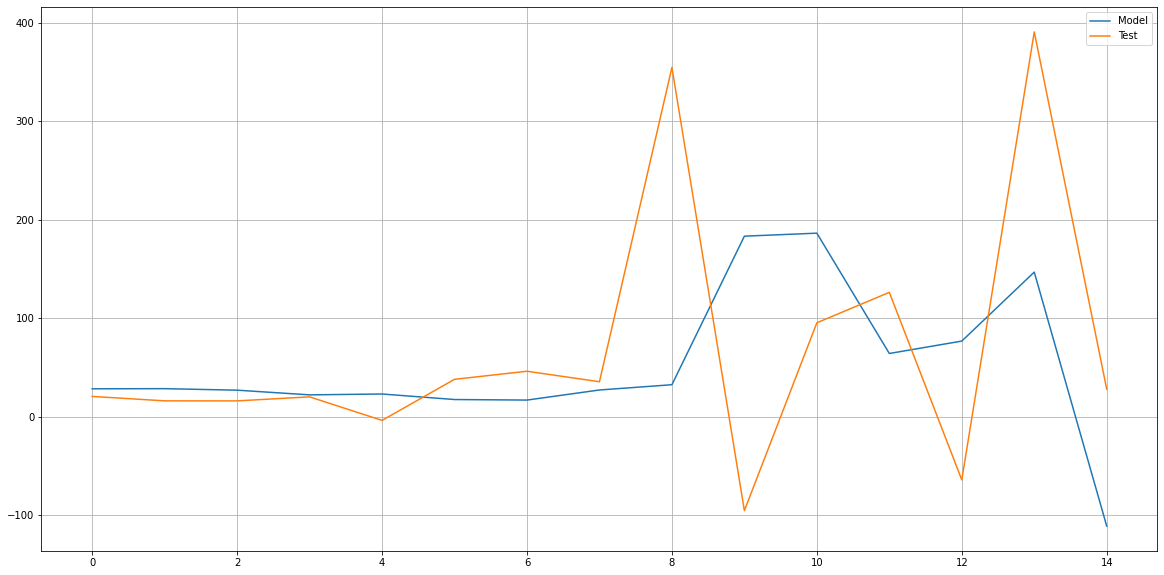

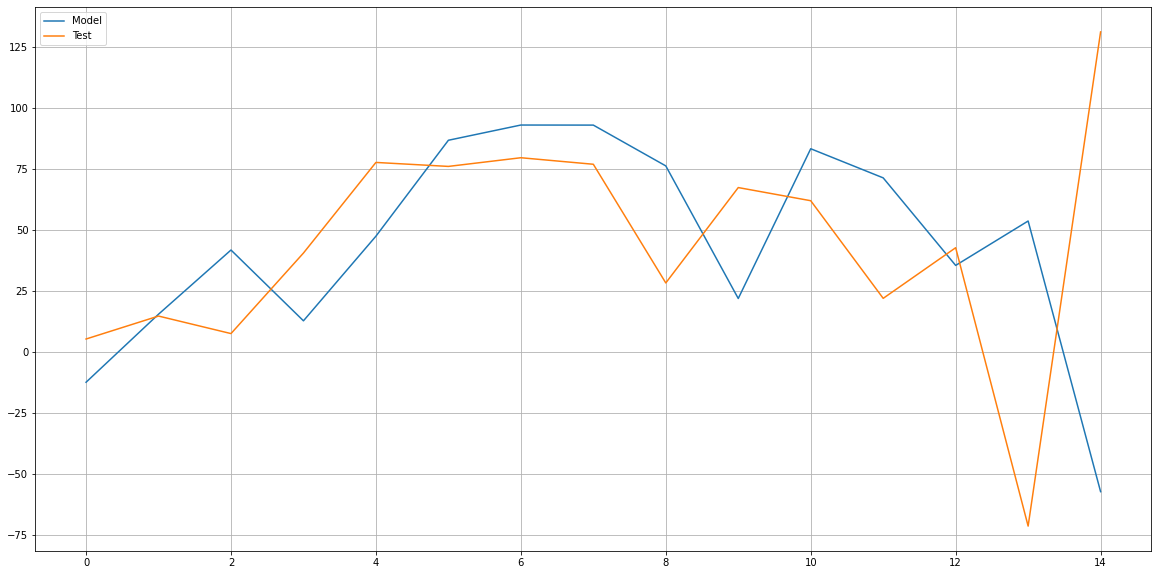

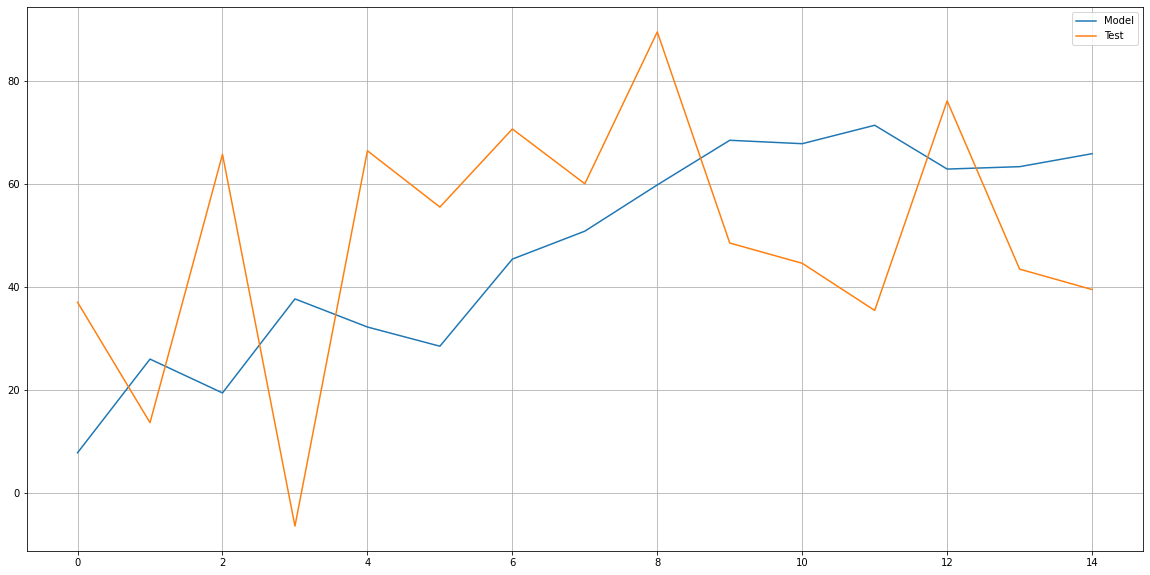

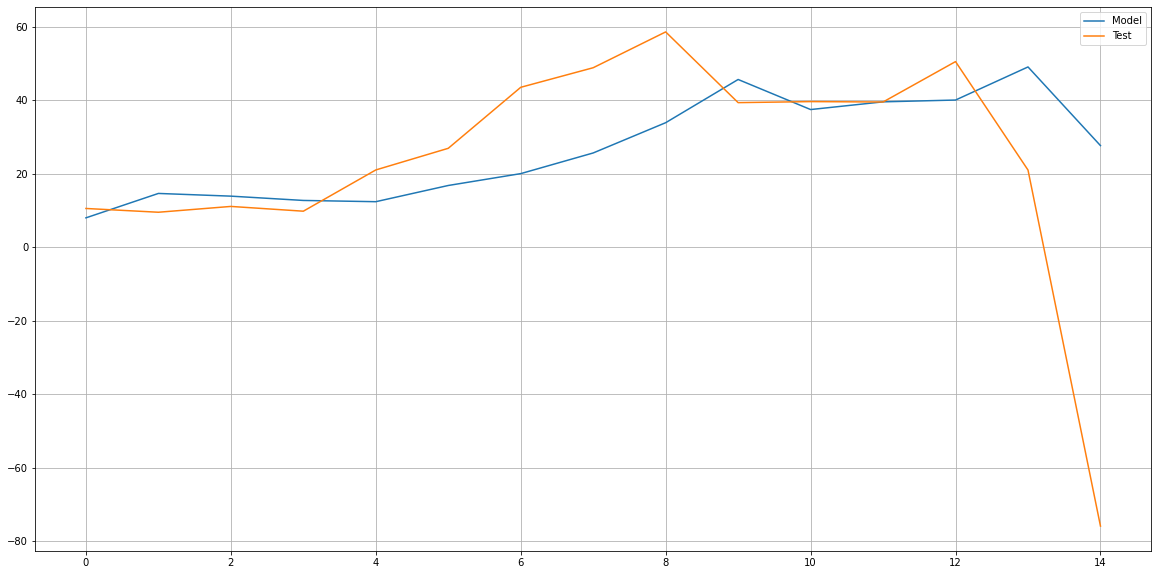

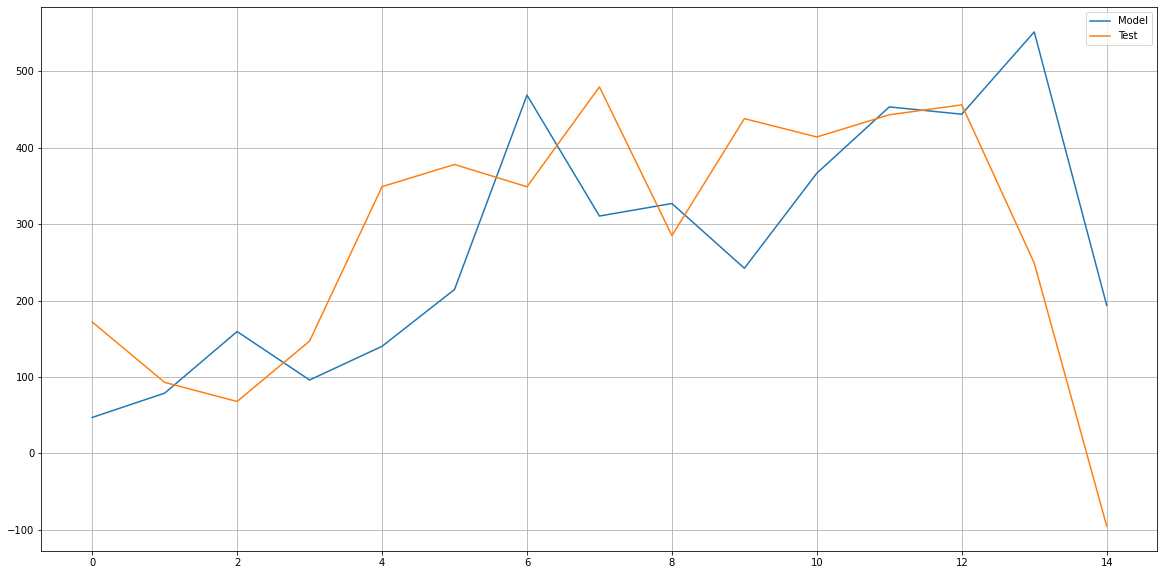

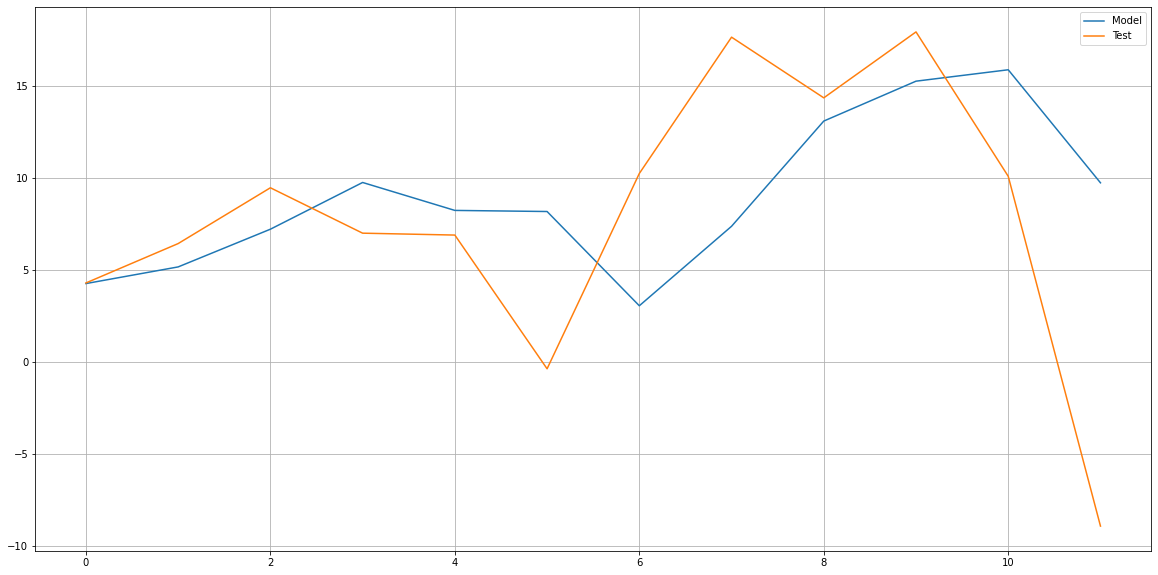

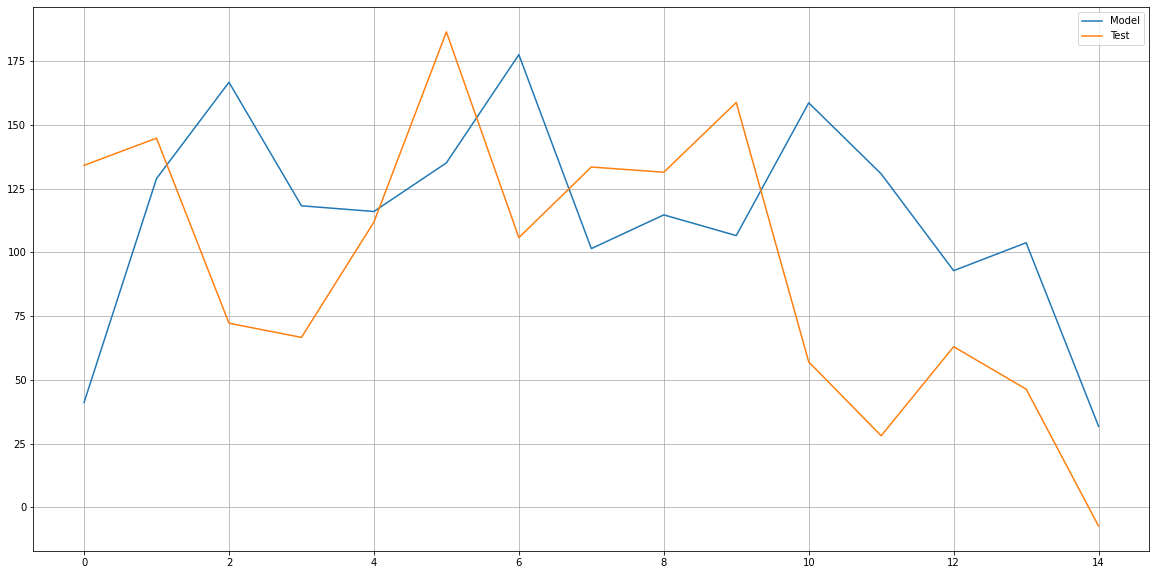

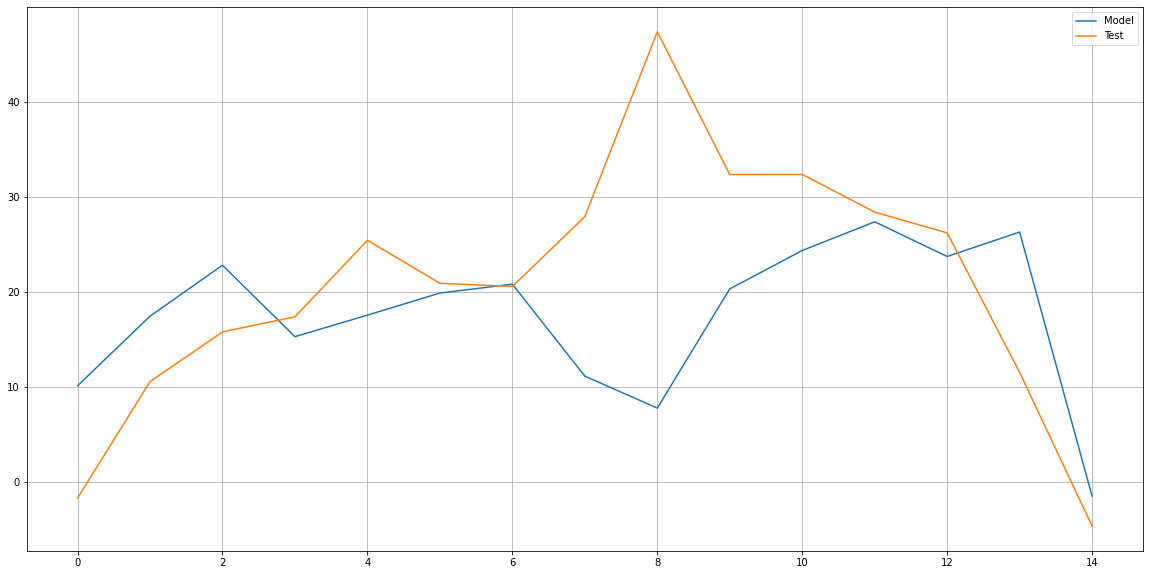

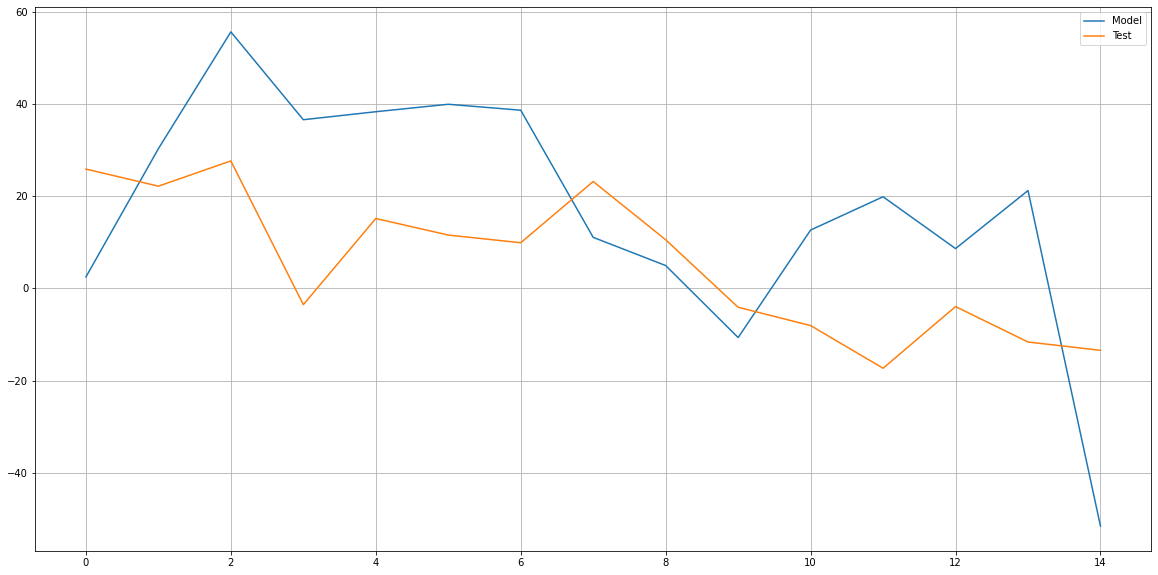

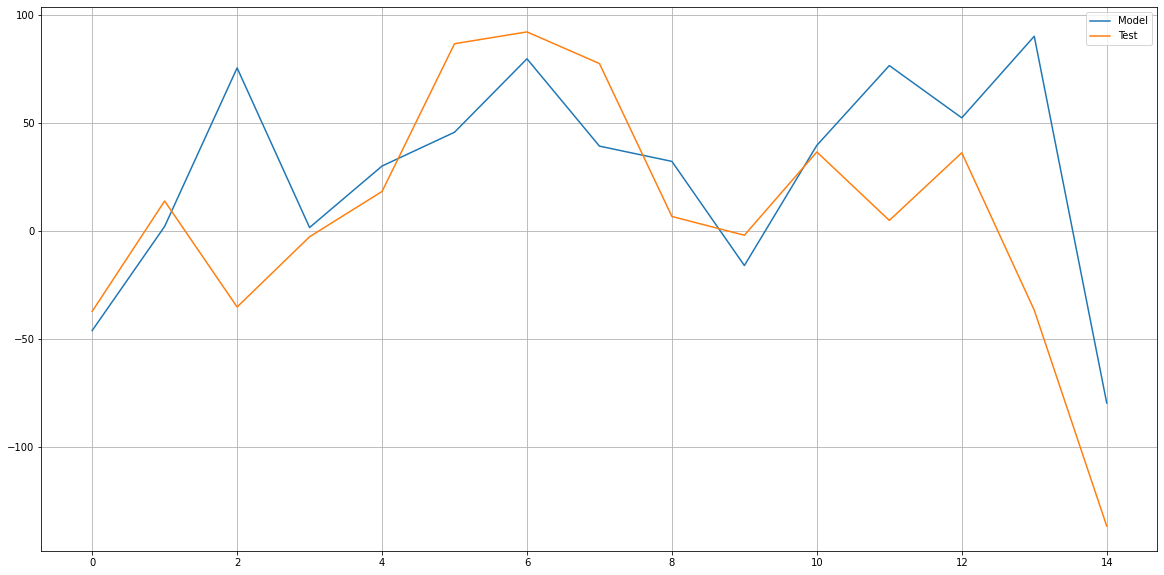

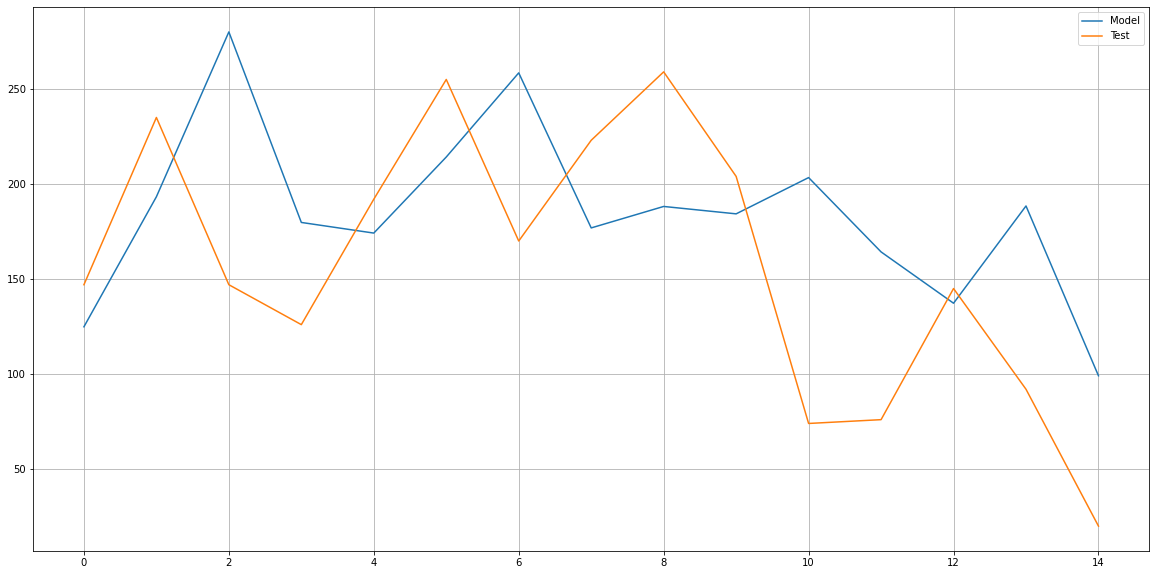

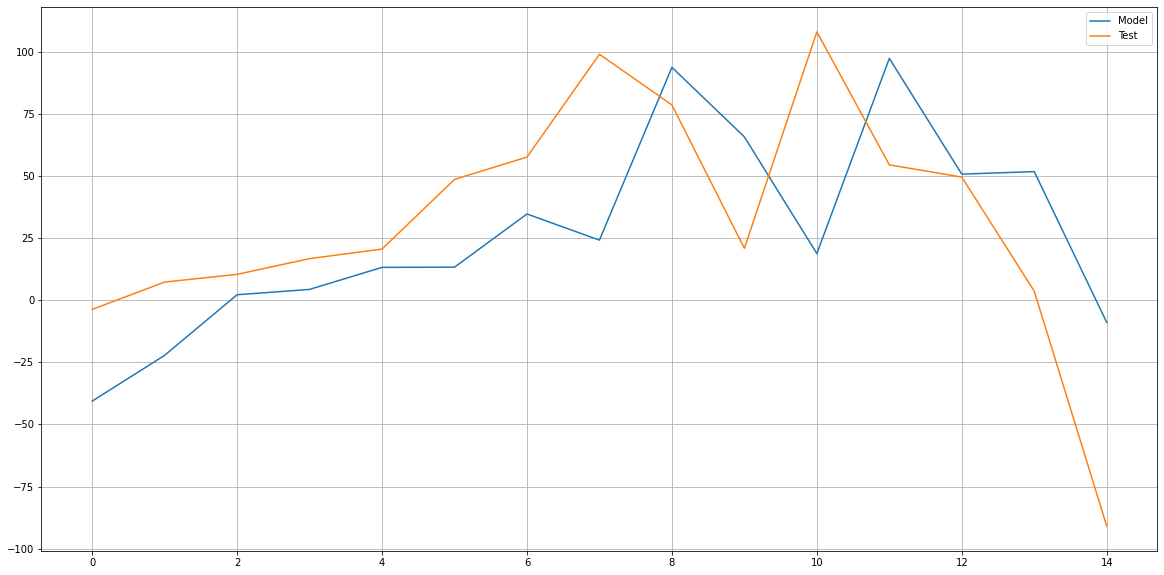

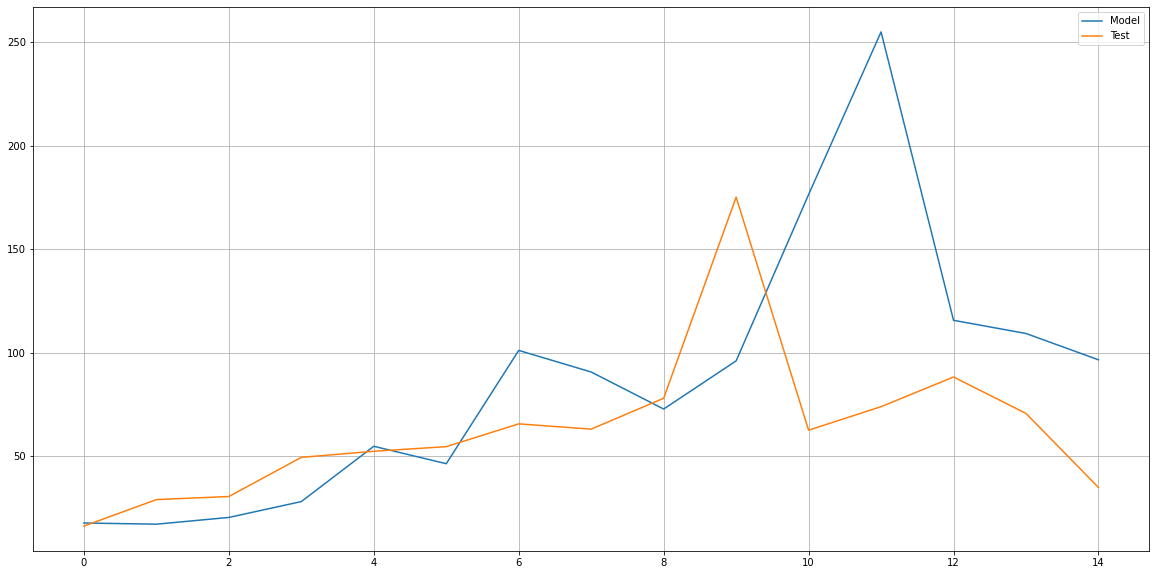

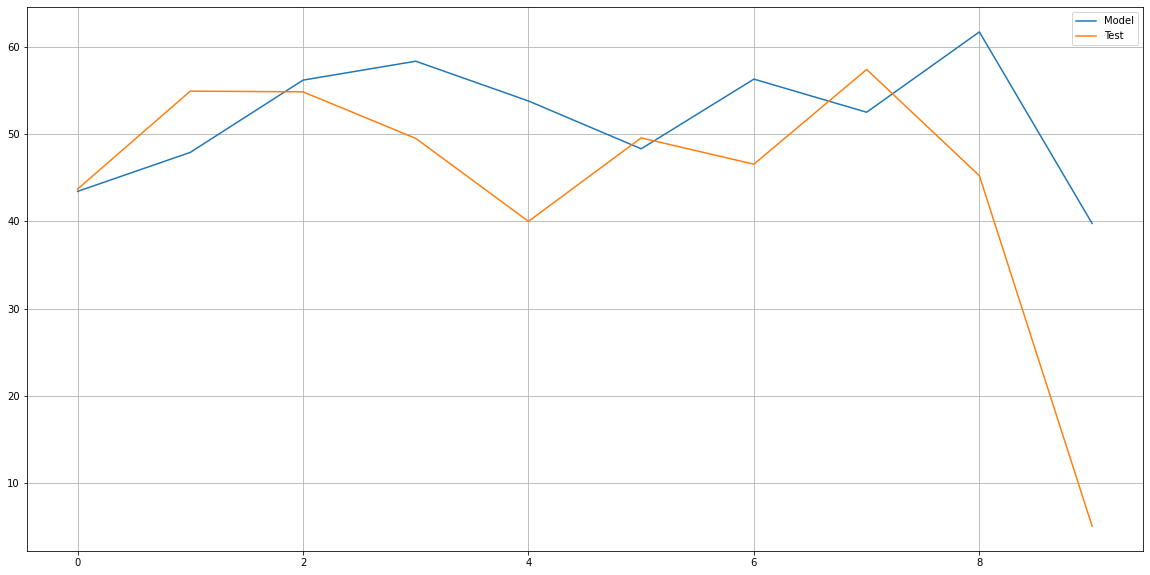

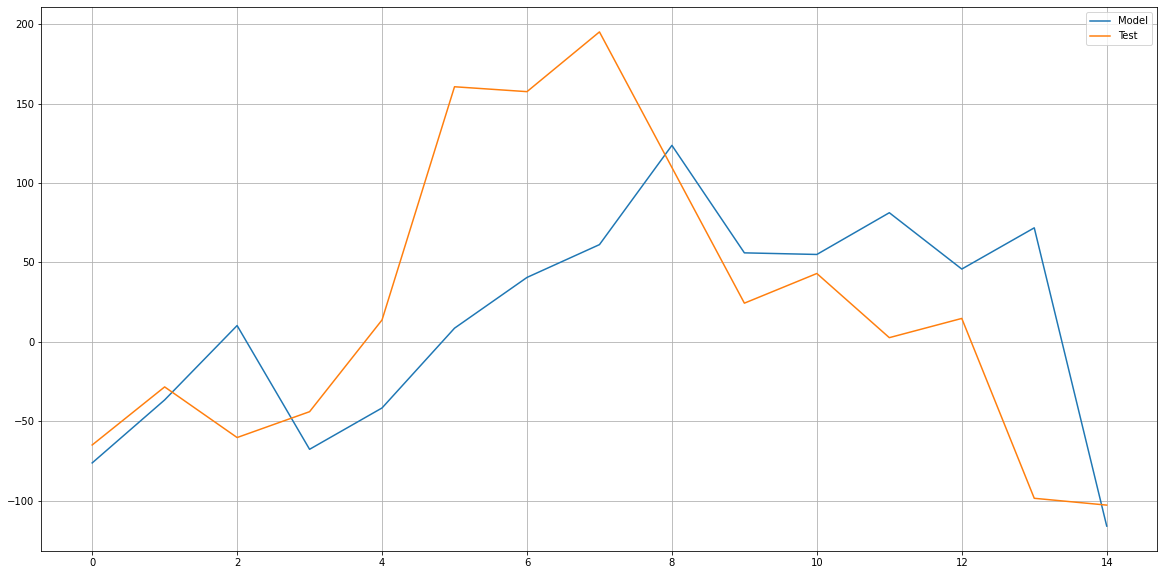

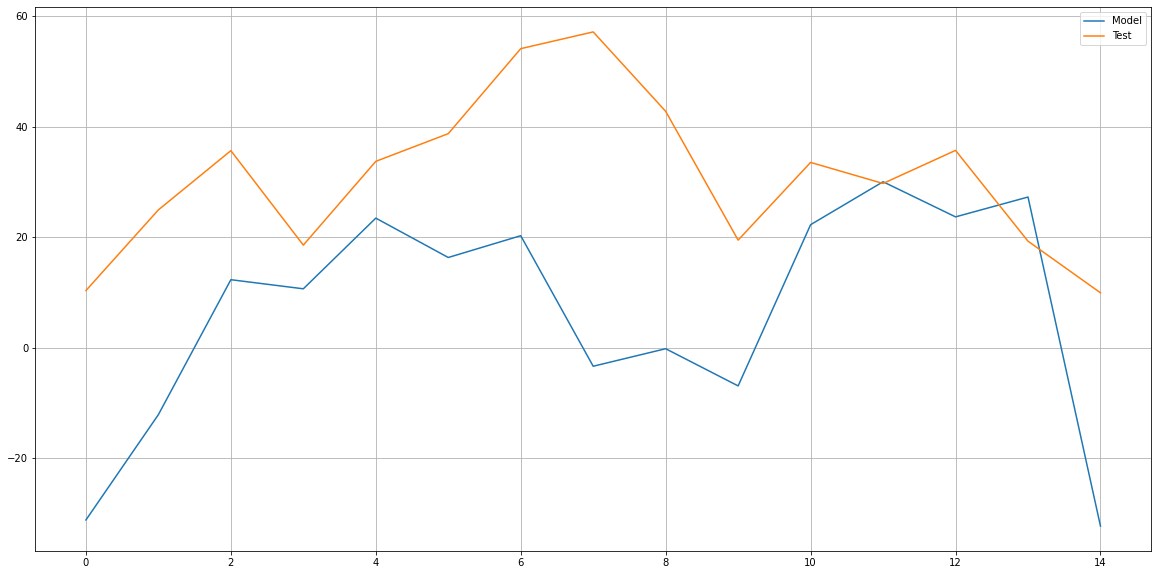

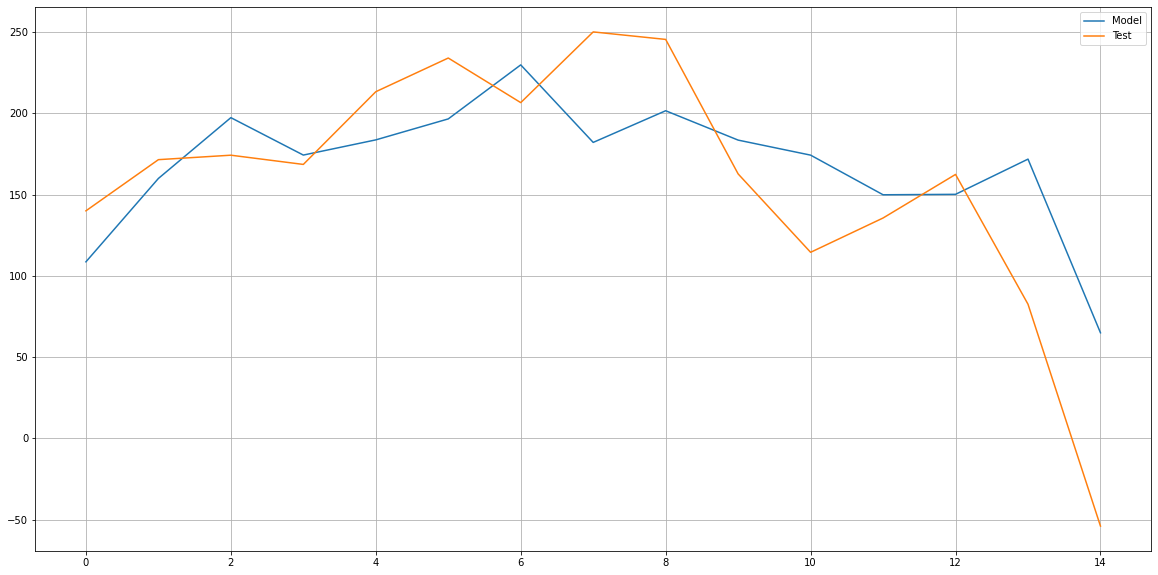

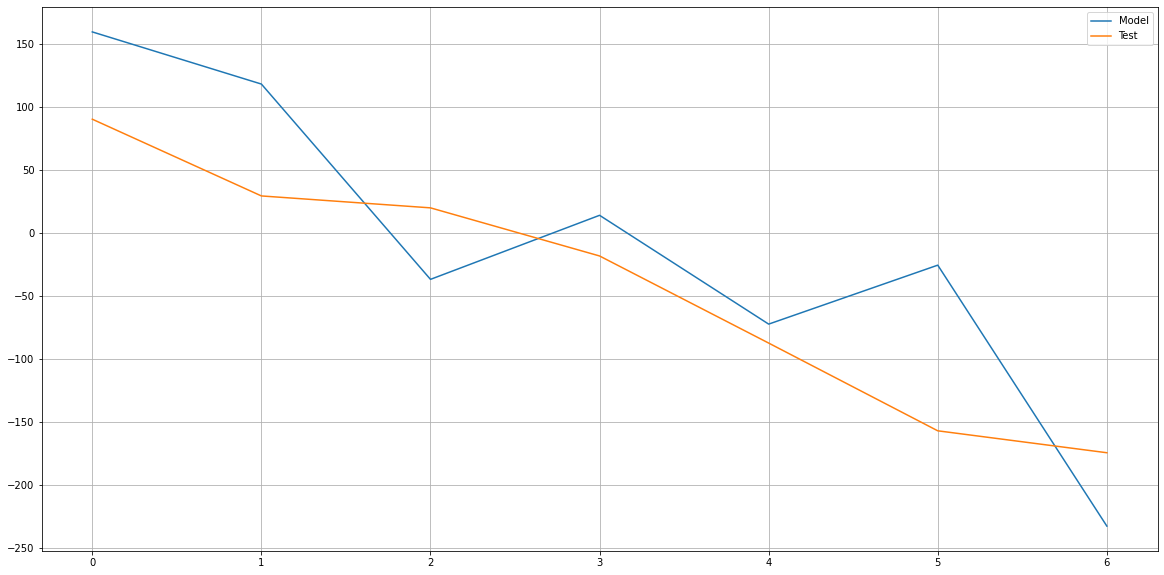

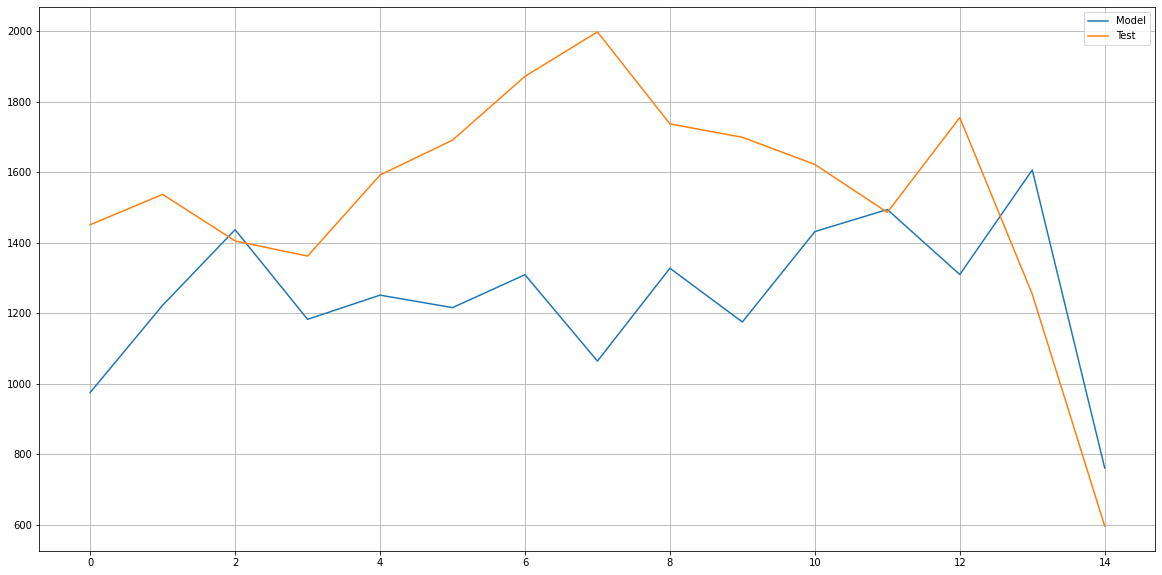

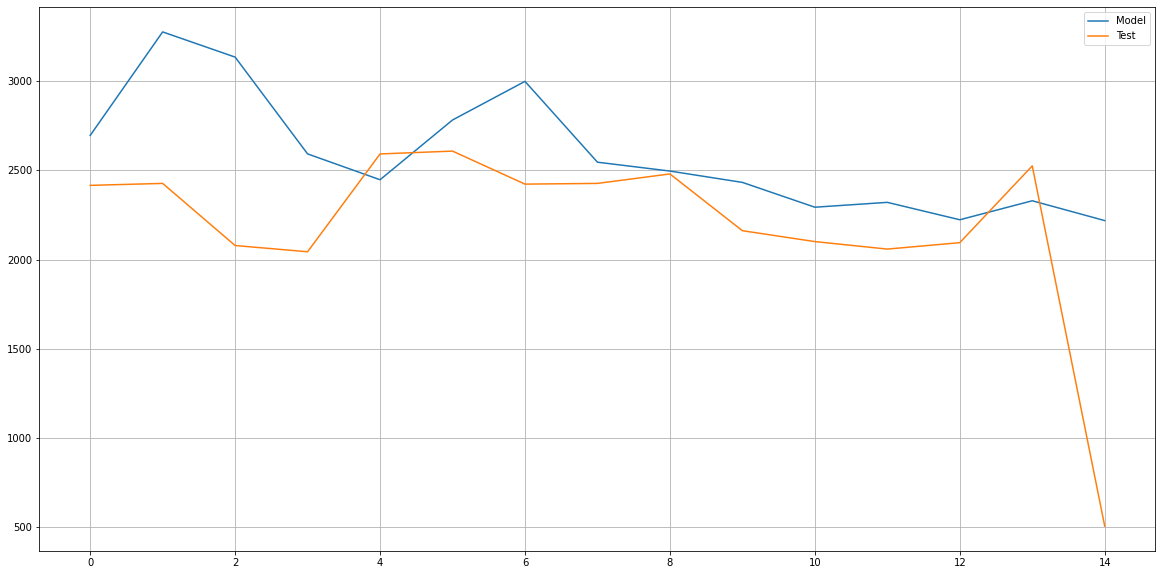

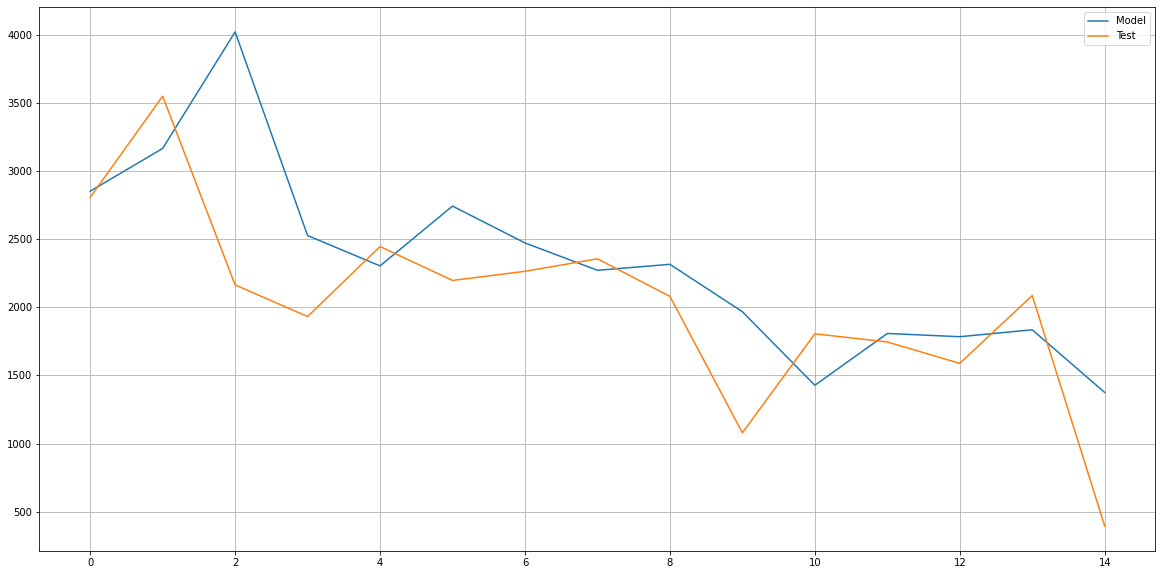

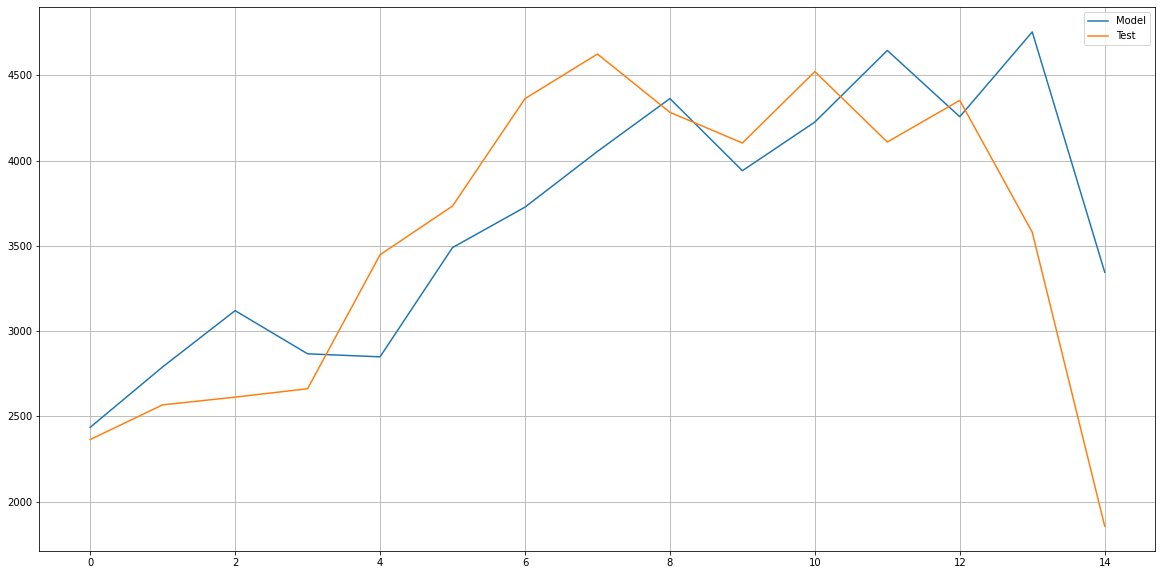

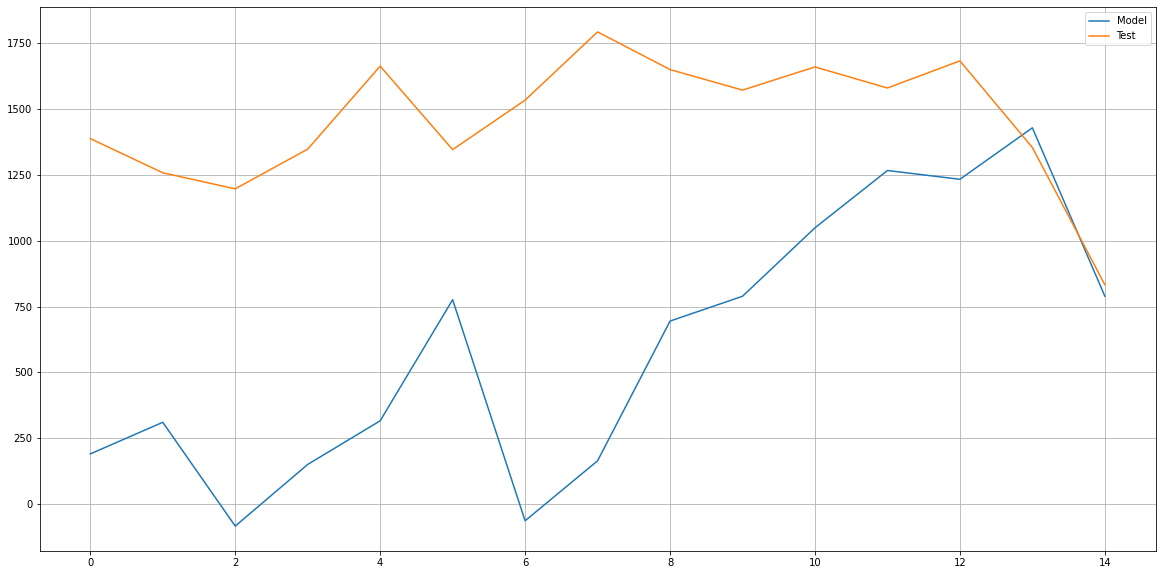

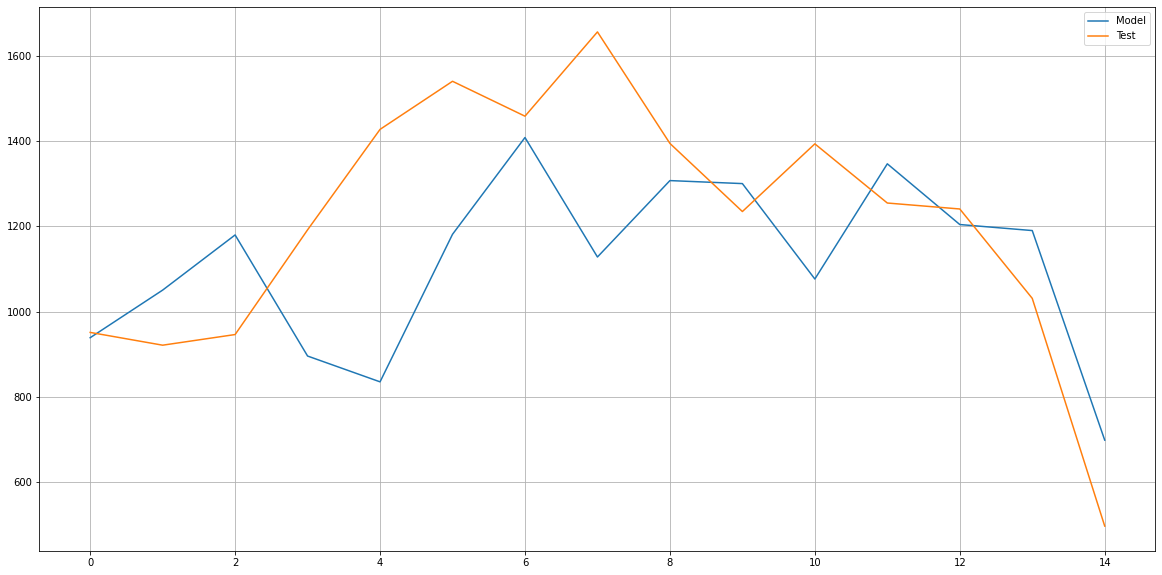

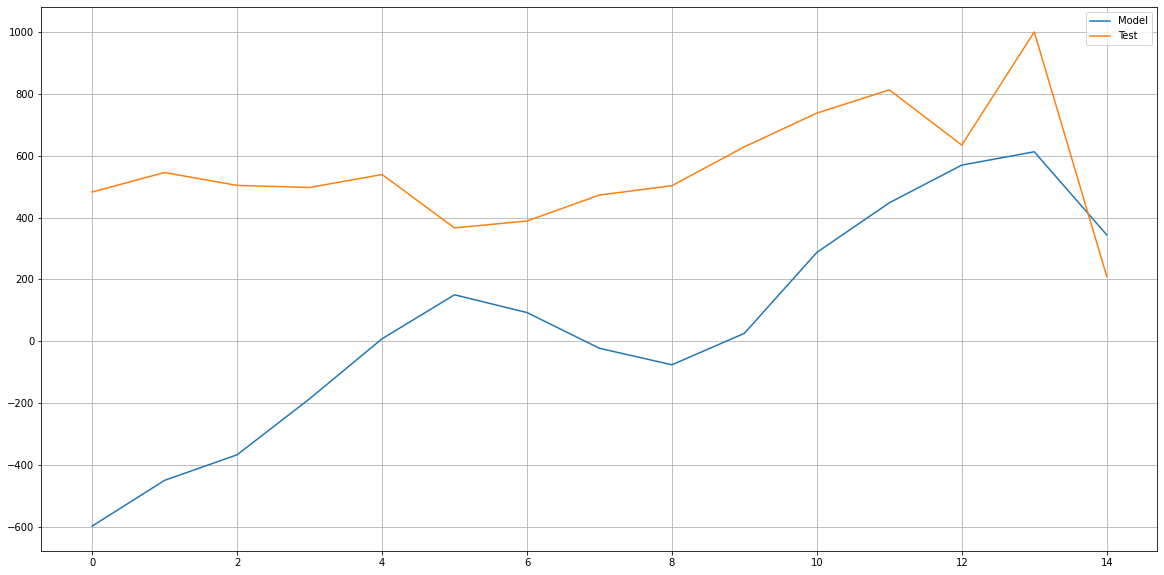

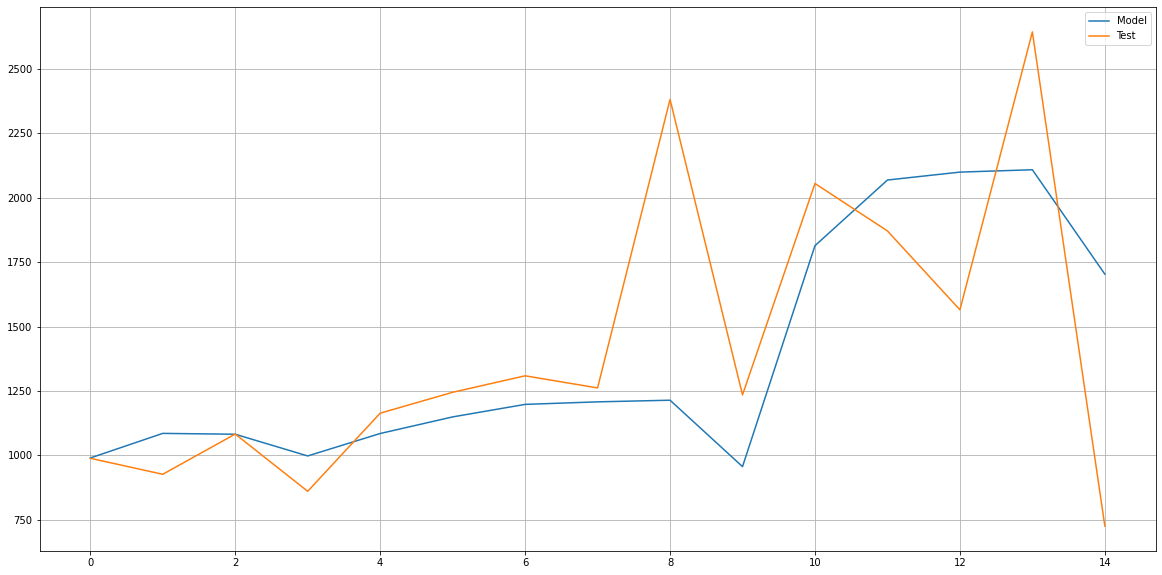

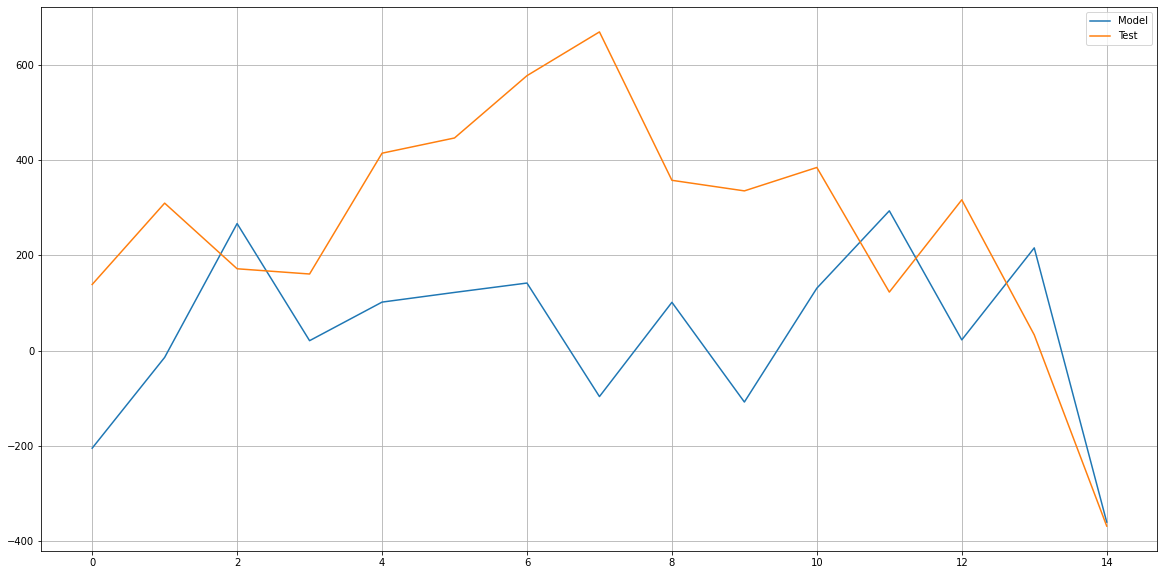

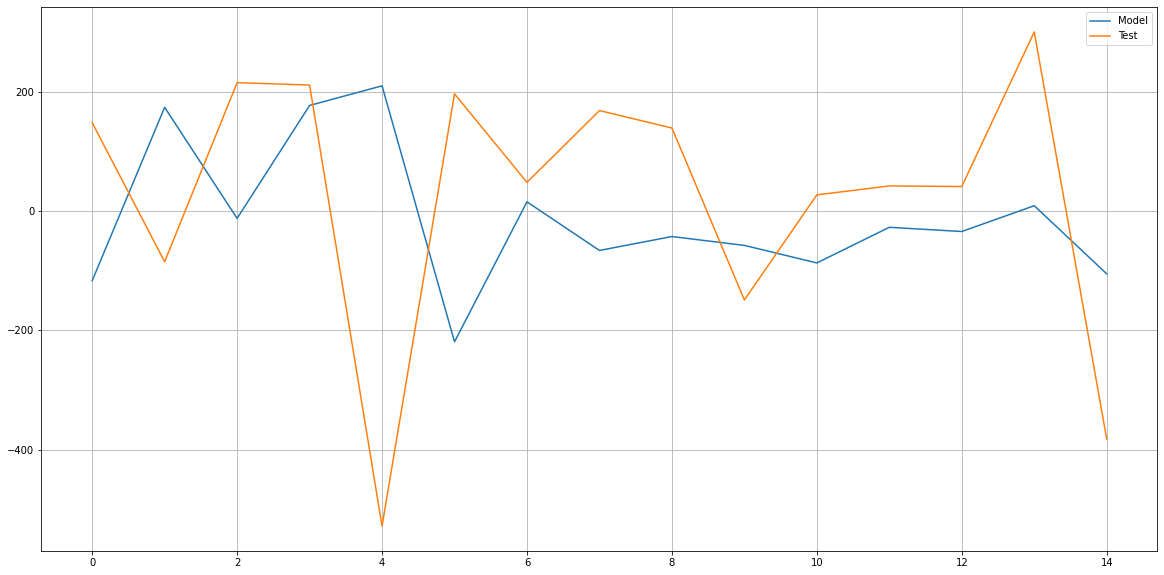

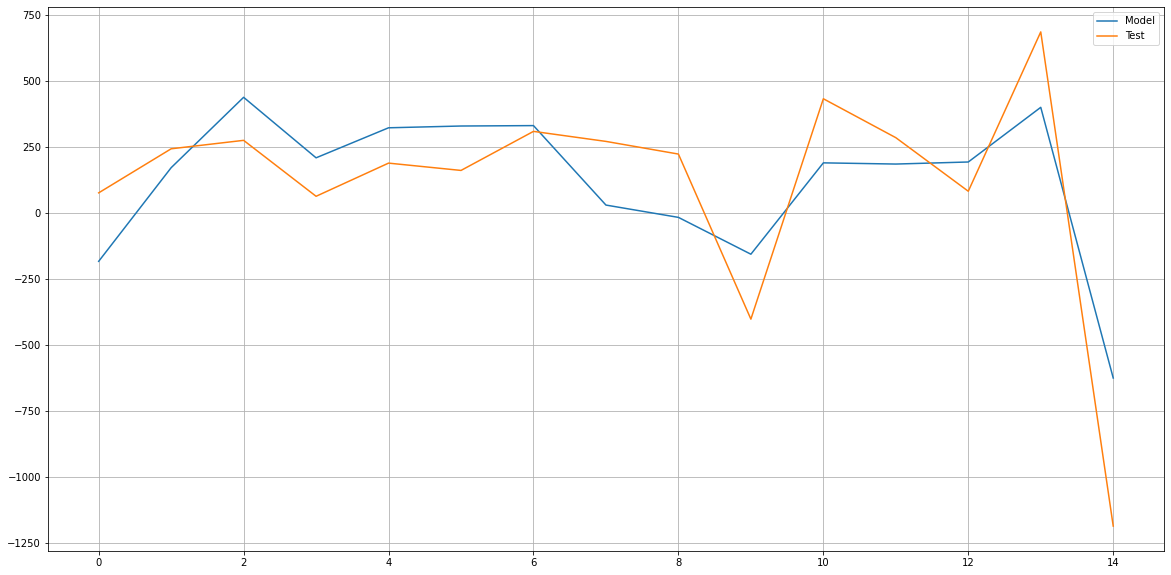

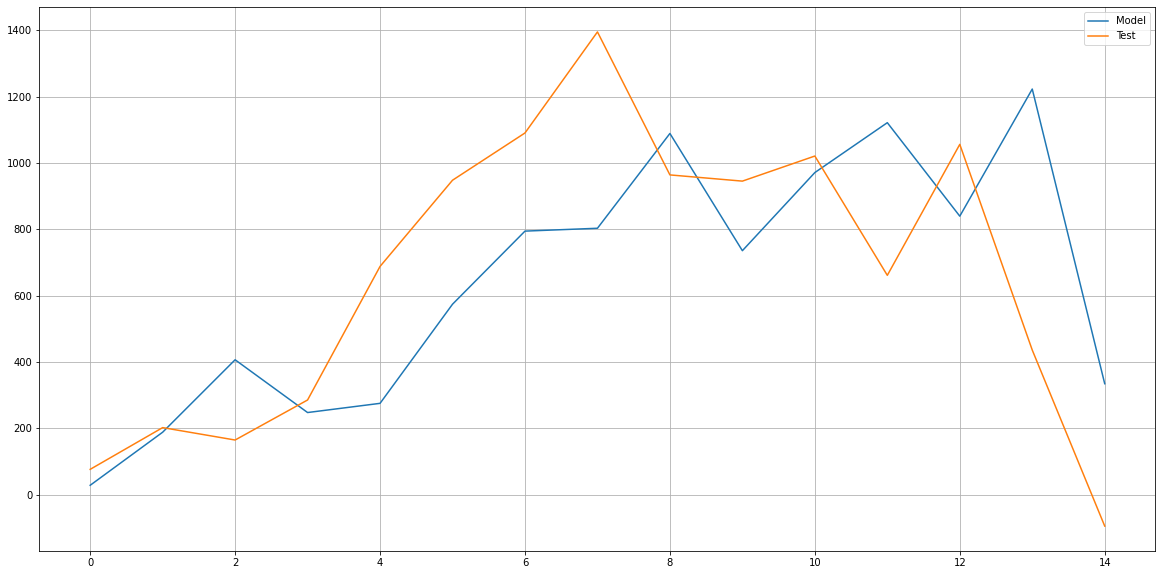

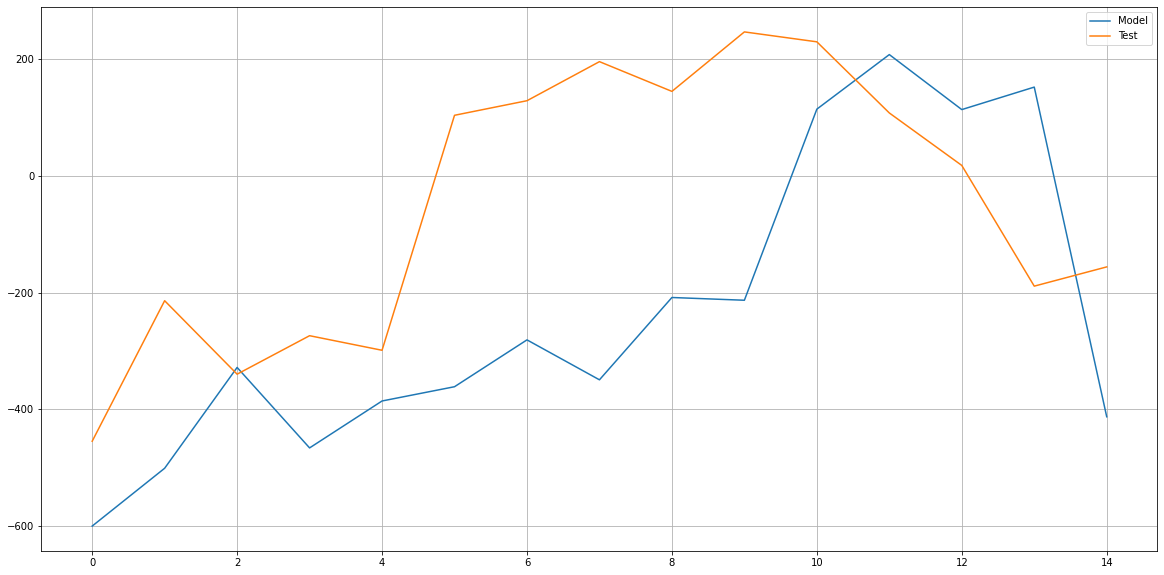

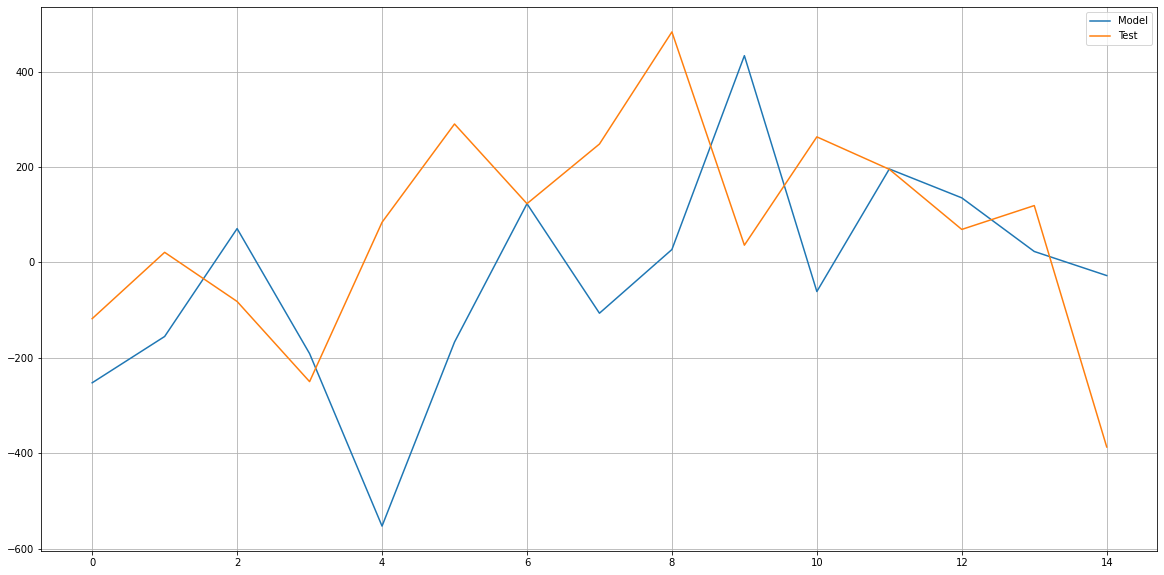

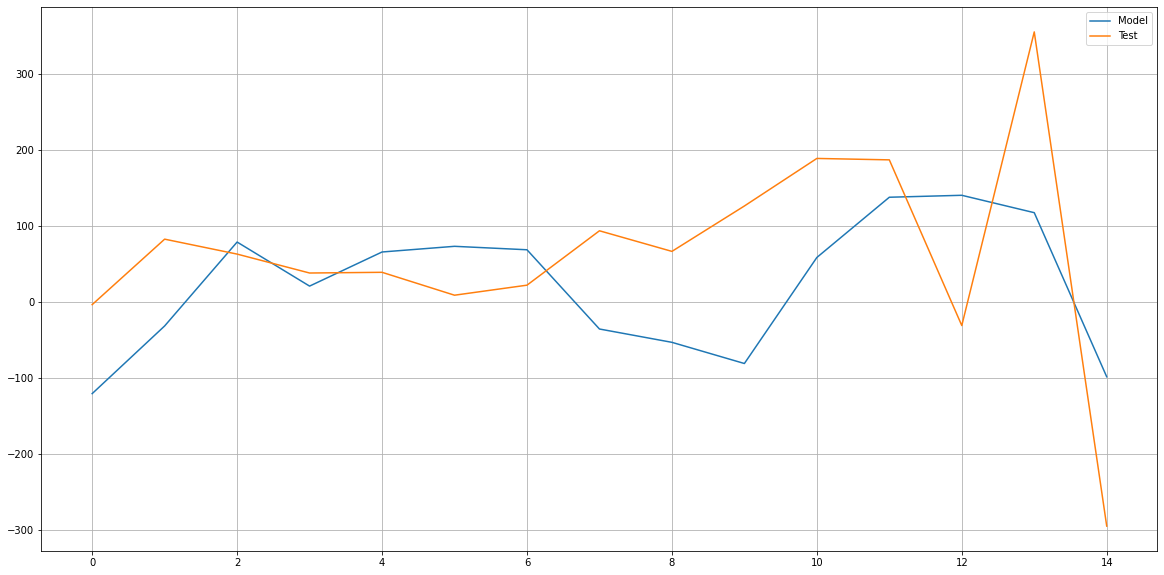

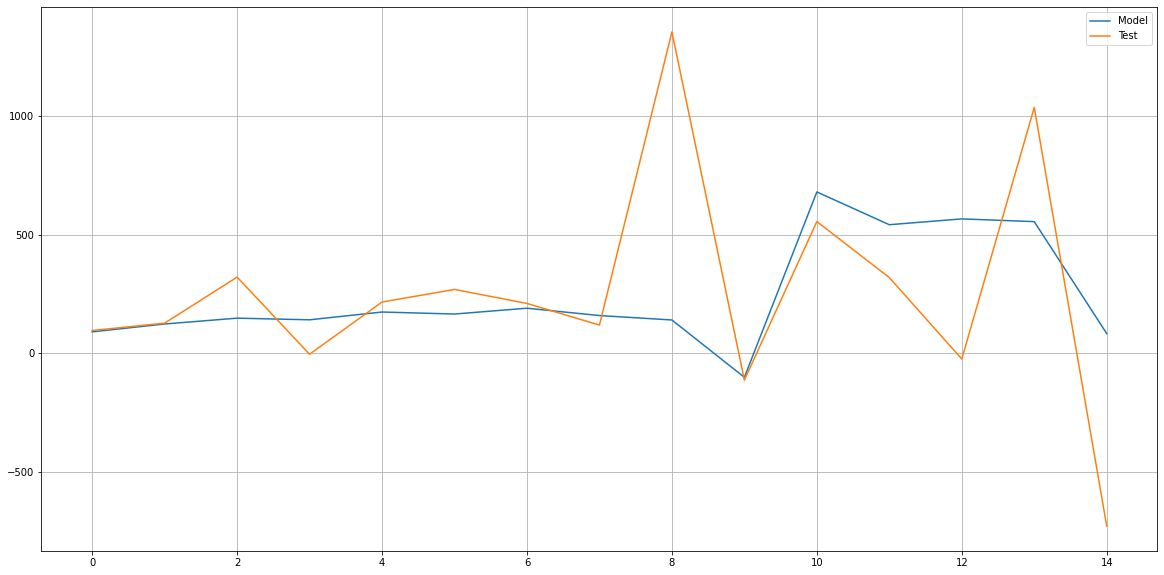

In [43]:
Validation_small_rev = companies_validation(Test_DF_small,'rev', multilinear_model, mean_absolute_error)
Validation_small_op_in = companies_validation(Test_DF_small,'op_in', multilinear_model, mean_absolute_error)
Validation_midlle_rev = companies_validation(Test_DF_midlle,'rev', multilinear_model, mean_absolute_error)
Validation_midlle_op_in = companies_validation(Test_DF_midlle,'op_in', multilinear_model, mean_absolute_error)

Results are better than for simple linear regression but still they are worse than naive model

In [39]:
print(Validation_small_rev.mean()
    ,Validation_small_op_in.mean()
    ,Validation_midlle_rev.mean()
    ,Validation_midlle_op_in.mean(), sep='\n')

rev    59.979086
dtype: float64
op_in    72.636024
dtype: float64
rev    451.424639
dtype: float64
op_in    234.305762
dtype: float64


For random forest (in process)

In [ ]:
Test_DF["oil"] = Test_DF["date"].map(lambda y: get_stock_price_for_date(y,"BZ=F"))


In [ ]:
talo["oil"] = talo["date"].map(lambda y: get_stock_price_for_date(y,"BZ=F"))

In [24]:
talo = Test_DF[Test_DF['company_name'] == "TALO"]

In [47]:
talo['Time'] = np.arange(len(talo.date))
talo = talo.reset_index(drop=True)


In [48]:
talo["future_value"] = talo["rev"].shift(-1)
row_to_predict = talo.tail(1)
talo = talo.dropna()

In [50]:
row_to_predict

company_name     rev       date   op_in     usd        oil  Time  \
37         TALO  88.874 2020-06-30 -90.915  69.973  40.310001    37   

    future_value  
37           NaN

In [51]:
talo

company_name         rev       date    op_in        usd         oil  Time  \
0          TALO  200.039008 2011-03-31   66.932  28.497000  115.290001     0   
1          TALO  234.836000 2011-06-30   91.257  27.967699  108.980003     1   
2          TALO  206.312000 2011-09-30   72.412  31.972700  104.900002     2   
3          TALO  223.616000 2011-12-31   75.281  31.965000  107.269997     3   
4          TALO  244.956992 2012-03-31   85.412  29.406200  123.269997     4   
5          TALO  221.144992 2012-06-30   50.740  33.079201   94.050003     5   
6          TALO  227.396992 2012-09-30   46.297  30.953199  112.769997     6   
7          TALO  254.562000 2012-12-31   78.088  30.331100  110.430000     7   
8          TALO  233.732000 2013-03-31   74.049  31.052799  109.879997     8   
9          TALO  244.508992 2013-06-30   68.157  32.790699  102.910004     9   
10         TALO  256.684992 2013-09-30   64.106  32.342098  108.660004    10   
11         TALO  239.252992 2013-12-31   50.349  32.716202  112.360001    11   
12         TALO  223.830000 2014-03-31   49.151  35.639999  107.699997    12   
13         TALO  207.046000 2014-06-30   19.129  33.728699  113.129997    13   
14         TALO  177.431008 2014-09-30    6.992  39.356201   97.000000    14   
15         TALO  184.780000 2014-12-31    1.231  56.544998   57.910000    15   
16         TALO  154.998000 2015-03-31   -4.282  57.625702   56.080002    16   
17         TALO  149.524992 2015-06-30    2.533  55.709999   62.650002    17   
18         TALO  135.096000 2015-09-30    5.270  65.800003   47.209999    18   
19         TALO  116.099000 2015-12-31   13.903  73.815002   37.410000    19   
20         TALO   80.877000 2016-03-31  -42.746  67.878998   39.400002    20   
21         TALO   89.319000 2016-06-30  -46.571  63.981998   48.919998    21   
22         TALO   94.427000 2016-09-30  -29.860  63.055199   48.959999    22   
23         TALO  113.107000 2016-12-31   -3.716  60.143799   56.130001    23   
24         TALO  101.824000 2017-03-31    7.287  56.061699   52.400002    24   
25         TALO   95.426000 2017-06-30   10.384  59.419998   47.439999    25   
26         TALO   99.962000 2017-09-30   16.712  57.889801   57.529999    26   
27         TALO  115.616000 2017-12-31   20.569  57.569199   66.599998    27   
28         TALO  145.850000 2018-03-31   48.584  57.237099   69.809998    28   
29         TALO  203.906000 2018-06-30   57.573  62.834202   77.769997    29   
30         TALO  282.868000 2018-09-30   98.956  65.529099   81.540001    30   
31         TALO  258.664000 2018-12-31   78.552  69.625801   53.029999    31   
32         TALO  178.712992 2019-03-31   20.862  64.868202   68.000000    32   
33         TALO  286.809984 2019-06-30  107.943  63.055801   66.650002    33   
34         TALO  228.856992 2019-09-30   54.446  64.620300   62.529999    34   
35         TALO  233.240000 2019-12-31   49.524  61.972500   68.209999    35   
36         TALO  187.764000 2020-03-31    3.603  79.588898   24.000000    36   

    future_value  
0     234.836000  
1     206.312000  
2     223.616000  
3     244.956992  
4     221.144992  
5     227.396992  
6     254.562000  
7     233.732000  
8     244.508992  
9     256.684992  
10    239.252992  
11    223.830000  
12    207.046000  
13    177.431008  
14    184.780000  
15    154.998000  
16    149.524992  
17    135.096000  
18    116.099000  
19     80.877000  
20     89.319000  
21     94.427000  
22    113.107000  
23    101.824000  
24     95.426000  
25     99.962000  
26    115.616000  
27    145.850000  
28    203.906000  
29    282.868000  
30    258.664000  
31    178.712992  
32    286.809984  
33    228.856992  
34    233.240000  
35    187.764000  
36     88.874000

In [67]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(talo[["rev","op_in","usd","Time"]])
#X_test_scaled = ss.transform(X_test)
y_train = np.array(talo["future_value"])

In [ ]:
model = LinearRegression().fit(talo[["rev","op_in","usd","Time"]], talo["future_value"][:])
next_value = model.predict(row_to_predict[["rev","op_in","usd","Time"]])[0]

In [68]:
y_train

array([234.836   , 206.312   , 223.616   , 244.956992, 221.144992,
       227.396992, 254.562   , 233.732   , 244.508992, 256.684992,
       239.252992, 223.83    , 207.046   , 177.431008, 184.78    ,
       154.998   , 149.524992, 135.096   , 116.099   ,  80.877   ,
        89.319   ,  94.427   , 113.107   , 101.824   ,  95.426   ,
        99.962   , 115.616   , 145.85    , 203.906   , 282.868   ,
       258.664   , 178.712992, 286.809984, 228.856992, 233.24    ,
       187.764   ,  88.874   ])

In [57]:
X_train_scaled

array([[ 0.21086264,  0.76972695, -1.38079745, -1.68585446],
       [ 0.79050258,  1.39532667, -1.41409029, -1.59219588],
       [ 0.31535664,  0.9106637 , -1.16217706, -1.4985373 ],
       [ 0.60360251,  0.98444974, -1.16266138, -1.40487872],
       [ 0.95909563,  1.24500271, -1.32360903, -1.31122014],
       [ 0.56244106,  0.35329485, -1.09257854, -1.21756156],
       [ 0.66658537,  0.23902806, -1.22630331, -1.12390297],
       [ 1.11909355,  1.05664125, -1.26543313, -1.03024439],
       [ 0.77211241,  0.95276469, -1.22003852, -0.93658581],
       [ 0.95163296,  0.80123197, -1.1107252 , -0.84292723],
       [ 1.15445784,  0.69704679, -1.13894204, -0.74926865],
       [ 0.86407977,  0.34323896, -1.11541105, -0.65561007],
       [ 0.60716727,  0.31242834, -0.93150516, -0.56195149],
       [ 0.32758343, -0.45968903, -1.05172533, -0.46829291],
       [-0.16573599, -0.77183307, -0.6977573 , -0.37463432],
       [-0.04331825, -0.91999669,  0.38341229, -0.28097574],
       [-0.53941965, -1.

In [70]:
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor()
forest_model.fit(X_train_scaled, y_train)
display(forest_model.score(X_train_scaled, y_train))
# 1.0

0.9480303948581641

In the future, I want to try, firstly, to use more attributes, secondly, to use more complex models, and thirdly, to do different data processing for several clusters.

For the future

In [ ]:
#feats = {}
#for feature, importance in zip(data.columns, rfc_1.feature_importances_):
#    feats[feature] = importance
#importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
#importances = importances.sort_values(by='Gini-Importance', ascending=False)
#importances = importances.reset_index()
#importances = importances.rename(columns={'index': 'Features'})
#sns.set(font_scale = 5)
#sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
#fig, ax = plt.subplots()
#fig.set_size_inches(30,15)
#sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
#plt.xlabel('Importance', fontsize=25, weight = 'bold')
#plt.ylabel('Features', fontsize=25, weight = 'bold')
#plt.title('Feature Importance', fontsize=25, weight = 'bold')
#display(plt.show())
#display(importances)

In [42]:
#or company_name in Train_DF_small.company_name.unique():
#   DF_of_one_company = Train_DF_small.loc[Train_DF_small.company_name == company_name] 
#   DF_of_one_company['Time'] = np.arange(len(DF_of_one_company.date))
#   new_row = dict(DF_of_one_company.iloc[-1])
#   new_row['rev'] = linear_model(DF_of_one_company, 'rev')
#   new_row['op_in'] = linear_model(DF_of_one_company, 'op_in')
#   new_row['date'] = new_row['date'] + pd.DateOffset(months=3)
#   new_row['Time'] = new_row['Time'] + 1
#   new_row = pd.DataFrame([new_row])
#   print(new_row)
#   Train_DF_small = pd.concat([Train_DF_small, new_row], ignore_index = True)


In [43]:
#Train_DF_Mid_APA = Train_DF.loc[Train_DF.company_name == 'APA']
#Train_DF_Mid_APA['Time'] = np.arange(len(Train_DF_Mid_APA.date))
#Train_DF_Mid_APA = Train_DF_Mid_APA.reset_index(drop=True)
#Train_DF_Mid_APA
#new = dict(Train_DF_Mid_APA.iloc[-1])
#new['rev'] = linear_model(Train_DF_Mid_APA, 'rev')
#new['op_in'] = linear_model(Train_DF_Mid_APA, 'op_in')
#new['date'] = new['date'] + pd.DateOffset(months=3)
#new['Time'] = new['Time'] + 1
#new = pd.DataFrame([new])
#Train_DF_Mid_APA = pd.concat([Train_DF_Mid_APA, new], ignore_index = True)
#model = LinearRegression().fit(np.array(Train_DF_Mid_APA.Time[:]).reshape((-1,1)), Train_DF_Mid_APA.rev[:])
#next = model.coef_[0]*38 + model.intercept_
#next